## Perturb duplicate filters

We perturb duplicate filters by increasing amounts and see whether they converge to their earlier positions.

In [1]:
import os
import torch
import torchvision
import torch.optim as optim
import torch.optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR
import json
from vis_utils import *
from model_def import *
from model_train import *
from net_reduce import *
%matplotlib inline


verboseFrequency=250
doTrainPlot=True 
doVisFilter=True  # VERY slow if true

SIMIL_THRESH = 0.9
LAYER_CURR = 'fc1'
LAYER_NEXT = 'fc2'

batchSize = 100
useGpu = True
numEpochs = 30
learningRate = 0.01
gamma = 0.9  # learning rate decay
lr_decay_step = 1 # decay lr every "x" epochs
momentum = 0.9
weight_decay = 0.04

# setup and load CIFAR dataset for MLP
trainloader, testloader, classes = setup_cifar_data_mlp(batchSize)

Files already downloaded and verified
Files already downloaded and verified


## Single-network experiments

In [20]:
# check with a single network
w1 = 500
w2 = 100
pre_trained_net_dir = './data/cifar-mlp-v1_w1-500'      

# Load pre-trained MLP model
net = MLP(input_dim=3072, fc1_dim=w1, fc2_dim=w2)
net.load_state_dict(torch.load(os.path.join(pre_trained_net_dir, 'net-trained.dat')))

[9, 29, 52, 66, 69, 99, 128, 139, 163, 169, 177, 216, 236, 247, 258, 266, 283, 318, 321, 343, 345, 348, 360, 362, 363, 412, 426, 442, 446, 453, 482, 499]


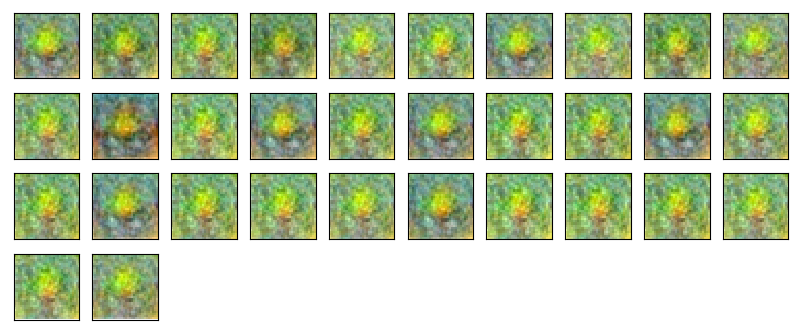

In [21]:
net.cpu()
layer_curr_weights = get_param(net, LAYER_CURR+'.weight')
layer_curr_biases = get_param(net, LAYER_CURR+'.bias')
layer_next_weights = get_param(net, LAYER_NEXT+'.weight')

similMat, _ = get_layer_cosine_similarity(net, LAYER_CURR+'.weight') # returned as numpy arrays
adj_mat = np.greater(similMat, SIMIL_THRESH) 
cc_list, n_comps = get_adjmat_conn_comp(adj_mat)

# MLP: linear weights vis
# f = vis_linear_weights(layer_curr_weights.numpy()[cc_list[9]]) 
# print cc_list[9]
f = vis_linear_weights(layer_curr_weights.numpy()[cc_list[4]])
print cc_list[4]

[4, 18, 156, 235]


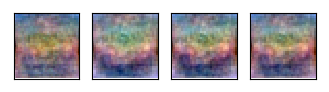

In [19]:
f = vis_linear_weights(layer_curr_weights.numpy()[cc_list[4]])
print cc_list[4]

In [24]:
perturb_deltas = [0.001, 0.005, 0.01]
perturb_epochs = [20, 80, 80]

# Run this N times
N = 10

# expname:
# 1) expName = 'cifar-mlp-w1-500-perturb-add-n0-%.3f-%d' % (t,i)
#    additive zero-mean Gaussian with larger spreads....
#
# 2) 


# run each perturb_delta N times
for t in perturb_deltas:
    for i in range(N):

        # Add new filter, fix the rest
        expName = 'cifar-mlp-w1-500-perturb-add-n0-%.3f-%d' % (t,i)     
        w1 = 500
        w2 = 100
        pre_trained_net_dir = './data/cifar-mlp-v1_w1-500'
        verboseFrequency=100
        doTrainPlot=True 
        doVisFilter=False
        perturb_layer = 'fc1'
        perturb_filter = 4 # which filter to perturb
        numEpoch = 20

        # -----------------------------------------------------------------------------
        # experiment folder
        expDir = os.path.join('./data', 'perturb-filter', expName)
        if not os.path.exists(expDir):
            os.makedirs(expDir)        

        # manual seed - different for each run
        torch.manual_seed(i)
        torch.cuda.manual_seed_all(i)     

        # Load pre-trained MLP model
        net = MLP(input_dim=3072, fc1_dim=w1, fc2_dim=w2)
        net.load_state_dict(torch.load(os.path.join(pre_trained_net_dir, 'net-trained.dat')))
        
        # save orig filter visualizations
        fc1Params = list(net.fc1.parameters())
        f = vis_linear_weights(fc1Params[0].cpu().data.numpy(), num_cols=50)
        f.savefig(os.path.join(expDir, 'filters-orig.png'), bbox_inches='tight')
        plt.close(f)
        
        # perturbation
        param_dict = net.state_dict()
        p1 = param_dict[LAYER_CURR+'.weight']
        filter_1 = p1[perturb_filter]
        filter_1.add_(torch.randn(filter_1.size())*t);
        
        # save perturbed filter visualizations
        fc1Params = list(net.fc1.parameters())
        f = vis_linear_weights(fc1Params[0].cpu().data.numpy(), num_cols=50)
        f.savefig(os.path.join(expDir, 'filters-perturbed.png'), bbox_inches='tight')
        plt.close(f)

        # train settings
        valloader = testloader
        criterion = nn.CrossEntropyLoss() 
        optimizer = optim.SGD(net.parameters(), lr=learningRate, momentum=momentum, weight_decay=weight_decay) 
        scheduler = optim.lr_scheduler.StepLR(optimizer, lr_decay_step, gamma=gamma)

        # train ONLY the perturbed filter
        train_cifar_net(net, trainloader, valloader, criterion, \
                           (optimizer, scheduler), expDir, \
                            batchSize=100,numEpochs=numEpoch, \
                            useGpu=useGpu,verboseFrequency=verboseFrequency, \
                            doTrainPlot=doTrainPlot,doVisFilter=doVisFilter,\
                            perturbed_filter=perturb_filter)
        
        # save network
        torch.save(net.state_dict(), os.path.join(expDir, 'net-trained.dat'))
        
        
        # save converged filters visualization
        fc1Params = list(net.fc1.parameters())
        f = vis_linear_weights(fc1Params[0].cpu().data.numpy(), num_cols=50)
        f.savefig(os.path.join(expDir, 'filters-final.png'), bbox_inches='tight')
        plt.close(f)


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.290 accu: 0.556 lr: 0.010000
epoch:   0 batch:   200 loss: 1.267 accu: 0.565 lr: 0.010000
epoch:   0 batch:   300 loss: 1.270 accu: 0.572 lr: 0.010000
epoch:   0 batch:   400 loss: 1.265 accu: 0.567 lr: 0.010000
epoch:   0 batch:   500 loss: 1.267 accu: 0.568 lr: 0.010000


  5%|▌         | 1/20 [00:13<04:13, 13.34s/it]

epoch:   1 batch:   100 loss: 1.280 accu: 0.563 lr: 0.009000
epoch:   1 batch:   200 loss: 1.268 accu: 0.569 lr: 0.009000
epoch:   1 batch:   300 loss: 1.257 accu: 0.572 lr: 0.009000
epoch:   1 batch:   400 loss: 1.277 accu: 0.558 lr: 0.009000
epoch:   1 batch:   500 loss: 1.275 accu: 0.567 lr: 0.009000


 10%|█         | 2/20 [00:26<03:58, 13.26s/it]

epoch:   2 batch:   100 loss: 1.280 accu: 0.564 lr: 0.008100
epoch:   2 batch:   200 loss: 1.267 accu: 0.568 lr: 0.008100
epoch:   2 batch:   300 loss: 1.270 accu: 0.569 lr: 0.008100
epoch:   2 batch:   400 loss: 1.263 accu: 0.563 lr: 0.008100
epoch:   2 batch:   500 loss: 1.276 accu: 0.566 lr: 0.008100


 15%|█▌        | 3/20 [00:40<03:48, 13.47s/it]

epoch:   3 batch:   100 loss: 1.267 accu: 0.565 lr: 0.007290
epoch:   3 batch:   200 loss: 1.267 accu: 0.567 lr: 0.007290
epoch:   3 batch:   300 loss: 1.275 accu: 0.564 lr: 0.007290
epoch:   3 batch:   400 loss: 1.267 accu: 0.576 lr: 0.007290
epoch:   3 batch:   500 loss: 1.278 accu: 0.558 lr: 0.007290


 20%|██        | 4/20 [00:52<03:27, 12.97s/it]

epoch:   4 batch:   100 loss: 1.268 accu: 0.567 lr: 0.006561
epoch:   4 batch:   200 loss: 1.271 accu: 0.569 lr: 0.006561
epoch:   4 batch:   300 loss: 1.283 accu: 0.555 lr: 0.006561
epoch:   4 batch:   400 loss: 1.270 accu: 0.566 lr: 0.006561
epoch:   4 batch:   500 loss: 1.262 accu: 0.574 lr: 0.006561


 25%|██▌       | 5/20 [01:05<03:16, 13.08s/it]

epoch:   5 batch:   100 loss: 1.271 accu: 0.564 lr: 0.005905
epoch:   5 batch:   200 loss: 1.276 accu: 0.568 lr: 0.005905
epoch:   5 batch:   300 loss: 1.259 accu: 0.576 lr: 0.005905
epoch:   5 batch:   400 loss: 1.282 accu: 0.558 lr: 0.005905
epoch:   5 batch:   500 loss: 1.266 accu: 0.565 lr: 0.005905


 30%|███       | 6/20 [01:18<03:02, 13.05s/it]

epoch:   6 batch:   100 loss: 1.273 accu: 0.565 lr: 0.005314
epoch:   6 batch:   200 loss: 1.270 accu: 0.565 lr: 0.005314
epoch:   6 batch:   300 loss: 1.257 accu: 0.571 lr: 0.005314
epoch:   6 batch:   400 loss: 1.279 accu: 0.564 lr: 0.005314
epoch:   6 batch:   500 loss: 1.273 accu: 0.565 lr: 0.005314


 35%|███▌      | 7/20 [01:31<02:48, 12.97s/it]

epoch:   7 batch:   100 loss: 1.267 accu: 0.569 lr: 0.004783
epoch:   7 batch:   200 loss: 1.261 accu: 0.570 lr: 0.004783
epoch:   7 batch:   300 loss: 1.273 accu: 0.568 lr: 0.004783
epoch:   7 batch:   400 loss: 1.267 accu: 0.568 lr: 0.004783
epoch:   7 batch:   500 loss: 1.285 accu: 0.555 lr: 0.004783


 40%|████      | 8/20 [01:45<02:39, 13.29s/it]

epoch:   8 batch:   100 loss: 1.263 accu: 0.569 lr: 0.004305
epoch:   8 batch:   200 loss: 1.277 accu: 0.560 lr: 0.004305
epoch:   8 batch:   300 loss: 1.273 accu: 0.561 lr: 0.004305
epoch:   8 batch:   400 loss: 1.270 accu: 0.571 lr: 0.004305
epoch:   8 batch:   500 loss: 1.269 accu: 0.568 lr: 0.004305


 45%|████▌     | 9/20 [01:58<02:24, 13.16s/it]

epoch:   9 batch:   100 loss: 1.275 accu: 0.562 lr: 0.003874
epoch:   9 batch:   200 loss: 1.263 accu: 0.565 lr: 0.003874
epoch:   9 batch:   300 loss: 1.278 accu: 0.564 lr: 0.003874
epoch:   9 batch:   400 loss: 1.273 accu: 0.567 lr: 0.003874
epoch:   9 batch:   500 loss: 1.263 accu: 0.570 lr: 0.003874


 50%|█████     | 10/20 [02:10<02:08, 12.89s/it]

epoch:  10 batch:   100 loss: 1.272 accu: 0.568 lr: 0.003487
epoch:  10 batch:   200 loss: 1.265 accu: 0.563 lr: 0.003487
epoch:  10 batch:   300 loss: 1.266 accu: 0.572 lr: 0.003487
epoch:  10 batch:   400 loss: 1.282 accu: 0.559 lr: 0.003487
epoch:  10 batch:   500 loss: 1.267 accu: 0.568 lr: 0.003487


 55%|█████▌    | 11/20 [02:27<02:07, 14.11s/it]

epoch:  11 batch:   100 loss: 1.264 accu: 0.565 lr: 0.003138
epoch:  11 batch:   200 loss: 1.278 accu: 0.564 lr: 0.003138
epoch:  11 batch:   300 loss: 1.265 accu: 0.566 lr: 0.003138
epoch:  11 batch:   400 loss: 1.271 accu: 0.566 lr: 0.003138
epoch:  11 batch:   500 loss: 1.273 accu: 0.568 lr: 0.003138


 60%|██████    | 12/20 [02:40<01:51, 13.90s/it]

epoch:  12 batch:   100 loss: 1.257 accu: 0.565 lr: 0.002824
epoch:  12 batch:   200 loss: 1.261 accu: 0.570 lr: 0.002824
epoch:  12 batch:   300 loss: 1.279 accu: 0.562 lr: 0.002824
epoch:  12 batch:   400 loss: 1.276 accu: 0.568 lr: 0.002824
epoch:  12 batch:   500 loss: 1.278 accu: 0.563 lr: 0.002824


 65%|██████▌   | 13/20 [02:54<01:37, 13.90s/it]

epoch:  13 batch:   100 loss: 1.268 accu: 0.566 lr: 0.002542
epoch:  13 batch:   200 loss: 1.271 accu: 0.567 lr: 0.002542
epoch:  13 batch:   300 loss: 1.246 accu: 0.575 lr: 0.002542
epoch:  13 batch:   400 loss: 1.282 accu: 0.563 lr: 0.002542
epoch:  13 batch:   500 loss: 1.284 accu: 0.558 lr: 0.002542


 70%|███████   | 14/20 [03:07<01:21, 13.64s/it]

epoch:  14 batch:   100 loss: 1.277 accu: 0.558 lr: 0.002288
epoch:  14 batch:   200 loss: 1.265 accu: 0.568 lr: 0.002288
epoch:  14 batch:   300 loss: 1.269 accu: 0.566 lr: 0.002288
epoch:  14 batch:   400 loss: 1.269 accu: 0.570 lr: 0.002288
epoch:  14 batch:   500 loss: 1.271 accu: 0.566 lr: 0.002288


 75%|███████▌  | 15/20 [03:21<01:07, 13.58s/it]

epoch:  15 batch:   100 loss: 1.278 accu: 0.560 lr: 0.002059
epoch:  15 batch:   200 loss: 1.265 accu: 0.567 lr: 0.002059
epoch:  15 batch:   300 loss: 1.259 accu: 0.574 lr: 0.002059
epoch:  15 batch:   400 loss: 1.267 accu: 0.570 lr: 0.002059
epoch:  15 batch:   500 loss: 1.281 accu: 0.558 lr: 0.002059


 80%|████████  | 16/20 [03:34<00:54, 13.61s/it]

epoch:  16 batch:   100 loss: 1.270 accu: 0.562 lr: 0.001853
epoch:  16 batch:   200 loss: 1.276 accu: 0.559 lr: 0.001853
epoch:  16 batch:   300 loss: 1.268 accu: 0.572 lr: 0.001853
epoch:  16 batch:   400 loss: 1.278 accu: 0.563 lr: 0.001853
epoch:  16 batch:   500 loss: 1.259 accu: 0.572 lr: 0.001853


 85%|████████▌ | 17/20 [03:47<00:40, 13.35s/it]

epoch:  17 batch:   100 loss: 1.279 accu: 0.564 lr: 0.001668
epoch:  17 batch:   200 loss: 1.261 accu: 0.567 lr: 0.001668
epoch:  17 batch:   300 loss: 1.259 accu: 0.572 lr: 0.001668
epoch:  17 batch:   400 loss: 1.274 accu: 0.560 lr: 0.001668
epoch:  17 batch:   500 loss: 1.277 accu: 0.566 lr: 0.001668


 90%|█████████ | 18/20 [04:02<00:27, 13.83s/it]

epoch:  18 batch:   100 loss: 1.272 accu: 0.562 lr: 0.001501
epoch:  18 batch:   200 loss: 1.253 accu: 0.573 lr: 0.001501
epoch:  18 batch:   300 loss: 1.265 accu: 0.570 lr: 0.001501
epoch:  18 batch:   400 loss: 1.272 accu: 0.566 lr: 0.001501
epoch:  18 batch:   500 loss: 1.288 accu: 0.558 lr: 0.001501


 95%|█████████▌| 19/20 [04:16<00:13, 13.78s/it]

epoch:  19 batch:   100 loss: 1.264 accu: 0.570 lr: 0.001351
epoch:  19 batch:   200 loss: 1.285 accu: 0.564 lr: 0.001351
epoch:  19 batch:   300 loss: 1.263 accu: 0.563 lr: 0.001351
epoch:  19 batch:   400 loss: 1.263 accu: 0.568 lr: 0.001351
epoch:  19 batch:   500 loss: 1.275 accu: 0.563 lr: 0.001351


100%|██████████| 20/20 [04:29<00:00, 13.59s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.286 accu: 0.560 lr: 0.010000
epoch:   0 batch:   200 loss: 1.270 accu: 0.566 lr: 0.010000
epoch:   0 batch:   300 loss: 1.266 accu: 0.574 lr: 0.010000
epoch:   0 batch:   400 loss: 1.279 accu: 0.563 lr: 0.010000
epoch:   0 batch:   500 loss: 1.257 accu: 0.568 lr: 0.010000


  5%|▌         | 1/20 [00:13<04:13, 13.33s/it]

epoch:   1 batch:   100 loss: 1.277 accu: 0.570 lr: 0.009000
epoch:   1 batch:   200 loss: 1.276 accu: 0.558 lr: 0.009000
epoch:   1 batch:   300 loss: 1.272 accu: 0.565 lr: 0.009000
epoch:   1 batch:   400 loss: 1.258 accu: 0.574 lr: 0.009000
epoch:   1 batch:   500 loss: 1.273 accu: 0.561 lr: 0.009000


 10%|█         | 2/20 [00:26<03:57, 13.17s/it]

epoch:   2 batch:   100 loss: 1.280 accu: 0.557 lr: 0.008100
epoch:   2 batch:   200 loss: 1.266 accu: 0.574 lr: 0.008100
epoch:   2 batch:   300 loss: 1.274 accu: 0.563 lr: 0.008100
epoch:   2 batch:   400 loss: 1.267 accu: 0.566 lr: 0.008100
epoch:   2 batch:   500 loss: 1.269 accu: 0.570 lr: 0.008100


 15%|█▌        | 3/20 [00:39<03:44, 13.21s/it]

epoch:   3 batch:   100 loss: 1.275 accu: 0.563 lr: 0.007290
epoch:   3 batch:   200 loss: 1.265 accu: 0.572 lr: 0.007290
epoch:   3 batch:   300 loss: 1.282 accu: 0.560 lr: 0.007290
epoch:   3 batch:   400 loss: 1.272 accu: 0.566 lr: 0.007290
epoch:   3 batch:   500 loss: 1.260 accu: 0.569 lr: 0.007290


 20%|██        | 4/20 [00:52<03:31, 13.23s/it]

epoch:   4 batch:   100 loss: 1.276 accu: 0.568 lr: 0.006561
epoch:   4 batch:   200 loss: 1.265 accu: 0.569 lr: 0.006561
epoch:   4 batch:   300 loss: 1.271 accu: 0.565 lr: 0.006561
epoch:   4 batch:   400 loss: 1.271 accu: 0.564 lr: 0.006561
epoch:   4 batch:   500 loss: 1.272 accu: 0.564 lr: 0.006561


 25%|██▌       | 5/20 [01:05<03:16, 13.09s/it]

epoch:   5 batch:   100 loss: 1.271 accu: 0.558 lr: 0.005905
epoch:   5 batch:   200 loss: 1.283 accu: 0.561 lr: 0.005905
epoch:   5 batch:   300 loss: 1.271 accu: 0.569 lr: 0.005905
epoch:   5 batch:   400 loss: 1.260 accu: 0.573 lr: 0.005905
epoch:   5 batch:   500 loss: 1.269 accu: 0.569 lr: 0.005905


 30%|███       | 6/20 [01:18<03:01, 12.98s/it]

epoch:   6 batch:   100 loss: 1.280 accu: 0.556 lr: 0.005314
epoch:   6 batch:   200 loss: 1.272 accu: 0.566 lr: 0.005314
epoch:   6 batch:   300 loss: 1.265 accu: 0.576 lr: 0.005314
epoch:   6 batch:   400 loss: 1.263 accu: 0.571 lr: 0.005314
epoch:   6 batch:   500 loss: 1.274 accu: 0.561 lr: 0.005314


 35%|███▌      | 7/20 [01:30<02:47, 12.88s/it]

epoch:   7 batch:   100 loss: 1.271 accu: 0.564 lr: 0.004783
epoch:   7 batch:   200 loss: 1.278 accu: 0.567 lr: 0.004783
epoch:   7 batch:   300 loss: 1.271 accu: 0.563 lr: 0.004783
epoch:   7 batch:   400 loss: 1.282 accu: 0.560 lr: 0.004783
epoch:   7 batch:   500 loss: 1.250 accu: 0.575 lr: 0.004783


 40%|████      | 8/20 [01:46<02:44, 13.69s/it]

epoch:   8 batch:   100 loss: 1.274 accu: 0.564 lr: 0.004305
epoch:   8 batch:   200 loss: 1.278 accu: 0.564 lr: 0.004305
epoch:   8 batch:   300 loss: 1.264 accu: 0.564 lr: 0.004305
epoch:   8 batch:   400 loss: 1.267 accu: 0.571 lr: 0.004305
epoch:   8 batch:   500 loss: 1.269 accu: 0.567 lr: 0.004305


 45%|████▌     | 9/20 [02:01<02:33, 13.97s/it]

epoch:   9 batch:   100 loss: 1.267 accu: 0.567 lr: 0.003874
epoch:   9 batch:   200 loss: 1.258 accu: 0.566 lr: 0.003874
epoch:   9 batch:   300 loss: 1.272 accu: 0.567 lr: 0.003874
epoch:   9 batch:   400 loss: 1.269 accu: 0.570 lr: 0.003874
epoch:   9 batch:   500 loss: 1.287 accu: 0.558 lr: 0.003874


 50%|█████     | 10/20 [02:16<02:24, 14.40s/it]

epoch:  10 batch:   100 loss: 1.269 accu: 0.567 lr: 0.003487
epoch:  10 batch:   200 loss: 1.279 accu: 0.561 lr: 0.003487
epoch:  10 batch:   300 loss: 1.261 accu: 0.564 lr: 0.003487
epoch:  10 batch:   400 loss: 1.273 accu: 0.568 lr: 0.003487
epoch:  10 batch:   500 loss: 1.270 accu: 0.569 lr: 0.003487


 55%|█████▌    | 11/20 [02:30<02:07, 14.15s/it]

epoch:  11 batch:   100 loss: 1.271 accu: 0.565 lr: 0.003138
epoch:  11 batch:   200 loss: 1.252 accu: 0.570 lr: 0.003138
epoch:  11 batch:   300 loss: 1.273 accu: 0.566 lr: 0.003138
epoch:  11 batch:   400 loss: 1.270 accu: 0.567 lr: 0.003138
epoch:  11 batch:   500 loss: 1.285 accu: 0.561 lr: 0.003138


 60%|██████    | 12/20 [02:44<01:53, 14.16s/it]

epoch:  12 batch:   100 loss: 1.272 accu: 0.566 lr: 0.002824
epoch:  12 batch:   200 loss: 1.272 accu: 0.562 lr: 0.002824
epoch:  12 batch:   300 loss: 1.277 accu: 0.562 lr: 0.002824
epoch:  12 batch:   400 loss: 1.277 accu: 0.566 lr: 0.002824
epoch:  12 batch:   500 loss: 1.254 accu: 0.573 lr: 0.002824


 65%|██████▌   | 13/20 [02:58<01:38, 14.06s/it]

epoch:  13 batch:   100 loss: 1.271 accu: 0.564 lr: 0.002542
epoch:  13 batch:   200 loss: 1.267 accu: 0.572 lr: 0.002542
epoch:  13 batch:   300 loss: 1.273 accu: 0.563 lr: 0.002542
epoch:  13 batch:   400 loss: 1.260 accu: 0.568 lr: 0.002542
epoch:  13 batch:   500 loss: 1.280 accu: 0.562 lr: 0.002542


 70%|███████   | 14/20 [03:12<01:24, 14.15s/it]

epoch:  14 batch:   100 loss: 1.260 accu: 0.570 lr: 0.002288
epoch:  14 batch:   200 loss: 1.277 accu: 0.559 lr: 0.002288
epoch:  14 batch:   300 loss: 1.272 accu: 0.570 lr: 0.002288
epoch:  14 batch:   400 loss: 1.263 accu: 0.566 lr: 0.002288
epoch:  14 batch:   500 loss: 1.279 accu: 0.564 lr: 0.002288


 75%|███████▌  | 15/20 [03:26<01:10, 14.08s/it]

epoch:  15 batch:   100 loss: 1.273 accu: 0.561 lr: 0.002059
epoch:  15 batch:   200 loss: 1.262 accu: 0.569 lr: 0.002059
epoch:  15 batch:   300 loss: 1.273 accu: 0.568 lr: 0.002059
epoch:  15 batch:   400 loss: 1.268 accu: 0.566 lr: 0.002059
epoch:  15 batch:   500 loss: 1.273 accu: 0.564 lr: 0.002059


 80%|████████  | 16/20 [03:42<00:58, 14.67s/it]

epoch:  16 batch:   100 loss: 1.273 accu: 0.566 lr: 0.001853
epoch:  16 batch:   200 loss: 1.256 accu: 0.573 lr: 0.001853
epoch:  16 batch:   300 loss: 1.268 accu: 0.567 lr: 0.001853
epoch:  16 batch:   400 loss: 1.264 accu: 0.564 lr: 0.001853
epoch:  16 batch:   500 loss: 1.290 accu: 0.559 lr: 0.001853


 85%|████████▌ | 17/20 [03:56<00:43, 14.46s/it]

epoch:  17 batch:   100 loss: 1.260 accu: 0.574 lr: 0.001668
epoch:  17 batch:   200 loss: 1.279 accu: 0.562 lr: 0.001668
epoch:  17 batch:   300 loss: 1.267 accu: 0.565 lr: 0.001668
epoch:  17 batch:   400 loss: 1.270 accu: 0.565 lr: 0.001668
epoch:  17 batch:   500 loss: 1.275 accu: 0.563 lr: 0.001668


 90%|█████████ | 18/20 [04:10<00:28, 14.25s/it]

epoch:  18 batch:   100 loss: 1.288 accu: 0.559 lr: 0.001501
epoch:  18 batch:   200 loss: 1.269 accu: 0.568 lr: 0.001501
epoch:  18 batch:   300 loss: 1.273 accu: 0.563 lr: 0.001501
epoch:  18 batch:   400 loss: 1.265 accu: 0.566 lr: 0.001501
epoch:  18 batch:   500 loss: 1.255 accu: 0.572 lr: 0.001501


 95%|█████████▌| 19/20 [04:24<00:14, 14.19s/it]

epoch:  19 batch:   100 loss: 1.255 accu: 0.574 lr: 0.001351
epoch:  19 batch:   200 loss: 1.259 accu: 0.571 lr: 0.001351
epoch:  19 batch:   300 loss: 1.278 accu: 0.558 lr: 0.001351
epoch:  19 batch:   400 loss: 1.272 accu: 0.567 lr: 0.001351
epoch:  19 batch:   500 loss: 1.286 accu: 0.558 lr: 0.001351


100%|██████████| 20/20 [04:38<00:00, 14.20s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.269 accu: 0.566 lr: 0.010000
epoch:   0 batch:   200 loss: 1.257 accu: 0.578 lr: 0.010000
epoch:   0 batch:   300 loss: 1.285 accu: 0.558 lr: 0.010000
epoch:   0 batch:   400 loss: 1.275 accu: 0.568 lr: 0.010000
epoch:   0 batch:   500 loss: 1.272 accu: 0.560 lr: 0.010000


  5%|▌         | 1/20 [00:14<04:37, 14.62s/it]

epoch:   1 batch:   100 loss: 1.265 accu: 0.569 lr: 0.009000
epoch:   1 batch:   200 loss: 1.272 accu: 0.565 lr: 0.009000
epoch:   1 batch:   300 loss: 1.267 accu: 0.572 lr: 0.009000
epoch:   1 batch:   400 loss: 1.281 accu: 0.558 lr: 0.009000
epoch:   1 batch:   500 loss: 1.271 accu: 0.566 lr: 0.009000


 10%|█         | 2/20 [00:28<04:17, 14.31s/it]

epoch:   2 batch:   100 loss: 1.280 accu: 0.560 lr: 0.008100
epoch:   2 batch:   200 loss: 1.270 accu: 0.570 lr: 0.008100
epoch:   2 batch:   300 loss: 1.263 accu: 0.569 lr: 0.008100
epoch:   2 batch:   400 loss: 1.272 accu: 0.565 lr: 0.008100
epoch:   2 batch:   500 loss: 1.271 accu: 0.565 lr: 0.008100


 15%|█▌        | 3/20 [00:41<03:59, 14.11s/it]

epoch:   3 batch:   100 loss: 1.276 accu: 0.565 lr: 0.007290
epoch:   3 batch:   200 loss: 1.260 accu: 0.564 lr: 0.007290
epoch:   3 batch:   300 loss: 1.266 accu: 0.569 lr: 0.007290
epoch:   3 batch:   400 loss: 1.273 accu: 0.567 lr: 0.007290
epoch:   3 batch:   500 loss: 1.281 accu: 0.566 lr: 0.007290


 20%|██        | 4/20 [00:55<03:43, 14.00s/it]

epoch:   4 batch:   100 loss: 1.277 accu: 0.564 lr: 0.006561
epoch:   4 batch:   200 loss: 1.269 accu: 0.568 lr: 0.006561
epoch:   4 batch:   300 loss: 1.265 accu: 0.564 lr: 0.006561
epoch:   4 batch:   400 loss: 1.269 accu: 0.572 lr: 0.006561
epoch:   4 batch:   500 loss: 1.274 accu: 0.562 lr: 0.006561


 25%|██▌       | 5/20 [01:08<03:23, 13.56s/it]

epoch:   5 batch:   100 loss: 1.270 accu: 0.572 lr: 0.005905
epoch:   5 batch:   200 loss: 1.274 accu: 0.561 lr: 0.005905
epoch:   5 batch:   300 loss: 1.264 accu: 0.569 lr: 0.005905
epoch:   5 batch:   400 loss: 1.282 accu: 0.557 lr: 0.005905
epoch:   5 batch:   500 loss: 1.263 accu: 0.569 lr: 0.005905


 30%|███       | 6/20 [01:20<03:05, 13.26s/it]

epoch:   6 batch:   100 loss: 1.258 accu: 0.571 lr: 0.005314
epoch:   6 batch:   200 loss: 1.283 accu: 0.560 lr: 0.005314
epoch:   6 batch:   300 loss: 1.274 accu: 0.565 lr: 0.005314
epoch:   6 batch:   400 loss: 1.280 accu: 0.561 lr: 0.005314
epoch:   6 batch:   500 loss: 1.258 accu: 0.572 lr: 0.005314


 35%|███▌      | 7/20 [01:34<02:53, 13.34s/it]

epoch:   7 batch:   100 loss: 1.266 accu: 0.574 lr: 0.004783
epoch:   7 batch:   200 loss: 1.283 accu: 0.556 lr: 0.004783
epoch:   7 batch:   300 loss: 1.273 accu: 0.560 lr: 0.004783
epoch:   7 batch:   400 loss: 1.276 accu: 0.559 lr: 0.004783
epoch:   7 batch:   500 loss: 1.254 accu: 0.580 lr: 0.004783


 40%|████      | 8/20 [01:47<02:38, 13.24s/it]

epoch:   8 batch:   100 loss: 1.253 accu: 0.570 lr: 0.004305
epoch:   8 batch:   200 loss: 1.284 accu: 0.562 lr: 0.004305
epoch:   8 batch:   300 loss: 1.280 accu: 0.561 lr: 0.004305
epoch:   8 batch:   400 loss: 1.270 accu: 0.569 lr: 0.004305
epoch:   8 batch:   500 loss: 1.265 accu: 0.567 lr: 0.004305


 45%|████▌     | 9/20 [02:00<02:25, 13.21s/it]

epoch:   9 batch:   100 loss: 1.273 accu: 0.569 lr: 0.003874
epoch:   9 batch:   200 loss: 1.267 accu: 0.565 lr: 0.003874
epoch:   9 batch:   300 loss: 1.255 accu: 0.573 lr: 0.003874
epoch:   9 batch:   400 loss: 1.283 accu: 0.558 lr: 0.003874
epoch:   9 batch:   500 loss: 1.274 accu: 0.564 lr: 0.003874


 50%|█████     | 10/20 [02:18<02:26, 14.65s/it]

epoch:  10 batch:   100 loss: 1.267 accu: 0.565 lr: 0.003487
epoch:  10 batch:   200 loss: 1.259 accu: 0.567 lr: 0.003487
epoch:  10 batch:   300 loss: 1.273 accu: 0.564 lr: 0.003487
epoch:  10 batch:   400 loss: 1.275 accu: 0.569 lr: 0.003487
epoch:  10 batch:   500 loss: 1.278 accu: 0.565 lr: 0.003487


 55%|█████▌    | 11/20 [02:32<02:11, 14.60s/it]

epoch:  11 batch:   100 loss: 1.265 accu: 0.571 lr: 0.003138
epoch:  11 batch:   200 loss: 1.280 accu: 0.561 lr: 0.003138
epoch:  11 batch:   300 loss: 1.265 accu: 0.572 lr: 0.003138
epoch:  11 batch:   400 loss: 1.273 accu: 0.563 lr: 0.003138
epoch:  11 batch:   500 loss: 1.269 accu: 0.561 lr: 0.003138


 60%|██████    | 12/20 [02:48<01:59, 14.89s/it]

epoch:  12 batch:   100 loss: 1.275 accu: 0.561 lr: 0.002824
epoch:  12 batch:   200 loss: 1.280 accu: 0.559 lr: 0.002824
epoch:  12 batch:   300 loss: 1.261 accu: 0.573 lr: 0.002824
epoch:  12 batch:   400 loss: 1.272 accu: 0.570 lr: 0.002824
epoch:  12 batch:   500 loss: 1.263 accu: 0.565 lr: 0.002824


 65%|██████▌   | 13/20 [03:03<01:45, 15.05s/it]

epoch:  13 batch:   100 loss: 1.275 accu: 0.564 lr: 0.002542
epoch:  13 batch:   200 loss: 1.269 accu: 0.566 lr: 0.002542
epoch:  13 batch:   300 loss: 1.273 accu: 0.563 lr: 0.002542
epoch:  13 batch:   400 loss: 1.270 accu: 0.572 lr: 0.002542
epoch:  13 batch:   500 loss: 1.265 accu: 0.564 lr: 0.002542


 70%|███████   | 14/20 [03:18<01:29, 14.98s/it]

epoch:  14 batch:   100 loss: 1.285 accu: 0.555 lr: 0.002288
epoch:  14 batch:   200 loss: 1.248 accu: 0.572 lr: 0.002288
epoch:  14 batch:   300 loss: 1.279 accu: 0.563 lr: 0.002288
epoch:  14 batch:   400 loss: 1.266 accu: 0.571 lr: 0.002288
epoch:  14 batch:   500 loss: 1.273 accu: 0.567 lr: 0.002288


 75%|███████▌  | 15/20 [03:32<01:13, 14.63s/it]

epoch:  15 batch:   100 loss: 1.269 accu: 0.567 lr: 0.002059
epoch:  15 batch:   200 loss: 1.270 accu: 0.564 lr: 0.002059
epoch:  15 batch:   300 loss: 1.277 accu: 0.565 lr: 0.002059
epoch:  15 batch:   400 loss: 1.274 accu: 0.563 lr: 0.002059
epoch:  15 batch:   500 loss: 1.260 accu: 0.569 lr: 0.002059


 80%|████████  | 16/20 [03:46<00:58, 14.57s/it]

epoch:  16 batch:   100 loss: 1.274 accu: 0.565 lr: 0.001853
epoch:  16 batch:   200 loss: 1.257 accu: 0.570 lr: 0.001853
epoch:  16 batch:   300 loss: 1.277 accu: 0.563 lr: 0.001853
epoch:  16 batch:   400 loss: 1.274 accu: 0.564 lr: 0.001853
epoch:  16 batch:   500 loss: 1.268 accu: 0.568 lr: 0.001853


 85%|████████▌ | 17/20 [04:03<00:45, 15.31s/it]

epoch:  17 batch:   100 loss: 1.270 accu: 0.565 lr: 0.001668
epoch:  17 batch:   200 loss: 1.279 accu: 0.559 lr: 0.001668
epoch:  17 batch:   300 loss: 1.268 accu: 0.569 lr: 0.001668
epoch:  17 batch:   400 loss: 1.267 accu: 0.570 lr: 0.001668
epoch:  17 batch:   500 loss: 1.266 accu: 0.565 lr: 0.001668


 90%|█████████ | 18/20 [04:18<00:30, 15.05s/it]

epoch:  18 batch:   100 loss: 1.271 accu: 0.568 lr: 0.001501
epoch:  18 batch:   200 loss: 1.273 accu: 0.569 lr: 0.001501
epoch:  18 batch:   300 loss: 1.252 accu: 0.568 lr: 0.001501
epoch:  18 batch:   400 loss: 1.281 accu: 0.561 lr: 0.001501
epoch:  18 batch:   500 loss: 1.273 accu: 0.563 lr: 0.001501


 95%|█████████▌| 19/20 [04:32<00:14, 14.91s/it]

epoch:  19 batch:   100 loss: 1.274 accu: 0.558 lr: 0.001351
epoch:  19 batch:   200 loss: 1.274 accu: 0.567 lr: 0.001351
epoch:  19 batch:   300 loss: 1.260 accu: 0.568 lr: 0.001351
epoch:  19 batch:   400 loss: 1.281 accu: 0.567 lr: 0.001351
epoch:  19 batch:   500 loss: 1.260 accu: 0.569 lr: 0.001351


100%|██████████| 20/20 [04:47<00:00, 14.84s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.279 accu: 0.565 lr: 0.010000
epoch:   0 batch:   200 loss: 1.268 accu: 0.565 lr: 0.010000
epoch:   0 batch:   300 loss: 1.265 accu: 0.566 lr: 0.010000
epoch:   0 batch:   400 loss: 1.278 accu: 0.566 lr: 0.010000
epoch:   0 batch:   500 loss: 1.269 accu: 0.566 lr: 0.010000


  5%|▌         | 1/20 [00:14<04:35, 14.47s/it]

epoch:   1 batch:   100 loss: 1.273 accu: 0.571 lr: 0.009000
epoch:   1 batch:   200 loss: 1.278 accu: 0.556 lr: 0.009000
epoch:   1 batch:   300 loss: 1.259 accu: 0.571 lr: 0.009000
epoch:   1 batch:   400 loss: 1.275 accu: 0.566 lr: 0.009000
epoch:   1 batch:   500 loss: 1.271 accu: 0.565 lr: 0.009000


 10%|█         | 2/20 [00:28<04:18, 14.35s/it]

epoch:   2 batch:   100 loss: 1.268 accu: 0.567 lr: 0.008100
epoch:   2 batch:   200 loss: 1.281 accu: 0.562 lr: 0.008100
epoch:   2 batch:   300 loss: 1.267 accu: 0.573 lr: 0.008100
epoch:   2 batch:   400 loss: 1.265 accu: 0.565 lr: 0.008100
epoch:   2 batch:   500 loss: 1.275 accu: 0.562 lr: 0.008100


 15%|█▌        | 3/20 [00:43<04:07, 14.58s/it]

epoch:   3 batch:   100 loss: 1.262 accu: 0.572 lr: 0.007290
epoch:   3 batch:   200 loss: 1.252 accu: 0.572 lr: 0.007290
epoch:   3 batch:   300 loss: 1.277 accu: 0.565 lr: 0.007290
epoch:   3 batch:   400 loss: 1.292 accu: 0.558 lr: 0.007290
epoch:   3 batch:   500 loss: 1.273 accu: 0.565 lr: 0.007290


 20%|██        | 4/20 [00:58<03:54, 14.65s/it]

epoch:   4 batch:   100 loss: 1.271 accu: 0.564 lr: 0.006561
epoch:   4 batch:   200 loss: 1.269 accu: 0.568 lr: 0.006561
epoch:   4 batch:   300 loss: 1.274 accu: 0.565 lr: 0.006561
epoch:   4 batch:   400 loss: 1.273 accu: 0.561 lr: 0.006561
epoch:   4 batch:   500 loss: 1.268 accu: 0.571 lr: 0.006561


 25%|██▌       | 5/20 [01:13<03:40, 14.67s/it]

epoch:   5 batch:   100 loss: 1.276 accu: 0.559 lr: 0.005905
epoch:   5 batch:   200 loss: 1.276 accu: 0.563 lr: 0.005905
epoch:   5 batch:   300 loss: 1.256 accu: 0.578 lr: 0.005905
epoch:   5 batch:   400 loss: 1.275 accu: 0.567 lr: 0.005905
epoch:   5 batch:   500 loss: 1.271 accu: 0.562 lr: 0.005905


 30%|███       | 6/20 [01:27<03:22, 14.43s/it]

epoch:   6 batch:   100 loss: 1.261 accu: 0.567 lr: 0.005314
epoch:   6 batch:   200 loss: 1.268 accu: 0.566 lr: 0.005314
epoch:   6 batch:   300 loss: 1.274 accu: 0.567 lr: 0.005314
epoch:   6 batch:   400 loss: 1.283 accu: 0.558 lr: 0.005314
epoch:   6 batch:   500 loss: 1.267 accu: 0.573 lr: 0.005314


 35%|███▌      | 7/20 [01:43<03:16, 15.11s/it]

epoch:   7 batch:   100 loss: 1.268 accu: 0.564 lr: 0.004783
epoch:   7 batch:   200 loss: 1.271 accu: 0.562 lr: 0.004783
epoch:   7 batch:   300 loss: 1.278 accu: 0.563 lr: 0.004783
epoch:   7 batch:   400 loss: 1.264 accu: 0.569 lr: 0.004783
epoch:   7 batch:   500 loss: 1.271 accu: 0.572 lr: 0.004783


 40%|████      | 8/20 [01:59<03:02, 15.21s/it]

epoch:   8 batch:   100 loss: 1.266 accu: 0.563 lr: 0.004305
epoch:   8 batch:   200 loss: 1.266 accu: 0.568 lr: 0.004305
epoch:   8 batch:   300 loss: 1.277 accu: 0.568 lr: 0.004305
epoch:   8 batch:   400 loss: 1.267 accu: 0.566 lr: 0.004305
epoch:   8 batch:   500 loss: 1.277 accu: 0.563 lr: 0.004305


 45%|████▌     | 9/20 [02:15<02:51, 15.58s/it]

epoch:   9 batch:   100 loss: 1.276 accu: 0.567 lr: 0.003874
epoch:   9 batch:   200 loss: 1.279 accu: 0.566 lr: 0.003874
epoch:   9 batch:   300 loss: 1.263 accu: 0.564 lr: 0.003874
epoch:   9 batch:   400 loss: 1.270 accu: 0.567 lr: 0.003874
epoch:   9 batch:   500 loss: 1.264 accu: 0.565 lr: 0.003874


 50%|█████     | 10/20 [02:31<02:36, 15.62s/it]

epoch:  10 batch:   100 loss: 1.254 accu: 0.576 lr: 0.003487
epoch:  10 batch:   200 loss: 1.278 accu: 0.564 lr: 0.003487
epoch:  10 batch:   300 loss: 1.273 accu: 0.560 lr: 0.003487
epoch:  10 batch:   400 loss: 1.285 accu: 0.559 lr: 0.003487
epoch:  10 batch:   500 loss: 1.261 accu: 0.570 lr: 0.003487


 55%|█████▌    | 11/20 [02:45<02:16, 15.21s/it]

epoch:  11 batch:   100 loss: 1.277 accu: 0.567 lr: 0.003138
epoch:  11 batch:   200 loss: 1.269 accu: 0.565 lr: 0.003138
epoch:  11 batch:   300 loss: 1.265 accu: 0.570 lr: 0.003138
epoch:  11 batch:   400 loss: 1.265 accu: 0.560 lr: 0.003138
epoch:  11 batch:   500 loss: 1.277 accu: 0.567 lr: 0.003138


 60%|██████    | 12/20 [03:00<02:01, 15.17s/it]

epoch:  12 batch:   100 loss: 1.275 accu: 0.564 lr: 0.002824
epoch:  12 batch:   200 loss: 1.265 accu: 0.565 lr: 0.002824
epoch:  12 batch:   300 loss: 1.276 accu: 0.565 lr: 0.002824
epoch:  12 batch:   400 loss: 1.255 accu: 0.573 lr: 0.002824
epoch:  12 batch:   500 loss: 1.281 accu: 0.563 lr: 0.002824


 65%|██████▌   | 13/20 [03:15<01:45, 15.03s/it]

epoch:  13 batch:   100 loss: 1.263 accu: 0.568 lr: 0.002542
epoch:  13 batch:   200 loss: 1.268 accu: 0.566 lr: 0.002542
epoch:  13 batch:   300 loss: 1.277 accu: 0.562 lr: 0.002542
epoch:  13 batch:   400 loss: 1.267 accu: 0.569 lr: 0.002542
epoch:  13 batch:   500 loss: 1.276 accu: 0.563 lr: 0.002542


 70%|███████   | 14/20 [03:29<01:29, 14.87s/it]

epoch:  14 batch:   100 loss: 1.254 accu: 0.575 lr: 0.002288
epoch:  14 batch:   200 loss: 1.272 accu: 0.562 lr: 0.002288
epoch:  14 batch:   300 loss: 1.285 accu: 0.557 lr: 0.002288
epoch:  14 batch:   400 loss: 1.273 accu: 0.569 lr: 0.002288
epoch:  14 batch:   500 loss: 1.266 accu: 0.567 lr: 0.002288


 75%|███████▌  | 15/20 [03:46<01:17, 15.47s/it]

epoch:  15 batch:   100 loss: 1.260 accu: 0.570 lr: 0.002059
epoch:  15 batch:   200 loss: 1.268 accu: 0.570 lr: 0.002059
epoch:  15 batch:   300 loss: 1.286 accu: 0.556 lr: 0.002059
epoch:  15 batch:   400 loss: 1.270 accu: 0.564 lr: 0.002059
epoch:  15 batch:   500 loss: 1.267 accu: 0.570 lr: 0.002059


 80%|████████  | 16/20 [04:02<01:01, 15.43s/it]

epoch:  16 batch:   100 loss: 1.282 accu: 0.560 lr: 0.001853
epoch:  16 batch:   200 loss: 1.261 accu: 0.573 lr: 0.001853
epoch:  16 batch:   300 loss: 1.269 accu: 0.565 lr: 0.001853
epoch:  16 batch:   400 loss: 1.261 accu: 0.565 lr: 0.001853
epoch:  16 batch:   500 loss: 1.278 accu: 0.565 lr: 0.001853


 85%|████████▌ | 17/20 [04:18<00:47, 15.68s/it]

epoch:  17 batch:   100 loss: 1.268 accu: 0.569 lr: 0.001668
epoch:  17 batch:   200 loss: 1.268 accu: 0.561 lr: 0.001668
epoch:  17 batch:   300 loss: 1.265 accu: 0.567 lr: 0.001668
epoch:  17 batch:   400 loss: 1.261 accu: 0.575 lr: 0.001668
epoch:  17 batch:   500 loss: 1.288 accu: 0.557 lr: 0.001668


 90%|█████████ | 18/20 [04:33<00:30, 15.46s/it]

epoch:  18 batch:   100 loss: 1.262 accu: 0.571 lr: 0.001501
epoch:  18 batch:   200 loss: 1.281 accu: 0.562 lr: 0.001501
epoch:  18 batch:   300 loss: 1.268 accu: 0.568 lr: 0.001501
epoch:  18 batch:   400 loss: 1.278 accu: 0.562 lr: 0.001501
epoch:  18 batch:   500 loss: 1.261 accu: 0.566 lr: 0.001501


 95%|█████████▌| 19/20 [04:48<00:15, 15.27s/it]

epoch:  19 batch:   100 loss: 1.273 accu: 0.560 lr: 0.001351
epoch:  19 batch:   200 loss: 1.268 accu: 0.569 lr: 0.001351
epoch:  19 batch:   300 loss: 1.259 accu: 0.570 lr: 0.001351
epoch:  19 batch:   400 loss: 1.266 accu: 0.570 lr: 0.001351
epoch:  19 batch:   500 loss: 1.284 accu: 0.559 lr: 0.001351


100%|██████████| 20/20 [05:03<00:00, 15.28s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.282 accu: 0.553 lr: 0.010000
epoch:   0 batch:   200 loss: 1.268 accu: 0.565 lr: 0.010000
epoch:   0 batch:   300 loss: 1.281 accu: 0.566 lr: 0.010000
epoch:   0 batch:   400 loss: 1.266 accu: 0.568 lr: 0.010000
epoch:   0 batch:   500 loss: 1.262 accu: 0.577 lr: 0.010000


  5%|▌         | 1/20 [00:14<04:40, 14.77s/it]

epoch:   1 batch:   100 loss: 1.271 accu: 0.568 lr: 0.009000
epoch:   1 batch:   200 loss: 1.276 accu: 0.564 lr: 0.009000
epoch:   1 batch:   300 loss: 1.269 accu: 0.561 lr: 0.009000
epoch:   1 batch:   400 loss: 1.282 accu: 0.560 lr: 0.009000
epoch:   1 batch:   500 loss: 1.259 accu: 0.576 lr: 0.009000


 10%|█         | 2/20 [00:29<04:23, 14.63s/it]

epoch:   2 batch:   100 loss: 1.268 accu: 0.568 lr: 0.008100
epoch:   2 batch:   200 loss: 1.272 accu: 0.570 lr: 0.008100
epoch:   2 batch:   300 loss: 1.269 accu: 0.564 lr: 0.008100
epoch:   2 batch:   400 loss: 1.277 accu: 0.564 lr: 0.008100
epoch:   2 batch:   500 loss: 1.269 accu: 0.564 lr: 0.008100


 15%|█▌        | 3/20 [00:43<04:06, 14.49s/it]

epoch:   3 batch:   100 loss: 1.268 accu: 0.566 lr: 0.007290
epoch:   3 batch:   200 loss: 1.279 accu: 0.560 lr: 0.007290
epoch:   3 batch:   300 loss: 1.259 accu: 0.574 lr: 0.007290
epoch:   3 batch:   400 loss: 1.269 accu: 0.565 lr: 0.007290
epoch:   3 batch:   500 loss: 1.279 accu: 0.567 lr: 0.007290


 20%|██        | 4/20 [00:58<03:54, 14.66s/it]

epoch:   4 batch:   100 loss: 1.248 accu: 0.584 lr: 0.006561
epoch:   4 batch:   200 loss: 1.266 accu: 0.564 lr: 0.006561
epoch:   4 batch:   300 loss: 1.276 accu: 0.562 lr: 0.006561
epoch:   4 batch:   400 loss: 1.283 accu: 0.560 lr: 0.006561
epoch:   4 batch:   500 loss: 1.281 accu: 0.558 lr: 0.006561


 25%|██▌       | 5/20 [01:13<03:41, 14.76s/it]

epoch:   5 batch:   100 loss: 1.282 accu: 0.564 lr: 0.005905
epoch:   5 batch:   200 loss: 1.268 accu: 0.568 lr: 0.005905
epoch:   5 batch:   300 loss: 1.271 accu: 0.567 lr: 0.005905
epoch:   5 batch:   400 loss: 1.261 accu: 0.565 lr: 0.005905
epoch:   5 batch:   500 loss: 1.272 accu: 0.565 lr: 0.005905


 30%|███       | 6/20 [01:30<03:36, 15.45s/it]

epoch:   6 batch:   100 loss: 1.280 accu: 0.562 lr: 0.005314
epoch:   6 batch:   200 loss: 1.263 accu: 0.569 lr: 0.005314
epoch:   6 batch:   300 loss: 1.267 accu: 0.566 lr: 0.005314
epoch:   6 batch:   400 loss: 1.271 accu: 0.569 lr: 0.005314
epoch:   6 batch:   500 loss: 1.272 accu: 0.563 lr: 0.005314


 35%|███▌      | 7/20 [01:44<03:16, 15.11s/it]

epoch:   7 batch:   100 loss: 1.272 accu: 0.567 lr: 0.004783
epoch:   7 batch:   200 loss: 1.264 accu: 0.572 lr: 0.004783
epoch:   7 batch:   300 loss: 1.277 accu: 0.560 lr: 0.004783
epoch:   7 batch:   400 loss: 1.274 accu: 0.562 lr: 0.004783
epoch:   7 batch:   500 loss: 1.265 accu: 0.567 lr: 0.004783


 40%|████      | 8/20 [01:58<02:56, 14.70s/it]

epoch:   8 batch:   100 loss: 1.276 accu: 0.562 lr: 0.004305
epoch:   8 batch:   200 loss: 1.268 accu: 0.567 lr: 0.004305
epoch:   8 batch:   300 loss: 1.247 accu: 0.582 lr: 0.004305
epoch:   8 batch:   400 loss: 1.270 accu: 0.560 lr: 0.004305
epoch:   8 batch:   500 loss: 1.292 accu: 0.559 lr: 0.004305


 45%|████▌     | 9/20 [02:12<02:41, 14.65s/it]

epoch:   9 batch:   100 loss: 1.263 accu: 0.565 lr: 0.003874
epoch:   9 batch:   200 loss: 1.268 accu: 0.572 lr: 0.003874
epoch:   9 batch:   300 loss: 1.288 accu: 0.556 lr: 0.003874
epoch:   9 batch:   400 loss: 1.260 accu: 0.575 lr: 0.003874
epoch:   9 batch:   500 loss: 1.273 accu: 0.562 lr: 0.003874


 50%|█████     | 10/20 [02:27<02:24, 14.48s/it]

epoch:  10 batch:   100 loss: 1.274 accu: 0.572 lr: 0.003487
epoch:  10 batch:   200 loss: 1.273 accu: 0.563 lr: 0.003487
epoch:  10 batch:   300 loss: 1.272 accu: 0.556 lr: 0.003487
epoch:  10 batch:   400 loss: 1.263 accu: 0.571 lr: 0.003487
epoch:  10 batch:   500 loss: 1.270 accu: 0.567 lr: 0.003487


 55%|█████▌    | 11/20 [02:41<02:11, 14.58s/it]

epoch:  11 batch:   100 loss: 1.269 accu: 0.568 lr: 0.003138
epoch:  11 batch:   200 loss: 1.266 accu: 0.567 lr: 0.003138
epoch:  11 batch:   300 loss: 1.285 accu: 0.561 lr: 0.003138
epoch:  11 batch:   400 loss: 1.268 accu: 0.567 lr: 0.003138
epoch:  11 batch:   500 loss: 1.263 accu: 0.566 lr: 0.003138


 60%|██████    | 12/20 [02:55<01:55, 14.43s/it]

epoch:  12 batch:   100 loss: 1.272 accu: 0.570 lr: 0.002824
epoch:  12 batch:   200 loss: 1.256 accu: 0.573 lr: 0.002824
epoch:  12 batch:   300 loss: 1.270 accu: 0.564 lr: 0.002824
epoch:  12 batch:   400 loss: 1.278 accu: 0.559 lr: 0.002824
epoch:  12 batch:   500 loss: 1.276 accu: 0.563 lr: 0.002824


 65%|██████▌   | 13/20 [03:10<01:40, 14.36s/it]

epoch:  13 batch:   100 loss: 1.277 accu: 0.562 lr: 0.002542
epoch:  13 batch:   200 loss: 1.270 accu: 0.565 lr: 0.002542
epoch:  13 batch:   300 loss: 1.252 accu: 0.570 lr: 0.002542
epoch:  13 batch:   400 loss: 1.272 accu: 0.567 lr: 0.002542
epoch:  13 batch:   500 loss: 1.281 accu: 0.565 lr: 0.002542


 70%|███████   | 14/20 [03:26<01:29, 14.91s/it]

epoch:  14 batch:   100 loss: 1.271 accu: 0.571 lr: 0.002288
epoch:  14 batch:   200 loss: 1.256 accu: 0.568 lr: 0.002288
epoch:  14 batch:   300 loss: 1.275 accu: 0.569 lr: 0.002288
epoch:  14 batch:   400 loss: 1.273 accu: 0.560 lr: 0.002288
epoch:  14 batch:   500 loss: 1.276 accu: 0.561 lr: 0.002288


 75%|███████▌  | 15/20 [03:41<01:15, 15.06s/it]

epoch:  15 batch:   100 loss: 1.270 accu: 0.568 lr: 0.002059
epoch:  15 batch:   200 loss: 1.277 accu: 0.562 lr: 0.002059
epoch:  15 batch:   300 loss: 1.259 accu: 0.571 lr: 0.002059
epoch:  15 batch:   400 loss: 1.269 accu: 0.564 lr: 0.002059
epoch:  15 batch:   500 loss: 1.276 accu: 0.563 lr: 0.002059


 80%|████████  | 16/20 [03:57<01:01, 15.32s/it]

epoch:  16 batch:   100 loss: 1.286 accu: 0.560 lr: 0.001853
epoch:  16 batch:   200 loss: 1.265 accu: 0.568 lr: 0.001853
epoch:  16 batch:   300 loss: 1.275 accu: 0.564 lr: 0.001853
epoch:  16 batch:   400 loss: 1.262 accu: 0.566 lr: 0.001853
epoch:  16 batch:   500 loss: 1.262 accu: 0.571 lr: 0.001853


 85%|████████▌ | 17/20 [04:12<00:45, 15.03s/it]

epoch:  17 batch:   100 loss: 1.277 accu: 0.560 lr: 0.001668
epoch:  17 batch:   200 loss: 1.281 accu: 0.559 lr: 0.001668
epoch:  17 batch:   300 loss: 1.261 accu: 0.569 lr: 0.001668
epoch:  17 batch:   400 loss: 1.265 accu: 0.574 lr: 0.001668
epoch:  17 batch:   500 loss: 1.267 accu: 0.566 lr: 0.001668


 90%|█████████ | 18/20 [04:26<00:29, 14.91s/it]

epoch:  18 batch:   100 loss: 1.277 accu: 0.568 lr: 0.001501
epoch:  18 batch:   200 loss: 1.260 accu: 0.568 lr: 0.001501
epoch:  18 batch:   300 loss: 1.276 accu: 0.559 lr: 0.001501
epoch:  18 batch:   400 loss: 1.263 accu: 0.571 lr: 0.001501
epoch:  18 batch:   500 loss: 1.273 accu: 0.563 lr: 0.001501


 95%|█████████▌| 19/20 [04:41<00:14, 14.97s/it]

epoch:  19 batch:   100 loss: 1.268 accu: 0.566 lr: 0.001351
epoch:  19 batch:   200 loss: 1.278 accu: 0.562 lr: 0.001351
epoch:  19 batch:   300 loss: 1.278 accu: 0.560 lr: 0.001351
epoch:  19 batch:   400 loss: 1.260 accu: 0.569 lr: 0.001351
epoch:  19 batch:   500 loss: 1.265 accu: 0.571 lr: 0.001351


100%|██████████| 20/20 [04:57<00:00, 15.09s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.279 accu: 0.561 lr: 0.010000
epoch:   0 batch:   200 loss: 1.274 accu: 0.572 lr: 0.010000
epoch:   0 batch:   300 loss: 1.269 accu: 0.565 lr: 0.010000
epoch:   0 batch:   400 loss: 1.267 accu: 0.563 lr: 0.010000
epoch:   0 batch:   500 loss: 1.268 accu: 0.568 lr: 0.010000


  5%|▌         | 1/20 [00:14<04:26, 14.01s/it]

epoch:   1 batch:   100 loss: 1.277 accu: 0.557 lr: 0.009000
epoch:   1 batch:   200 loss: 1.272 accu: 0.567 lr: 0.009000
epoch:   1 batch:   300 loss: 1.249 accu: 0.580 lr: 0.009000
epoch:   1 batch:   400 loss: 1.286 accu: 0.563 lr: 0.009000
epoch:   1 batch:   500 loss: 1.273 accu: 0.562 lr: 0.009000


 10%|█         | 2/20 [00:27<04:07, 13.74s/it]

epoch:   2 batch:   100 loss: 1.268 accu: 0.569 lr: 0.008100
epoch:   2 batch:   200 loss: 1.272 accu: 0.565 lr: 0.008100
epoch:   2 batch:   300 loss: 1.272 accu: 0.571 lr: 0.008100
epoch:   2 batch:   400 loss: 1.274 accu: 0.561 lr: 0.008100
epoch:   2 batch:   500 loss: 1.270 accu: 0.563 lr: 0.008100


 15%|█▌        | 3/20 [00:41<03:55, 13.87s/it]

epoch:   3 batch:   100 loss: 1.269 accu: 0.564 lr: 0.007290
epoch:   3 batch:   200 loss: 1.271 accu: 0.563 lr: 0.007290
epoch:   3 batch:   300 loss: 1.263 accu: 0.572 lr: 0.007290
epoch:   3 batch:   400 loss: 1.273 accu: 0.573 lr: 0.007290
epoch:   3 batch:   500 loss: 1.278 accu: 0.558 lr: 0.007290


 20%|██        | 4/20 [00:54<03:37, 13.57s/it]

epoch:   4 batch:   100 loss: 1.269 accu: 0.566 lr: 0.006561
epoch:   4 batch:   200 loss: 1.271 accu: 0.565 lr: 0.006561
epoch:   4 batch:   300 loss: 1.271 accu: 0.568 lr: 0.006561
epoch:   4 batch:   400 loss: 1.268 accu: 0.567 lr: 0.006561
epoch:   4 batch:   500 loss: 1.275 accu: 0.564 lr: 0.006561


 25%|██▌       | 5/20 [01:07<03:20, 13.36s/it]

epoch:   5 batch:   100 loss: 1.264 accu: 0.569 lr: 0.005905
epoch:   5 batch:   200 loss: 1.271 accu: 0.567 lr: 0.005905
epoch:   5 batch:   300 loss: 1.265 accu: 0.571 lr: 0.005905
epoch:   5 batch:   400 loss: 1.278 accu: 0.560 lr: 0.005905
epoch:   5 batch:   500 loss: 1.275 accu: 0.563 lr: 0.005905


 30%|███       | 6/20 [01:20<03:08, 13.44s/it]

epoch:   6 batch:   100 loss: 1.276 accu: 0.570 lr: 0.005314
epoch:   6 batch:   200 loss: 1.278 accu: 0.564 lr: 0.005314
epoch:   6 batch:   300 loss: 1.265 accu: 0.564 lr: 0.005314
epoch:   6 batch:   400 loss: 1.269 accu: 0.559 lr: 0.005314
epoch:   6 batch:   500 loss: 1.266 accu: 0.573 lr: 0.005314


 35%|███▌      | 7/20 [01:34<02:56, 13.55s/it]

epoch:   7 batch:   100 loss: 1.264 accu: 0.570 lr: 0.004783
epoch:   7 batch:   200 loss: 1.286 accu: 0.562 lr: 0.004783
epoch:   7 batch:   300 loss: 1.269 accu: 0.565 lr: 0.004783
epoch:   7 batch:   400 loss: 1.275 accu: 0.565 lr: 0.004783
epoch:   7 batch:   500 loss: 1.259 accu: 0.568 lr: 0.004783


 40%|████      | 8/20 [01:48<02:42, 13.57s/it]

epoch:   8 batch:   100 loss: 1.257 accu: 0.571 lr: 0.004305
epoch:   8 batch:   200 loss: 1.269 accu: 0.568 lr: 0.004305
epoch:   8 batch:   300 loss: 1.279 accu: 0.560 lr: 0.004305
epoch:   8 batch:   400 loss: 1.274 accu: 0.565 lr: 0.004305
epoch:   8 batch:   500 loss: 1.274 accu: 0.565 lr: 0.004305


 45%|████▌     | 9/20 [02:00<02:24, 13.12s/it]

epoch:   9 batch:   100 loss: 1.254 accu: 0.576 lr: 0.003874
epoch:   9 batch:   200 loss: 1.280 accu: 0.560 lr: 0.003874
epoch:   9 batch:   300 loss: 1.272 accu: 0.562 lr: 0.003874
epoch:   9 batch:   400 loss: 1.283 accu: 0.559 lr: 0.003874
epoch:   9 batch:   500 loss: 1.262 accu: 0.572 lr: 0.003874


 50%|█████     | 10/20 [02:12<02:09, 13.00s/it]

epoch:  10 batch:   100 loss: 1.271 accu: 0.564 lr: 0.003487
epoch:  10 batch:   200 loss: 1.271 accu: 0.564 lr: 0.003487
epoch:  10 batch:   300 loss: 1.276 accu: 0.566 lr: 0.003487
epoch:  10 batch:   400 loss: 1.269 accu: 0.565 lr: 0.003487
epoch:  10 batch:   500 loss: 1.264 accu: 0.570 lr: 0.003487


 55%|█████▌    | 11/20 [02:30<02:09, 14.44s/it]

epoch:  11 batch:   100 loss: 1.267 accu: 0.564 lr: 0.003138
epoch:  11 batch:   200 loss: 1.268 accu: 0.569 lr: 0.003138
epoch:  11 batch:   300 loss: 1.275 accu: 0.567 lr: 0.003138
epoch:  11 batch:   400 loss: 1.267 accu: 0.571 lr: 0.003138
epoch:  11 batch:   500 loss: 1.275 accu: 0.557 lr: 0.003138


 60%|██████    | 12/20 [02:45<01:56, 14.54s/it]

epoch:  12 batch:   100 loss: 1.262 accu: 0.566 lr: 0.002824
epoch:  12 batch:   200 loss: 1.280 accu: 0.568 lr: 0.002824
epoch:  12 batch:   300 loss: 1.274 accu: 0.567 lr: 0.002824
epoch:  12 batch:   400 loss: 1.257 accu: 0.567 lr: 0.002824
epoch:  12 batch:   500 loss: 1.278 accu: 0.560 lr: 0.002824


 65%|██████▌   | 13/20 [03:00<01:42, 14.68s/it]

epoch:  13 batch:   100 loss: 1.287 accu: 0.557 lr: 0.002542
epoch:  13 batch:   200 loss: 1.273 accu: 0.564 lr: 0.002542
epoch:  13 batch:   300 loss: 1.266 accu: 0.570 lr: 0.002542
epoch:  13 batch:   400 loss: 1.262 accu: 0.570 lr: 0.002542
epoch:  13 batch:   500 loss: 1.263 accu: 0.567 lr: 0.002542


 70%|███████   | 14/20 [03:14<01:26, 14.38s/it]

epoch:  14 batch:   100 loss: 1.270 accu: 0.574 lr: 0.002288
epoch:  14 batch:   200 loss: 1.272 accu: 0.561 lr: 0.002288
epoch:  14 batch:   300 loss: 1.264 accu: 0.564 lr: 0.002288
epoch:  14 batch:   400 loss: 1.274 accu: 0.567 lr: 0.002288
epoch:  14 batch:   500 loss: 1.270 accu: 0.562 lr: 0.002288


 75%|███████▌  | 15/20 [03:28<01:11, 14.35s/it]

epoch:  15 batch:   100 loss: 1.278 accu: 0.562 lr: 0.002059
epoch:  15 batch:   200 loss: 1.261 accu: 0.568 lr: 0.002059
epoch:  15 batch:   300 loss: 1.269 accu: 0.568 lr: 0.002059
epoch:  15 batch:   400 loss: 1.285 accu: 0.559 lr: 0.002059
epoch:  15 batch:   500 loss: 1.258 accu: 0.572 lr: 0.002059


 80%|████████  | 16/20 [03:42<00:57, 14.36s/it]

epoch:  16 batch:   100 loss: 1.267 accu: 0.571 lr: 0.001853
epoch:  16 batch:   200 loss: 1.262 accu: 0.564 lr: 0.001853
epoch:  16 batch:   300 loss: 1.263 accu: 0.573 lr: 0.001853
epoch:  16 batch:   400 loss: 1.273 accu: 0.564 lr: 0.001853
epoch:  16 batch:   500 loss: 1.287 accu: 0.556 lr: 0.001853


 85%|████████▌ | 17/20 [03:57<00:42, 14.33s/it]

epoch:  17 batch:   100 loss: 1.279 accu: 0.563 lr: 0.001668
epoch:  17 batch:   200 loss: 1.270 accu: 0.566 lr: 0.001668
epoch:  17 batch:   300 loss: 1.270 accu: 0.564 lr: 0.001668
epoch:  17 batch:   400 loss: 1.269 accu: 0.566 lr: 0.001668
epoch:  17 batch:   500 loss: 1.263 accu: 0.569 lr: 0.001668


 90%|█████████ | 18/20 [04:11<00:28, 14.39s/it]

epoch:  18 batch:   100 loss: 1.267 accu: 0.563 lr: 0.001501
epoch:  18 batch:   200 loss: 1.275 accu: 0.569 lr: 0.001501
epoch:  18 batch:   300 loss: 1.262 accu: 0.572 lr: 0.001501
epoch:  18 batch:   400 loss: 1.282 accu: 0.554 lr: 0.001501
epoch:  18 batch:   500 loss: 1.264 accu: 0.571 lr: 0.001501


 95%|█████████▌| 19/20 [04:27<00:14, 14.77s/it]

epoch:  19 batch:   100 loss: 1.254 accu: 0.570 lr: 0.001351
epoch:  19 batch:   200 loss: 1.281 accu: 0.561 lr: 0.001351
epoch:  19 batch:   300 loss: 1.282 accu: 0.559 lr: 0.001351
epoch:  19 batch:   400 loss: 1.263 accu: 0.568 lr: 0.001351
epoch:  19 batch:   500 loss: 1.270 accu: 0.570 lr: 0.001351


100%|██████████| 20/20 [04:41<00:00, 14.58s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.276 accu: 0.563 lr: 0.010000
epoch:   0 batch:   200 loss: 1.264 accu: 0.567 lr: 0.010000
epoch:   0 batch:   300 loss: 1.285 accu: 0.558 lr: 0.010000
epoch:   0 batch:   400 loss: 1.265 accu: 0.567 lr: 0.010000
epoch:   0 batch:   500 loss: 1.267 accu: 0.574 lr: 0.010000


  5%|▌         | 1/20 [00:14<04:26, 14.01s/it]

epoch:   1 batch:   100 loss: 1.258 accu: 0.567 lr: 0.009000
epoch:   1 batch:   200 loss: 1.289 accu: 0.564 lr: 0.009000
epoch:   1 batch:   300 loss: 1.265 accu: 0.569 lr: 0.009000
epoch:   1 batch:   400 loss: 1.282 accu: 0.561 lr: 0.009000
epoch:   1 batch:   500 loss: 1.263 accu: 0.568 lr: 0.009000


 10%|█         | 2/20 [00:27<04:06, 13.72s/it]

epoch:   2 batch:   100 loss: 1.263 accu: 0.572 lr: 0.008100
epoch:   2 batch:   200 loss: 1.275 accu: 0.559 lr: 0.008100
epoch:   2 batch:   300 loss: 1.265 accu: 0.570 lr: 0.008100
epoch:   2 batch:   400 loss: 1.283 accu: 0.557 lr: 0.008100
epoch:   2 batch:   500 loss: 1.270 accu: 0.572 lr: 0.008100


 15%|█▌        | 3/20 [00:40<03:54, 13.78s/it]

epoch:   3 batch:   100 loss: 1.267 accu: 0.569 lr: 0.007290
epoch:   3 batch:   200 loss: 1.262 accu: 0.571 lr: 0.007290
epoch:   3 batch:   300 loss: 1.273 accu: 0.565 lr: 0.007290
epoch:   3 batch:   400 loss: 1.270 accu: 0.561 lr: 0.007290
epoch:   3 batch:   500 loss: 1.283 accu: 0.563 lr: 0.007290


 20%|██        | 4/20 [00:53<03:35, 13.45s/it]

epoch:   4 batch:   100 loss: 1.275 accu: 0.568 lr: 0.006561
epoch:   4 batch:   200 loss: 1.283 accu: 0.555 lr: 0.006561
epoch:   4 batch:   300 loss: 1.253 accu: 0.577 lr: 0.006561
epoch:   4 batch:   400 loss: 1.280 accu: 0.560 lr: 0.006561
epoch:   4 batch:   500 loss: 1.262 accu: 0.570 lr: 0.006561


 25%|██▌       | 5/20 [01:07<03:21, 13.47s/it]

epoch:   5 batch:   100 loss: 1.280 accu: 0.561 lr: 0.005905
epoch:   5 batch:   200 loss: 1.259 accu: 0.571 lr: 0.005905
epoch:   5 batch:   300 loss: 1.271 accu: 0.570 lr: 0.005905
epoch:   5 batch:   400 loss: 1.278 accu: 0.562 lr: 0.005905
epoch:   5 batch:   500 loss: 1.267 accu: 0.566 lr: 0.005905


 30%|███       | 6/20 [01:20<03:06, 13.32s/it]

epoch:   6 batch:   100 loss: 1.269 accu: 0.567 lr: 0.005314
epoch:   6 batch:   200 loss: 1.268 accu: 0.564 lr: 0.005314
epoch:   6 batch:   300 loss: 1.266 accu: 0.568 lr: 0.005314
epoch:   6 batch:   400 loss: 1.285 accu: 0.559 lr: 0.005314
epoch:   6 batch:   500 loss: 1.265 accu: 0.571 lr: 0.005314


 35%|███▌      | 7/20 [01:32<02:49, 13.07s/it]

epoch:   7 batch:   100 loss: 1.280 accu: 0.564 lr: 0.004783
epoch:   7 batch:   200 loss: 1.258 accu: 0.572 lr: 0.004783
epoch:   7 batch:   300 loss: 1.264 accu: 0.567 lr: 0.004783
epoch:   7 batch:   400 loss: 1.275 accu: 0.565 lr: 0.004783
epoch:   7 batch:   500 loss: 1.276 accu: 0.560 lr: 0.004783


 40%|████      | 8/20 [01:46<02:38, 13.19s/it]

epoch:   8 batch:   100 loss: 1.261 accu: 0.570 lr: 0.004305
epoch:   8 batch:   200 loss: 1.260 accu: 0.570 lr: 0.004305
epoch:   8 batch:   300 loss: 1.275 accu: 0.568 lr: 0.004305
epoch:   8 batch:   400 loss: 1.278 accu: 0.558 lr: 0.004305
epoch:   8 batch:   500 loss: 1.278 accu: 0.563 lr: 0.004305


 45%|████▌     | 9/20 [01:59<02:26, 13.31s/it]

epoch:   9 batch:   100 loss: 1.258 accu: 0.579 lr: 0.003874
epoch:   9 batch:   200 loss: 1.279 accu: 0.563 lr: 0.003874
epoch:   9 batch:   300 loss: 1.263 accu: 0.567 lr: 0.003874
epoch:   9 batch:   400 loss: 1.280 accu: 0.560 lr: 0.003874
epoch:   9 batch:   500 loss: 1.272 accu: 0.561 lr: 0.003874


 50%|█████     | 10/20 [02:18<02:28, 14.89s/it]

epoch:  10 batch:   100 loss: 1.261 accu: 0.568 lr: 0.003487
epoch:  10 batch:   200 loss: 1.275 accu: 0.559 lr: 0.003487
epoch:  10 batch:   300 loss: 1.277 accu: 0.564 lr: 0.003487
epoch:  10 batch:   400 loss: 1.273 accu: 0.566 lr: 0.003487
epoch:  10 batch:   500 loss: 1.266 accu: 0.570 lr: 0.003487


 55%|█████▌    | 11/20 [02:33<02:14, 14.94s/it]

epoch:  11 batch:   100 loss: 1.267 accu: 0.567 lr: 0.003138
epoch:  11 batch:   200 loss: 1.273 accu: 0.566 lr: 0.003138
epoch:  11 batch:   300 loss: 1.262 accu: 0.574 lr: 0.003138
epoch:  11 batch:   400 loss: 1.274 accu: 0.561 lr: 0.003138
epoch:  11 batch:   500 loss: 1.276 accu: 0.561 lr: 0.003138


 60%|██████    | 12/20 [02:47<01:58, 14.84s/it]

epoch:  12 batch:   100 loss: 1.286 accu: 0.561 lr: 0.002824
epoch:  12 batch:   200 loss: 1.270 accu: 0.570 lr: 0.002824
epoch:  12 batch:   300 loss: 1.262 accu: 0.566 lr: 0.002824
epoch:  12 batch:   400 loss: 1.278 accu: 0.562 lr: 0.002824
epoch:  12 batch:   500 loss: 1.255 accu: 0.571 lr: 0.002824


 65%|██████▌   | 13/20 [03:03<01:44, 14.93s/it]

epoch:  13 batch:   100 loss: 1.263 accu: 0.571 lr: 0.002542
epoch:  13 batch:   200 loss: 1.262 accu: 0.565 lr: 0.002542
epoch:  13 batch:   300 loss: 1.268 accu: 0.562 lr: 0.002542
epoch:  13 batch:   400 loss: 1.290 accu: 0.563 lr: 0.002542
epoch:  13 batch:   500 loss: 1.269 accu: 0.567 lr: 0.002542


 70%|███████   | 14/20 [03:17<01:28, 14.82s/it]

epoch:  14 batch:   100 loss: 1.264 accu: 0.566 lr: 0.002288
epoch:  14 batch:   200 loss: 1.272 accu: 0.563 lr: 0.002288
epoch:  14 batch:   300 loss: 1.264 accu: 0.565 lr: 0.002288
epoch:  14 batch:   400 loss: 1.278 accu: 0.567 lr: 0.002288
epoch:  14 batch:   500 loss: 1.273 accu: 0.568 lr: 0.002288


 75%|███████▌  | 15/20 [03:33<01:15, 15.11s/it]

epoch:  15 batch:   100 loss: 1.277 accu: 0.559 lr: 0.002059
epoch:  15 batch:   200 loss: 1.268 accu: 0.571 lr: 0.002059
epoch:  15 batch:   300 loss: 1.265 accu: 0.565 lr: 0.002059
epoch:  15 batch:   400 loss: 1.271 accu: 0.570 lr: 0.002059
epoch:  15 batch:   500 loss: 1.270 accu: 0.562 lr: 0.002059


 80%|████████  | 16/20 [03:48<00:59, 14.99s/it]

epoch:  16 batch:   100 loss: 1.260 accu: 0.570 lr: 0.001853
epoch:  16 batch:   200 loss: 1.266 accu: 0.571 lr: 0.001853
epoch:  16 batch:   300 loss: 1.282 accu: 0.563 lr: 0.001853
epoch:  16 batch:   400 loss: 1.271 accu: 0.562 lr: 0.001853
epoch:  16 batch:   500 loss: 1.272 accu: 0.563 lr: 0.001853


 85%|████████▌ | 17/20 [04:02<00:44, 14.93s/it]

epoch:  17 batch:   100 loss: 1.266 accu: 0.570 lr: 0.001668
epoch:  17 batch:   200 loss: 1.272 accu: 0.567 lr: 0.001668
epoch:  17 batch:   300 loss: 1.273 accu: 0.564 lr: 0.001668
epoch:  17 batch:   400 loss: 1.266 accu: 0.567 lr: 0.001668
epoch:  17 batch:   500 loss: 1.274 accu: 0.561 lr: 0.001668


 90%|█████████ | 18/20 [04:19<00:30, 15.32s/it]

epoch:  18 batch:   100 loss: 1.278 accu: 0.562 lr: 0.001501
epoch:  18 batch:   200 loss: 1.271 accu: 0.566 lr: 0.001501
epoch:  18 batch:   300 loss: 1.258 accu: 0.569 lr: 0.001501
epoch:  18 batch:   400 loss: 1.260 accu: 0.573 lr: 0.001501
epoch:  18 batch:   500 loss: 1.284 accu: 0.559 lr: 0.001501


 95%|█████████▌| 19/20 [04:34<00:15, 15.30s/it]

epoch:  19 batch:   100 loss: 1.274 accu: 0.567 lr: 0.001351
epoch:  19 batch:   200 loss: 1.253 accu: 0.575 lr: 0.001351
epoch:  19 batch:   300 loss: 1.278 accu: 0.558 lr: 0.001351
epoch:  19 batch:   400 loss: 1.271 accu: 0.569 lr: 0.001351
epoch:  19 batch:   500 loss: 1.275 accu: 0.561 lr: 0.001351


100%|██████████| 20/20 [04:50<00:00, 15.45s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.267 accu: 0.571 lr: 0.010000
epoch:   0 batch:   200 loss: 1.271 accu: 0.563 lr: 0.010000
epoch:   0 batch:   300 loss: 1.280 accu: 0.570 lr: 0.010000
epoch:   0 batch:   400 loss: 1.276 accu: 0.567 lr: 0.010000
epoch:   0 batch:   500 loss: 1.264 accu: 0.559 lr: 0.010000


  5%|▌         | 1/20 [00:14<04:35, 14.48s/it]

epoch:   1 batch:   100 loss: 1.267 accu: 0.564 lr: 0.009000
epoch:   1 batch:   200 loss: 1.270 accu: 0.562 lr: 0.009000
epoch:   1 batch:   300 loss: 1.260 accu: 0.574 lr: 0.009000
epoch:   1 batch:   400 loss: 1.282 accu: 0.569 lr: 0.009000
epoch:   1 batch:   500 loss: 1.278 accu: 0.561 lr: 0.009000


 10%|█         | 2/20 [00:29<04:23, 14.63s/it]

epoch:   2 batch:   100 loss: 1.271 accu: 0.565 lr: 0.008100
epoch:   2 batch:   200 loss: 1.259 accu: 0.574 lr: 0.008100
epoch:   2 batch:   300 loss: 1.270 accu: 0.569 lr: 0.008100
epoch:   2 batch:   400 loss: 1.280 accu: 0.560 lr: 0.008100
epoch:   2 batch:   500 loss: 1.276 accu: 0.562 lr: 0.008100


 15%|█▌        | 3/20 [00:46<04:22, 15.42s/it]

epoch:   3 batch:   100 loss: 1.273 accu: 0.566 lr: 0.007290
epoch:   3 batch:   200 loss: 1.276 accu: 0.565 lr: 0.007290
epoch:   3 batch:   300 loss: 1.276 accu: 0.564 lr: 0.007290
epoch:   3 batch:   400 loss: 1.258 accu: 0.567 lr: 0.007290
epoch:   3 batch:   500 loss: 1.271 accu: 0.569 lr: 0.007290


 20%|██        | 4/20 [01:01<04:02, 15.13s/it]

epoch:   4 batch:   100 loss: 1.261 accu: 0.574 lr: 0.006561
epoch:   4 batch:   200 loss: 1.275 accu: 0.565 lr: 0.006561
epoch:   4 batch:   300 loss: 1.279 accu: 0.563 lr: 0.006561
epoch:   4 batch:   400 loss: 1.266 accu: 0.564 lr: 0.006561
epoch:   4 batch:   500 loss: 1.272 accu: 0.564 lr: 0.006561


 25%|██▌       | 5/20 [01:15<03:42, 14.84s/it]

epoch:   5 batch:   100 loss: 1.276 accu: 0.561 lr: 0.005905
epoch:   5 batch:   200 loss: 1.273 accu: 0.564 lr: 0.005905
epoch:   5 batch:   300 loss: 1.269 accu: 0.567 lr: 0.005905
epoch:   5 batch:   400 loss: 1.276 accu: 0.565 lr: 0.005905
epoch:   5 batch:   500 loss: 1.259 accu: 0.572 lr: 0.005905


 30%|███       | 6/20 [01:30<03:27, 14.85s/it]

epoch:   6 batch:   100 loss: 1.274 accu: 0.562 lr: 0.005314
epoch:   6 batch:   200 loss: 1.277 accu: 0.565 lr: 0.005314
epoch:   6 batch:   300 loss: 1.260 accu: 0.570 lr: 0.005314
epoch:   6 batch:   400 loss: 1.266 accu: 0.569 lr: 0.005314
epoch:   6 batch:   500 loss: 1.276 accu: 0.562 lr: 0.005314


 35%|███▌      | 7/20 [01:44<03:11, 14.76s/it]

epoch:   7 batch:   100 loss: 1.276 accu: 0.562 lr: 0.004783
epoch:   7 batch:   200 loss: 1.267 accu: 0.565 lr: 0.004783
epoch:   7 batch:   300 loss: 1.274 accu: 0.570 lr: 0.004783
epoch:   7 batch:   400 loss: 1.277 accu: 0.563 lr: 0.004783
epoch:   7 batch:   500 loss: 1.258 accu: 0.569 lr: 0.004783


 40%|████      | 8/20 [01:58<02:53, 14.49s/it]

epoch:   8 batch:   100 loss: 1.275 accu: 0.567 lr: 0.004305
epoch:   8 batch:   200 loss: 1.267 accu: 0.564 lr: 0.004305
epoch:   8 batch:   300 loss: 1.271 accu: 0.566 lr: 0.004305
epoch:   8 batch:   400 loss: 1.270 accu: 0.563 lr: 0.004305
epoch:   8 batch:   500 loss: 1.270 accu: 0.570 lr: 0.004305


 45%|████▌     | 9/20 [02:14<02:42, 14.76s/it]

epoch:   9 batch:   100 loss: 1.263 accu: 0.566 lr: 0.003874
epoch:   9 batch:   200 loss: 1.273 accu: 0.565 lr: 0.003874
epoch:   9 batch:   300 loss: 1.275 accu: 0.567 lr: 0.003874
epoch:   9 batch:   400 loss: 1.267 accu: 0.570 lr: 0.003874
epoch:   9 batch:   500 loss: 1.274 accu: 0.562 lr: 0.003874


 50%|█████     | 10/20 [02:30<02:32, 15.28s/it]

epoch:  10 batch:   100 loss: 1.282 accu: 0.567 lr: 0.003487
epoch:  10 batch:   200 loss: 1.282 accu: 0.561 lr: 0.003487
epoch:  10 batch:   300 loss: 1.273 accu: 0.565 lr: 0.003487
epoch:  10 batch:   400 loss: 1.255 accu: 0.567 lr: 0.003487
epoch:  10 batch:   500 loss: 1.260 accu: 0.569 lr: 0.003487


 55%|█████▌    | 11/20 [02:45<02:17, 15.29s/it]

epoch:  11 batch:   100 loss: 1.274 accu: 0.563 lr: 0.003138
epoch:  11 batch:   200 loss: 1.268 accu: 0.566 lr: 0.003138
epoch:  11 batch:   300 loss: 1.264 accu: 0.569 lr: 0.003138
epoch:  11 batch:   400 loss: 1.272 accu: 0.567 lr: 0.003138
epoch:  11 batch:   500 loss: 1.273 accu: 0.564 lr: 0.003138


 60%|██████    | 12/20 [03:01<02:02, 15.32s/it]

epoch:  12 batch:   100 loss: 1.265 accu: 0.571 lr: 0.002824
epoch:  12 batch:   200 loss: 1.266 accu: 0.566 lr: 0.002824
epoch:  12 batch:   300 loss: 1.282 accu: 0.556 lr: 0.002824
epoch:  12 batch:   400 loss: 1.271 accu: 0.568 lr: 0.002824
epoch:  12 batch:   500 loss: 1.266 accu: 0.567 lr: 0.002824


 65%|██████▌   | 13/20 [03:16<01:47, 15.30s/it]

epoch:  13 batch:   100 loss: 1.255 accu: 0.573 lr: 0.002542
epoch:  13 batch:   200 loss: 1.275 accu: 0.561 lr: 0.002542
epoch:  13 batch:   300 loss: 1.285 accu: 0.561 lr: 0.002542
epoch:  13 batch:   400 loss: 1.275 accu: 0.559 lr: 0.002542
epoch:  13 batch:   500 loss: 1.261 accu: 0.574 lr: 0.002542


 70%|███████   | 14/20 [03:31<01:30, 15.11s/it]

epoch:  14 batch:   100 loss: 1.274 accu: 0.565 lr: 0.002288
epoch:  14 batch:   200 loss: 1.279 accu: 0.565 lr: 0.002288
epoch:  14 batch:   300 loss: 1.267 accu: 0.568 lr: 0.002288
epoch:  14 batch:   400 loss: 1.264 accu: 0.567 lr: 0.002288
epoch:  14 batch:   500 loss: 1.267 accu: 0.564 lr: 0.002288


 75%|███████▌  | 15/20 [03:46<01:16, 15.27s/it]

epoch:  15 batch:   100 loss: 1.275 accu: 0.568 lr: 0.002059
epoch:  15 batch:   200 loss: 1.287 accu: 0.558 lr: 0.002059
epoch:  15 batch:   300 loss: 1.268 accu: 0.563 lr: 0.002059
epoch:  15 batch:   400 loss: 1.271 accu: 0.565 lr: 0.002059
epoch:  15 batch:   500 loss: 1.250 accu: 0.574 lr: 0.002059


 80%|████████  | 16/20 [04:02<01:01, 15.37s/it]

epoch:  16 batch:   100 loss: 1.261 accu: 0.567 lr: 0.001853
epoch:  16 batch:   200 loss: 1.276 accu: 0.563 lr: 0.001853
epoch:  16 batch:   300 loss: 1.277 accu: 0.563 lr: 0.001853
epoch:  16 batch:   400 loss: 1.260 accu: 0.572 lr: 0.001853
epoch:  16 batch:   500 loss: 1.276 accu: 0.563 lr: 0.001853


 85%|████████▌ | 17/20 [04:17<00:45, 15.17s/it]

epoch:  17 batch:   100 loss: 1.254 accu: 0.576 lr: 0.001668
epoch:  17 batch:   200 loss: 1.273 accu: 0.565 lr: 0.001668
epoch:  17 batch:   300 loss: 1.276 accu: 0.559 lr: 0.001668
epoch:  17 batch:   400 loss: 1.285 accu: 0.559 lr: 0.001668
epoch:  17 batch:   500 loss: 1.263 accu: 0.570 lr: 0.001668


 90%|█████████ | 18/20 [04:33<00:30, 15.46s/it]

epoch:  18 batch:   100 loss: 1.257 accu: 0.571 lr: 0.001501
epoch:  18 batch:   200 loss: 1.277 accu: 0.562 lr: 0.001501
epoch:  18 batch:   300 loss: 1.279 accu: 0.562 lr: 0.001501
epoch:  18 batch:   400 loss: 1.262 accu: 0.572 lr: 0.001501
epoch:  18 batch:   500 loss: 1.274 accu: 0.561 lr: 0.001501


 95%|█████████▌| 19/20 [04:48<00:15, 15.51s/it]

epoch:  19 batch:   100 loss: 1.265 accu: 0.571 lr: 0.001351
epoch:  19 batch:   200 loss: 1.270 accu: 0.565 lr: 0.001351
epoch:  19 batch:   300 loss: 1.267 accu: 0.568 lr: 0.001351
epoch:  19 batch:   400 loss: 1.269 accu: 0.560 lr: 0.001351
epoch:  19 batch:   500 loss: 1.279 accu: 0.565 lr: 0.001351


100%|██████████| 20/20 [05:04<00:00, 15.48s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.264 accu: 0.570 lr: 0.010000
epoch:   0 batch:   200 loss: 1.278 accu: 0.560 lr: 0.010000
epoch:   0 batch:   300 loss: 1.279 accu: 0.564 lr: 0.010000
epoch:   0 batch:   400 loss: 1.272 accu: 0.567 lr: 0.010000
epoch:   0 batch:   500 loss: 1.265 accu: 0.568 lr: 0.010000


  5%|▌         | 1/20 [00:13<04:11, 13.25s/it]

epoch:   1 batch:   100 loss: 1.279 accu: 0.564 lr: 0.009000
epoch:   1 batch:   200 loss: 1.267 accu: 0.565 lr: 0.009000
epoch:   1 batch:   300 loss: 1.260 accu: 0.570 lr: 0.009000
epoch:   1 batch:   400 loss: 1.271 accu: 0.566 lr: 0.009000
epoch:   1 batch:   500 loss: 1.279 accu: 0.564 lr: 0.009000


 10%|█         | 2/20 [00:27<04:02, 13.47s/it]

epoch:   2 batch:   100 loss: 1.267 accu: 0.570 lr: 0.008100
epoch:   2 batch:   200 loss: 1.286 accu: 0.557 lr: 0.008100
epoch:   2 batch:   300 loss: 1.269 accu: 0.563 lr: 0.008100
epoch:   2 batch:   400 loss: 1.271 accu: 0.571 lr: 0.008100
epoch:   2 batch:   500 loss: 1.263 accu: 0.569 lr: 0.008100


 15%|█▌        | 3/20 [00:40<03:47, 13.38s/it]

epoch:   3 batch:   100 loss: 1.272 accu: 0.567 lr: 0.007290
epoch:   3 batch:   200 loss: 1.269 accu: 0.563 lr: 0.007290
epoch:   3 batch:   300 loss: 1.269 accu: 0.567 lr: 0.007290
epoch:   3 batch:   400 loss: 1.268 accu: 0.568 lr: 0.007290
epoch:   3 batch:   500 loss: 1.277 accu: 0.565 lr: 0.007290


 20%|██        | 4/20 [00:53<03:30, 13.17s/it]

epoch:   4 batch:   100 loss: 1.273 accu: 0.562 lr: 0.006561
epoch:   4 batch:   200 loss: 1.270 accu: 0.568 lr: 0.006561
epoch:   4 batch:   300 loss: 1.271 accu: 0.567 lr: 0.006561
epoch:   4 batch:   400 loss: 1.257 accu: 0.571 lr: 0.006561
epoch:   4 batch:   500 loss: 1.283 accu: 0.562 lr: 0.006561


 25%|██▌       | 5/20 [01:06<03:16, 13.10s/it]

epoch:   5 batch:   100 loss: 1.272 accu: 0.565 lr: 0.005905
epoch:   5 batch:   200 loss: 1.264 accu: 0.567 lr: 0.005905
epoch:   5 batch:   300 loss: 1.261 accu: 0.576 lr: 0.005905
epoch:   5 batch:   400 loss: 1.278 accu: 0.564 lr: 0.005905
epoch:   5 batch:   500 loss: 1.280 accu: 0.558 lr: 0.005905


 30%|███       | 6/20 [01:18<03:02, 13.01s/it]

epoch:   6 batch:   100 loss: 1.248 accu: 0.573 lr: 0.005314
epoch:   6 batch:   200 loss: 1.277 accu: 0.564 lr: 0.005314
epoch:   6 batch:   300 loss: 1.281 accu: 0.561 lr: 0.005314
epoch:   6 batch:   400 loss: 1.272 accu: 0.563 lr: 0.005314
epoch:   6 batch:   500 loss: 1.274 accu: 0.568 lr: 0.005314


 35%|███▌      | 7/20 [01:32<02:50, 13.13s/it]

epoch:   7 batch:   100 loss: 1.271 accu: 0.564 lr: 0.004783
epoch:   7 batch:   200 loss: 1.274 accu: 0.561 lr: 0.004783
epoch:   7 batch:   300 loss: 1.279 accu: 0.564 lr: 0.004783
epoch:   7 batch:   400 loss: 1.266 accu: 0.568 lr: 0.004783
epoch:   7 batch:   500 loss: 1.262 accu: 0.573 lr: 0.004783


 40%|████      | 8/20 [01:49<02:52, 14.34s/it]

epoch:   8 batch:   100 loss: 1.263 accu: 0.564 lr: 0.004305
epoch:   8 batch:   200 loss: 1.270 accu: 0.569 lr: 0.004305
epoch:   8 batch:   300 loss: 1.278 accu: 0.565 lr: 0.004305
epoch:   8 batch:   400 loss: 1.279 accu: 0.563 lr: 0.004305
epoch:   8 batch:   500 loss: 1.263 accu: 0.568 lr: 0.004305


 45%|████▌     | 9/20 [02:03<02:36, 14.26s/it]

epoch:   9 batch:   100 loss: 1.268 accu: 0.564 lr: 0.003874
epoch:   9 batch:   200 loss: 1.282 accu: 0.563 lr: 0.003874
epoch:   9 batch:   300 loss: 1.267 accu: 0.569 lr: 0.003874
epoch:   9 batch:   400 loss: 1.267 accu: 0.565 lr: 0.003874
epoch:   9 batch:   500 loss: 1.268 accu: 0.569 lr: 0.003874


 50%|█████     | 10/20 [02:17<02:23, 14.31s/it]

epoch:  10 batch:   100 loss: 1.269 accu: 0.568 lr: 0.003487
epoch:  10 batch:   200 loss: 1.274 accu: 0.561 lr: 0.003487
epoch:  10 batch:   300 loss: 1.266 accu: 0.570 lr: 0.003487
epoch:  10 batch:   400 loss: 1.267 accu: 0.569 lr: 0.003487
epoch:  10 batch:   500 loss: 1.275 accu: 0.562 lr: 0.003487


 55%|█████▌    | 11/20 [02:31<02:07, 14.22s/it]

epoch:  11 batch:   100 loss: 1.282 accu: 0.567 lr: 0.003138
epoch:  11 batch:   200 loss: 1.267 accu: 0.566 lr: 0.003138
epoch:  11 batch:   300 loss: 1.265 accu: 0.564 lr: 0.003138
epoch:  11 batch:   400 loss: 1.262 accu: 0.567 lr: 0.003138
epoch:  11 batch:   500 loss: 1.276 accu: 0.565 lr: 0.003138


 60%|██████    | 12/20 [02:46<01:53, 14.22s/it]

epoch:  12 batch:   100 loss: 1.271 accu: 0.567 lr: 0.002824
epoch:  12 batch:   200 loss: 1.278 accu: 0.563 lr: 0.002824
epoch:  12 batch:   300 loss: 1.273 accu: 0.565 lr: 0.002824
epoch:  12 batch:   400 loss: 1.258 accu: 0.569 lr: 0.002824
epoch:  12 batch:   500 loss: 1.273 accu: 0.564 lr: 0.002824


 65%|██████▌   | 13/20 [03:01<01:41, 14.54s/it]

epoch:  13 batch:   100 loss: 1.263 accu: 0.566 lr: 0.002542
epoch:  13 batch:   200 loss: 1.273 accu: 0.567 lr: 0.002542
epoch:  13 batch:   300 loss: 1.273 accu: 0.564 lr: 0.002542
epoch:  13 batch:   400 loss: 1.278 accu: 0.561 lr: 0.002542
epoch:  13 batch:   500 loss: 1.264 accu: 0.570 lr: 0.002542


 70%|███████   | 14/20 [03:15<01:27, 14.52s/it]

epoch:  14 batch:   100 loss: 1.278 accu: 0.565 lr: 0.002288
epoch:  14 batch:   200 loss: 1.263 accu: 0.570 lr: 0.002288
epoch:  14 batch:   300 loss: 1.268 accu: 0.561 lr: 0.002288
epoch:  14 batch:   400 loss: 1.264 accu: 0.567 lr: 0.002288
epoch:  14 batch:   500 loss: 1.278 accu: 0.565 lr: 0.002288


 75%|███████▌  | 15/20 [03:30<01:12, 14.57s/it]

epoch:  15 batch:   100 loss: 1.282 accu: 0.565 lr: 0.002059
epoch:  15 batch:   200 loss: 1.260 accu: 0.572 lr: 0.002059
epoch:  15 batch:   300 loss: 1.272 accu: 0.562 lr: 0.002059
epoch:  15 batch:   400 loss: 1.277 accu: 0.562 lr: 0.002059
epoch:  15 batch:   500 loss: 1.260 accu: 0.568 lr: 0.002059


 80%|████████  | 16/20 [03:47<01:01, 15.28s/it]

epoch:  16 batch:   100 loss: 1.263 accu: 0.566 lr: 0.001853
epoch:  16 batch:   200 loss: 1.285 accu: 0.555 lr: 0.001853
epoch:  16 batch:   300 loss: 1.266 accu: 0.569 lr: 0.001853
epoch:  16 batch:   400 loss: 1.273 accu: 0.570 lr: 0.001853
epoch:  16 batch:   500 loss: 1.263 accu: 0.568 lr: 0.001853


 85%|████████▌ | 17/20 [04:03<00:46, 15.44s/it]

epoch:  17 batch:   100 loss: 1.252 accu: 0.573 lr: 0.001668
epoch:  17 batch:   200 loss: 1.293 accu: 0.549 lr: 0.001668
epoch:  17 batch:   300 loss: 1.273 accu: 0.565 lr: 0.001668
epoch:  17 batch:   400 loss: 1.267 accu: 0.574 lr: 0.001668
epoch:  17 batch:   500 loss: 1.265 accu: 0.569 lr: 0.001668


 90%|█████████ | 18/20 [04:18<00:30, 15.36s/it]

epoch:  18 batch:   100 loss: 1.266 accu: 0.571 lr: 0.001501
epoch:  18 batch:   200 loss: 1.273 accu: 0.560 lr: 0.001501
epoch:  18 batch:   300 loss: 1.282 accu: 0.561 lr: 0.001501
epoch:  18 batch:   400 loss: 1.269 accu: 0.565 lr: 0.001501
epoch:  18 batch:   500 loss: 1.260 accu: 0.571 lr: 0.001501


 95%|█████████▌| 19/20 [04:33<00:15, 15.14s/it]

epoch:  19 batch:   100 loss: 1.277 accu: 0.567 lr: 0.001351
epoch:  19 batch:   200 loss: 1.280 accu: 0.561 lr: 0.001351
epoch:  19 batch:   300 loss: 1.261 accu: 0.570 lr: 0.001351
epoch:  19 batch:   400 loss: 1.256 accu: 0.572 lr: 0.001351
epoch:  19 batch:   500 loss: 1.277 accu: 0.557 lr: 0.001351


100%|██████████| 20/20 [04:48<00:00, 15.15s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.272 accu: 0.564 lr: 0.010000
epoch:   0 batch:   200 loss: 1.268 accu: 0.569 lr: 0.010000
epoch:   0 batch:   300 loss: 1.271 accu: 0.568 lr: 0.010000
epoch:   0 batch:   400 loss: 1.274 accu: 0.562 lr: 0.010000
epoch:   0 batch:   500 loss: 1.274 accu: 0.566 lr: 0.010000


  5%|▌         | 1/20 [00:13<04:10, 13.21s/it]

epoch:   1 batch:   100 loss: 1.274 accu: 0.568 lr: 0.009000
epoch:   1 batch:   200 loss: 1.260 accu: 0.569 lr: 0.009000
epoch:   1 batch:   300 loss: 1.272 accu: 0.565 lr: 0.009000
epoch:   1 batch:   400 loss: 1.271 accu: 0.562 lr: 0.009000
epoch:   1 batch:   500 loss: 1.279 accu: 0.566 lr: 0.009000


 10%|█         | 2/20 [00:26<03:58, 13.23s/it]

epoch:   2 batch:   100 loss: 1.275 accu: 0.563 lr: 0.008100
epoch:   2 batch:   200 loss: 1.270 accu: 0.568 lr: 0.008100
epoch:   2 batch:   300 loss: 1.273 accu: 0.562 lr: 0.008100
epoch:   2 batch:   400 loss: 1.271 accu: 0.568 lr: 0.008100
epoch:   2 batch:   500 loss: 1.267 accu: 0.569 lr: 0.008100


 15%|█▌        | 3/20 [00:39<03:44, 13.20s/it]

epoch:   3 batch:   100 loss: 1.263 accu: 0.565 lr: 0.007290
epoch:   3 batch:   200 loss: 1.268 accu: 0.571 lr: 0.007290
epoch:   3 batch:   300 loss: 1.275 accu: 0.568 lr: 0.007290
epoch:   3 batch:   400 loss: 1.266 accu: 0.571 lr: 0.007290
epoch:   3 batch:   500 loss: 1.283 accu: 0.555 lr: 0.007290


 20%|██        | 4/20 [00:52<03:29, 13.10s/it]

epoch:   4 batch:   100 loss: 1.262 accu: 0.569 lr: 0.006561
epoch:   4 batch:   200 loss: 1.257 accu: 0.575 lr: 0.006561
epoch:   4 batch:   300 loss: 1.270 accu: 0.561 lr: 0.006561
epoch:   4 batch:   400 loss: 1.275 accu: 0.564 lr: 0.006561
epoch:   4 batch:   500 loss: 1.290 accu: 0.562 lr: 0.006561


 25%|██▌       | 5/20 [01:05<03:18, 13.22s/it]

epoch:   5 batch:   100 loss: 1.276 accu: 0.562 lr: 0.005905
epoch:   5 batch:   200 loss: 1.263 accu: 0.565 lr: 0.005905
epoch:   5 batch:   300 loss: 1.274 accu: 0.563 lr: 0.005905
epoch:   5 batch:   400 loss: 1.264 accu: 0.569 lr: 0.005905
epoch:   5 batch:   500 loss: 1.278 accu: 0.571 lr: 0.005905


 30%|███       | 6/20 [01:23<03:21, 14.42s/it]

epoch:   6 batch:   100 loss: 1.276 accu: 0.564 lr: 0.005314
epoch:   6 batch:   200 loss: 1.272 accu: 0.571 lr: 0.005314
epoch:   6 batch:   300 loss: 1.266 accu: 0.568 lr: 0.005314
epoch:   6 batch:   400 loss: 1.280 accu: 0.558 lr: 0.005314
epoch:   6 batch:   500 loss: 1.258 accu: 0.568 lr: 0.005314


 35%|███▌      | 7/20 [01:38<03:11, 14.71s/it]

epoch:   7 batch:   100 loss: 1.260 accu: 0.572 lr: 0.004783
epoch:   7 batch:   200 loss: 1.273 accu: 0.567 lr: 0.004783
epoch:   7 batch:   300 loss: 1.278 accu: 0.563 lr: 0.004783
epoch:   7 batch:   400 loss: 1.276 accu: 0.564 lr: 0.004783
epoch:   7 batch:   500 loss: 1.266 accu: 0.563 lr: 0.004783


 40%|████      | 8/20 [01:54<02:59, 14.93s/it]

epoch:   8 batch:   100 loss: 1.274 accu: 0.562 lr: 0.004305
epoch:   8 batch:   200 loss: 1.272 accu: 0.568 lr: 0.004305
epoch:   8 batch:   300 loss: 1.269 accu: 0.564 lr: 0.004305
epoch:   8 batch:   400 loss: 1.265 accu: 0.565 lr: 0.004305
epoch:   8 batch:   500 loss: 1.272 accu: 0.569 lr: 0.004305


 45%|████▌     | 9/20 [02:09<02:45, 15.06s/it]

epoch:   9 batch:   100 loss: 1.275 accu: 0.563 lr: 0.003874
epoch:   9 batch:   200 loss: 1.262 accu: 0.571 lr: 0.003874
epoch:   9 batch:   300 loss: 1.285 accu: 0.563 lr: 0.003874
epoch:   9 batch:   400 loss: 1.261 accu: 0.568 lr: 0.003874
epoch:   9 batch:   500 loss: 1.269 accu: 0.564 lr: 0.003874


 50%|█████     | 10/20 [02:23<02:28, 14.86s/it]

epoch:  10 batch:   100 loss: 1.268 accu: 0.562 lr: 0.003487
epoch:  10 batch:   200 loss: 1.277 accu: 0.569 lr: 0.003487
epoch:  10 batch:   300 loss: 1.266 accu: 0.567 lr: 0.003487
epoch:  10 batch:   400 loss: 1.271 accu: 0.567 lr: 0.003487
epoch:  10 batch:   500 loss: 1.270 accu: 0.564 lr: 0.003487


 55%|█████▌    | 11/20 [02:37<02:11, 14.64s/it]

epoch:  11 batch:   100 loss: 1.269 accu: 0.567 lr: 0.003138
epoch:  11 batch:   200 loss: 1.264 accu: 0.569 lr: 0.003138
epoch:  11 batch:   300 loss: 1.271 accu: 0.565 lr: 0.003138
epoch:  11 batch:   400 loss: 1.278 accu: 0.557 lr: 0.003138
epoch:  11 batch:   500 loss: 1.270 accu: 0.570 lr: 0.003138


 60%|██████    | 12/20 [02:52<01:57, 14.72s/it]

epoch:  12 batch:   100 loss: 1.270 accu: 0.569 lr: 0.002824
epoch:  12 batch:   200 loss: 1.270 accu: 0.562 lr: 0.002824
epoch:  12 batch:   300 loss: 1.267 accu: 0.561 lr: 0.002824
epoch:  12 batch:   400 loss: 1.266 accu: 0.570 lr: 0.002824
epoch:  12 batch:   500 loss: 1.279 accu: 0.567 lr: 0.002824


 65%|██████▌   | 13/20 [03:09<01:47, 15.35s/it]

epoch:  13 batch:   100 loss: 1.277 accu: 0.558 lr: 0.002542
epoch:  13 batch:   200 loss: 1.274 accu: 0.566 lr: 0.002542
epoch:  13 batch:   300 loss: 1.253 accu: 0.567 lr: 0.002542
epoch:  13 batch:   400 loss: 1.273 accu: 0.570 lr: 0.002542
epoch:  13 batch:   500 loss: 1.275 accu: 0.568 lr: 0.002542


 70%|███████   | 14/20 [03:25<01:32, 15.35s/it]

epoch:  14 batch:   100 loss: 1.277 accu: 0.563 lr: 0.002288
epoch:  14 batch:   200 loss: 1.265 accu: 0.565 lr: 0.002288
epoch:  14 batch:   300 loss: 1.266 accu: 0.564 lr: 0.002288
epoch:  14 batch:   400 loss: 1.268 accu: 0.571 lr: 0.002288
epoch:  14 batch:   500 loss: 1.275 accu: 0.566 lr: 0.002288


 75%|███████▌  | 15/20 [03:39<01:15, 15.04s/it]

epoch:  15 batch:   100 loss: 1.271 accu: 0.566 lr: 0.002059
epoch:  15 batch:   200 loss: 1.269 accu: 0.566 lr: 0.002059
epoch:  15 batch:   300 loss: 1.270 accu: 0.569 lr: 0.002059
epoch:  15 batch:   400 loss: 1.283 accu: 0.553 lr: 0.002059
epoch:  15 batch:   500 loss: 1.257 accu: 0.575 lr: 0.002059


 80%|████████  | 16/20 [03:54<01:00, 15.03s/it]

epoch:  16 batch:   100 loss: 1.269 accu: 0.564 lr: 0.001853
epoch:  16 batch:   200 loss: 1.273 accu: 0.565 lr: 0.001853
epoch:  16 batch:   300 loss: 1.263 accu: 0.570 lr: 0.001853
epoch:  16 batch:   400 loss: 1.271 accu: 0.568 lr: 0.001853
epoch:  16 batch:   500 loss: 1.274 accu: 0.562 lr: 0.001853


 85%|████████▌ | 17/20 [04:09<00:45, 15.14s/it]

epoch:  17 batch:   100 loss: 1.278 accu: 0.565 lr: 0.001668
epoch:  17 batch:   200 loss: 1.258 accu: 0.572 lr: 0.001668
epoch:  17 batch:   300 loss: 1.270 accu: 0.561 lr: 0.001668
epoch:  17 batch:   400 loss: 1.271 accu: 0.567 lr: 0.001668
epoch:  17 batch:   500 loss: 1.274 accu: 0.565 lr: 0.001668


 90%|█████████ | 18/20 [04:25<00:30, 15.39s/it]

epoch:  18 batch:   100 loss: 1.260 accu: 0.573 lr: 0.001501
epoch:  18 batch:   200 loss: 1.256 accu: 0.569 lr: 0.001501
epoch:  18 batch:   300 loss: 1.278 accu: 0.560 lr: 0.001501
epoch:  18 batch:   400 loss: 1.277 accu: 0.564 lr: 0.001501
epoch:  18 batch:   500 loss: 1.279 accu: 0.562 lr: 0.001501


 95%|█████████▌| 19/20 [04:40<00:15, 15.29s/it]

epoch:  19 batch:   100 loss: 1.255 accu: 0.574 lr: 0.001351
epoch:  19 batch:   200 loss: 1.283 accu: 0.564 lr: 0.001351
epoch:  19 batch:   300 loss: 1.257 accu: 0.572 lr: 0.001351
epoch:  19 batch:   400 loss: 1.280 accu: 0.562 lr: 0.001351
epoch:  19 batch:   500 loss: 1.274 accu: 0.557 lr: 0.001351


100%|██████████| 20/20 [04:55<00:00, 15.06s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.290 accu: 0.556 lr: 0.010000
epoch:   0 batch:   200 loss: 1.267 accu: 0.565 lr: 0.010000
epoch:   0 batch:   300 loss: 1.270 accu: 0.572 lr: 0.010000
epoch:   0 batch:   400 loss: 1.265 accu: 0.567 lr: 0.010000
epoch:   0 batch:   500 loss: 1.267 accu: 0.568 lr: 0.010000


  5%|▌         | 1/20 [00:16<05:22, 16.98s/it]

epoch:   1 batch:   100 loss: 1.280 accu: 0.563 lr: 0.009000
epoch:   1 batch:   200 loss: 1.268 accu: 0.570 lr: 0.009000
epoch:   1 batch:   300 loss: 1.257 accu: 0.572 lr: 0.009000
epoch:   1 batch:   400 loss: 1.277 accu: 0.558 lr: 0.009000
epoch:   1 batch:   500 loss: 1.275 accu: 0.568 lr: 0.009000


 10%|█         | 2/20 [00:31<04:54, 16.35s/it]

epoch:   2 batch:   100 loss: 1.280 accu: 0.564 lr: 0.008100
epoch:   2 batch:   200 loss: 1.267 accu: 0.568 lr: 0.008100
epoch:   2 batch:   300 loss: 1.270 accu: 0.569 lr: 0.008100
epoch:   2 batch:   400 loss: 1.263 accu: 0.563 lr: 0.008100
epoch:   2 batch:   500 loss: 1.276 accu: 0.566 lr: 0.008100


 15%|█▌        | 3/20 [00:46<04:30, 15.90s/it]

epoch:   3 batch:   100 loss: 1.267 accu: 0.565 lr: 0.007290
epoch:   3 batch:   200 loss: 1.267 accu: 0.567 lr: 0.007290
epoch:   3 batch:   300 loss: 1.275 accu: 0.564 lr: 0.007290
epoch:   3 batch:   400 loss: 1.267 accu: 0.576 lr: 0.007290
epoch:   3 batch:   500 loss: 1.278 accu: 0.558 lr: 0.007290


 20%|██        | 4/20 [01:01<04:10, 15.65s/it]

epoch:   4 batch:   100 loss: 1.268 accu: 0.567 lr: 0.006561
epoch:   4 batch:   200 loss: 1.272 accu: 0.569 lr: 0.006561
epoch:   4 batch:   300 loss: 1.283 accu: 0.555 lr: 0.006561
epoch:   4 batch:   400 loss: 1.270 accu: 0.566 lr: 0.006561
epoch:   4 batch:   500 loss: 1.262 accu: 0.574 lr: 0.006561


 25%|██▌       | 5/20 [01:16<03:51, 15.41s/it]

epoch:   5 batch:   100 loss: 1.271 accu: 0.564 lr: 0.005905
epoch:   5 batch:   200 loss: 1.276 accu: 0.568 lr: 0.005905
epoch:   5 batch:   300 loss: 1.259 accu: 0.576 lr: 0.005905
epoch:   5 batch:   400 loss: 1.282 accu: 0.558 lr: 0.005905
epoch:   5 batch:   500 loss: 1.266 accu: 0.564 lr: 0.005905


 30%|███       | 6/20 [01:30<03:28, 14.91s/it]

epoch:   6 batch:   100 loss: 1.273 accu: 0.565 lr: 0.005314
epoch:   6 batch:   200 loss: 1.270 accu: 0.564 lr: 0.005314
epoch:   6 batch:   300 loss: 1.257 accu: 0.572 lr: 0.005314
epoch:   6 batch:   400 loss: 1.279 accu: 0.564 lr: 0.005314
epoch:   6 batch:   500 loss: 1.273 accu: 0.565 lr: 0.005314


 35%|███▌      | 7/20 [01:45<03:13, 14.89s/it]

epoch:   7 batch:   100 loss: 1.267 accu: 0.569 lr: 0.004783
epoch:   7 batch:   200 loss: 1.261 accu: 0.570 lr: 0.004783
epoch:   7 batch:   300 loss: 1.273 accu: 0.568 lr: 0.004783
epoch:   7 batch:   400 loss: 1.267 accu: 0.567 lr: 0.004783
epoch:   7 batch:   500 loss: 1.285 accu: 0.555 lr: 0.004783


 40%|████      | 8/20 [01:59<02:58, 14.84s/it]

epoch:   8 batch:   100 loss: 1.263 accu: 0.569 lr: 0.004305
epoch:   8 batch:   200 loss: 1.277 accu: 0.561 lr: 0.004305
epoch:   8 batch:   300 loss: 1.273 accu: 0.561 lr: 0.004305
epoch:   8 batch:   400 loss: 1.270 accu: 0.571 lr: 0.004305
epoch:   8 batch:   500 loss: 1.269 accu: 0.568 lr: 0.004305


 45%|████▌     | 9/20 [02:16<02:49, 15.39s/it]

epoch:   9 batch:   100 loss: 1.276 accu: 0.562 lr: 0.003874
epoch:   9 batch:   200 loss: 1.263 accu: 0.565 lr: 0.003874
epoch:   9 batch:   300 loss: 1.278 accu: 0.564 lr: 0.003874
epoch:   9 batch:   400 loss: 1.273 accu: 0.567 lr: 0.003874
epoch:   9 batch:   500 loss: 1.263 accu: 0.571 lr: 0.003874


 50%|█████     | 10/20 [02:32<02:35, 15.57s/it]

epoch:  10 batch:   100 loss: 1.272 accu: 0.567 lr: 0.003487
epoch:  10 batch:   200 loss: 1.265 accu: 0.563 lr: 0.003487
epoch:  10 batch:   300 loss: 1.266 accu: 0.572 lr: 0.003487
epoch:  10 batch:   400 loss: 1.282 accu: 0.559 lr: 0.003487
epoch:  10 batch:   500 loss: 1.267 accu: 0.568 lr: 0.003487


 55%|█████▌    | 11/20 [02:47<02:17, 15.23s/it]

epoch:  11 batch:   100 loss: 1.264 accu: 0.565 lr: 0.003138
epoch:  11 batch:   200 loss: 1.278 accu: 0.564 lr: 0.003138
epoch:  11 batch:   300 loss: 1.265 accu: 0.566 lr: 0.003138
epoch:  11 batch:   400 loss: 1.271 accu: 0.565 lr: 0.003138
epoch:  11 batch:   500 loss: 1.273 accu: 0.567 lr: 0.003138


 60%|██████    | 12/20 [03:02<02:02, 15.33s/it]

epoch:  12 batch:   100 loss: 1.257 accu: 0.565 lr: 0.002824
epoch:  12 batch:   200 loss: 1.261 accu: 0.570 lr: 0.002824
epoch:  12 batch:   300 loss: 1.279 accu: 0.563 lr: 0.002824
epoch:  12 batch:   400 loss: 1.276 accu: 0.568 lr: 0.002824
epoch:  12 batch:   500 loss: 1.278 accu: 0.563 lr: 0.002824


 65%|██████▌   | 13/20 [03:17<01:46, 15.26s/it]

epoch:  13 batch:   100 loss: 1.268 accu: 0.566 lr: 0.002542
epoch:  13 batch:   200 loss: 1.271 accu: 0.567 lr: 0.002542
epoch:  13 batch:   300 loss: 1.246 accu: 0.575 lr: 0.002542
epoch:  13 batch:   400 loss: 1.282 accu: 0.563 lr: 0.002542
epoch:  13 batch:   500 loss: 1.284 accu: 0.558 lr: 0.002542


 70%|███████   | 14/20 [03:32<01:31, 15.26s/it]

epoch:  14 batch:   100 loss: 1.277 accu: 0.558 lr: 0.002288
epoch:  14 batch:   200 loss: 1.265 accu: 0.568 lr: 0.002288
epoch:  14 batch:   300 loss: 1.269 accu: 0.566 lr: 0.002288
epoch:  14 batch:   400 loss: 1.269 accu: 0.570 lr: 0.002288
epoch:  14 batch:   500 loss: 1.271 accu: 0.566 lr: 0.002288


 75%|███████▌  | 15/20 [03:47<01:14, 14.95s/it]

epoch:  15 batch:   100 loss: 1.278 accu: 0.560 lr: 0.002059
epoch:  15 batch:   200 loss: 1.265 accu: 0.568 lr: 0.002059
epoch:  15 batch:   300 loss: 1.259 accu: 0.574 lr: 0.002059
epoch:  15 batch:   400 loss: 1.267 accu: 0.570 lr: 0.002059
epoch:  15 batch:   500 loss: 1.281 accu: 0.557 lr: 0.002059


 80%|████████  | 16/20 [04:01<00:59, 14.84s/it]

epoch:  16 batch:   100 loss: 1.270 accu: 0.562 lr: 0.001853
epoch:  16 batch:   200 loss: 1.276 accu: 0.560 lr: 0.001853
epoch:  16 batch:   300 loss: 1.268 accu: 0.572 lr: 0.001853
epoch:  16 batch:   400 loss: 1.278 accu: 0.563 lr: 0.001853
epoch:  16 batch:   500 loss: 1.259 accu: 0.571 lr: 0.001853


 85%|████████▌ | 17/20 [04:18<00:46, 15.44s/it]

epoch:  17 batch:   100 loss: 1.279 accu: 0.564 lr: 0.001668
epoch:  17 batch:   200 loss: 1.261 accu: 0.567 lr: 0.001668
epoch:  17 batch:   300 loss: 1.259 accu: 0.572 lr: 0.001668
epoch:  17 batch:   400 loss: 1.274 accu: 0.560 lr: 0.001668
epoch:  17 batch:   500 loss: 1.277 accu: 0.566 lr: 0.001668


 90%|█████████ | 18/20 [04:33<00:30, 15.35s/it]

epoch:  18 batch:   100 loss: 1.272 accu: 0.562 lr: 0.001501
epoch:  18 batch:   200 loss: 1.253 accu: 0.573 lr: 0.001501
epoch:  18 batch:   300 loss: 1.265 accu: 0.570 lr: 0.001501
epoch:  18 batch:   400 loss: 1.272 accu: 0.566 lr: 0.001501
epoch:  18 batch:   500 loss: 1.288 accu: 0.558 lr: 0.001501


 95%|█████████▌| 19/20 [04:48<00:15, 15.28s/it]

epoch:  19 batch:   100 loss: 1.264 accu: 0.570 lr: 0.001351
epoch:  19 batch:   200 loss: 1.285 accu: 0.564 lr: 0.001351
epoch:  19 batch:   300 loss: 1.263 accu: 0.563 lr: 0.001351
epoch:  19 batch:   400 loss: 1.263 accu: 0.568 lr: 0.001351
epoch:  19 batch:   500 loss: 1.275 accu: 0.563 lr: 0.001351


100%|██████████| 20/20 [05:03<00:00, 15.11s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.286 accu: 0.560 lr: 0.010000
epoch:   0 batch:   200 loss: 1.270 accu: 0.566 lr: 0.010000
epoch:   0 batch:   300 loss: 1.266 accu: 0.574 lr: 0.010000
epoch:   0 batch:   400 loss: 1.279 accu: 0.563 lr: 0.010000
epoch:   0 batch:   500 loss: 1.257 accu: 0.568 lr: 0.010000


  5%|▌         | 1/20 [00:13<04:17, 13.54s/it]

epoch:   1 batch:   100 loss: 1.277 accu: 0.570 lr: 0.009000
epoch:   1 batch:   200 loss: 1.276 accu: 0.558 lr: 0.009000
epoch:   1 batch:   300 loss: 1.272 accu: 0.565 lr: 0.009000
epoch:   1 batch:   400 loss: 1.258 accu: 0.574 lr: 0.009000
epoch:   1 batch:   500 loss: 1.273 accu: 0.562 lr: 0.009000


 10%|█         | 2/20 [00:26<04:01, 13.39s/it]

epoch:   2 batch:   100 loss: 1.280 accu: 0.557 lr: 0.008100
epoch:   2 batch:   200 loss: 1.266 accu: 0.574 lr: 0.008100
epoch:   2 batch:   300 loss: 1.274 accu: 0.563 lr: 0.008100
epoch:   2 batch:   400 loss: 1.267 accu: 0.566 lr: 0.008100
epoch:   2 batch:   500 loss: 1.269 accu: 0.569 lr: 0.008100


 15%|█▌        | 3/20 [00:38<03:42, 13.08s/it]

epoch:   3 batch:   100 loss: 1.275 accu: 0.563 lr: 0.007290
epoch:   3 batch:   200 loss: 1.265 accu: 0.572 lr: 0.007290
epoch:   3 batch:   300 loss: 1.282 accu: 0.560 lr: 0.007290
epoch:   3 batch:   400 loss: 1.272 accu: 0.566 lr: 0.007290
epoch:   3 batch:   500 loss: 1.260 accu: 0.569 lr: 0.007290


 20%|██        | 4/20 [00:52<03:31, 13.25s/it]

epoch:   4 batch:   100 loss: 1.276 accu: 0.567 lr: 0.006561
epoch:   4 batch:   200 loss: 1.265 accu: 0.569 lr: 0.006561
epoch:   4 batch:   300 loss: 1.271 accu: 0.565 lr: 0.006561
epoch:   4 batch:   400 loss: 1.271 accu: 0.564 lr: 0.006561
epoch:   4 batch:   500 loss: 1.272 accu: 0.564 lr: 0.006561


 25%|██▌       | 5/20 [01:05<03:19, 13.28s/it]

epoch:   5 batch:   100 loss: 1.271 accu: 0.558 lr: 0.005905
epoch:   5 batch:   200 loss: 1.283 accu: 0.561 lr: 0.005905
epoch:   5 batch:   300 loss: 1.271 accu: 0.569 lr: 0.005905
epoch:   5 batch:   400 loss: 1.260 accu: 0.572 lr: 0.005905
epoch:   5 batch:   500 loss: 1.269 accu: 0.569 lr: 0.005905


 30%|███       | 6/20 [01:19<03:05, 13.24s/it]

epoch:   6 batch:   100 loss: 1.279 accu: 0.556 lr: 0.005314
epoch:   6 batch:   200 loss: 1.272 accu: 0.566 lr: 0.005314
epoch:   6 batch:   300 loss: 1.265 accu: 0.576 lr: 0.005314
epoch:   6 batch:   400 loss: 1.263 accu: 0.570 lr: 0.005314
epoch:   6 batch:   500 loss: 1.274 accu: 0.561 lr: 0.005314


 35%|███▌      | 7/20 [01:31<02:50, 13.12s/it]

epoch:   7 batch:   100 loss: 1.271 accu: 0.564 lr: 0.004783
epoch:   7 batch:   200 loss: 1.278 accu: 0.567 lr: 0.004783
epoch:   7 batch:   300 loss: 1.271 accu: 0.564 lr: 0.004783
epoch:   7 batch:   400 loss: 1.282 accu: 0.560 lr: 0.004783
epoch:   7 batch:   500 loss: 1.250 accu: 0.575 lr: 0.004783


 40%|████      | 8/20 [01:44<02:34, 12.88s/it]

epoch:   8 batch:   100 loss: 1.274 accu: 0.564 lr: 0.004305
epoch:   8 batch:   200 loss: 1.278 accu: 0.564 lr: 0.004305
epoch:   8 batch:   300 loss: 1.264 accu: 0.565 lr: 0.004305
epoch:   8 batch:   400 loss: 1.267 accu: 0.570 lr: 0.004305
epoch:   8 batch:   500 loss: 1.269 accu: 0.566 lr: 0.004305


 45%|████▌     | 9/20 [01:57<02:21, 12.85s/it]

epoch:   9 batch:   100 loss: 1.267 accu: 0.566 lr: 0.003874
epoch:   9 batch:   200 loss: 1.258 accu: 0.567 lr: 0.003874
epoch:   9 batch:   300 loss: 1.271 accu: 0.567 lr: 0.003874
epoch:   9 batch:   400 loss: 1.269 accu: 0.571 lr: 0.003874
epoch:   9 batch:   500 loss: 1.287 accu: 0.557 lr: 0.003874


 50%|█████     | 10/20 [02:09<02:08, 12.85s/it]

epoch:  10 batch:   100 loss: 1.269 accu: 0.567 lr: 0.003487
epoch:  10 batch:   200 loss: 1.279 accu: 0.561 lr: 0.003487
epoch:  10 batch:   300 loss: 1.261 accu: 0.564 lr: 0.003487
epoch:  10 batch:   400 loss: 1.273 accu: 0.567 lr: 0.003487
epoch:  10 batch:   500 loss: 1.270 accu: 0.569 lr: 0.003487


 55%|█████▌    | 11/20 [02:27<02:07, 14.16s/it]

epoch:  11 batch:   100 loss: 1.271 accu: 0.565 lr: 0.003138
epoch:  11 batch:   200 loss: 1.252 accu: 0.570 lr: 0.003138
epoch:  11 batch:   300 loss: 1.273 accu: 0.566 lr: 0.003138
epoch:  11 batch:   400 loss: 1.270 accu: 0.567 lr: 0.003138
epoch:  11 batch:   500 loss: 1.285 accu: 0.561 lr: 0.003138


 60%|██████    | 12/20 [02:42<01:55, 14.44s/it]

epoch:  12 batch:   100 loss: 1.272 accu: 0.565 lr: 0.002824
epoch:  12 batch:   200 loss: 1.272 accu: 0.562 lr: 0.002824
epoch:  12 batch:   300 loss: 1.277 accu: 0.562 lr: 0.002824
epoch:  12 batch:   400 loss: 1.277 accu: 0.566 lr: 0.002824
epoch:  12 batch:   500 loss: 1.254 accu: 0.573 lr: 0.002824


 65%|██████▌   | 13/20 [02:56<01:39, 14.28s/it]

epoch:  13 batch:   100 loss: 1.271 accu: 0.564 lr: 0.002542
epoch:  13 batch:   200 loss: 1.267 accu: 0.572 lr: 0.002542
epoch:  13 batch:   300 loss: 1.273 accu: 0.563 lr: 0.002542
epoch:  13 batch:   400 loss: 1.260 accu: 0.568 lr: 0.002542
epoch:  13 batch:   500 loss: 1.280 accu: 0.562 lr: 0.002542


 70%|███████   | 14/20 [03:10<01:25, 14.29s/it]

epoch:  14 batch:   100 loss: 1.260 accu: 0.570 lr: 0.002288
epoch:  14 batch:   200 loss: 1.277 accu: 0.558 lr: 0.002288
epoch:  14 batch:   300 loss: 1.272 accu: 0.570 lr: 0.002288
epoch:  14 batch:   400 loss: 1.263 accu: 0.566 lr: 0.002288
epoch:  14 batch:   500 loss: 1.279 accu: 0.563 lr: 0.002288


 75%|███████▌  | 15/20 [03:25<01:12, 14.43s/it]

epoch:  15 batch:   100 loss: 1.273 accu: 0.561 lr: 0.002059
epoch:  15 batch:   200 loss: 1.262 accu: 0.569 lr: 0.002059
epoch:  15 batch:   300 loss: 1.273 accu: 0.568 lr: 0.002059
epoch:  15 batch:   400 loss: 1.268 accu: 0.566 lr: 0.002059
epoch:  15 batch:   500 loss: 1.273 accu: 0.564 lr: 0.002059


 80%|████████  | 16/20 [03:40<00:58, 14.56s/it]

epoch:  16 batch:   100 loss: 1.273 accu: 0.566 lr: 0.001853
epoch:  16 batch:   200 loss: 1.256 accu: 0.573 lr: 0.001853
epoch:  16 batch:   300 loss: 1.268 accu: 0.567 lr: 0.001853
epoch:  16 batch:   400 loss: 1.264 accu: 0.564 lr: 0.001853
epoch:  16 batch:   500 loss: 1.290 accu: 0.559 lr: 0.001853


 85%|████████▌ | 17/20 [03:55<00:44, 14.74s/it]

epoch:  17 batch:   100 loss: 1.260 accu: 0.574 lr: 0.001668
epoch:  17 batch:   200 loss: 1.279 accu: 0.562 lr: 0.001668
epoch:  17 batch:   300 loss: 1.267 accu: 0.565 lr: 0.001668
epoch:  17 batch:   400 loss: 1.270 accu: 0.565 lr: 0.001668
epoch:  17 batch:   500 loss: 1.275 accu: 0.563 lr: 0.001668


 90%|█████████ | 18/20 [04:09<00:28, 14.48s/it]

epoch:  18 batch:   100 loss: 1.288 accu: 0.559 lr: 0.001501
epoch:  18 batch:   200 loss: 1.269 accu: 0.569 lr: 0.001501
epoch:  18 batch:   300 loss: 1.273 accu: 0.563 lr: 0.001501
epoch:  18 batch:   400 loss: 1.265 accu: 0.566 lr: 0.001501
epoch:  18 batch:   500 loss: 1.255 accu: 0.572 lr: 0.001501


 95%|█████████▌| 19/20 [04:24<00:14, 14.89s/it]

epoch:  19 batch:   100 loss: 1.255 accu: 0.574 lr: 0.001351
epoch:  19 batch:   200 loss: 1.259 accu: 0.571 lr: 0.001351
epoch:  19 batch:   300 loss: 1.278 accu: 0.558 lr: 0.001351
epoch:  19 batch:   400 loss: 1.272 accu: 0.567 lr: 0.001351
epoch:  19 batch:   500 loss: 1.286 accu: 0.558 lr: 0.001351


100%|██████████| 20/20 [04:38<00:00, 14.58s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.269 accu: 0.566 lr: 0.010000
epoch:   0 batch:   200 loss: 1.257 accu: 0.578 lr: 0.010000
epoch:   0 batch:   300 loss: 1.285 accu: 0.558 lr: 0.010000
epoch:   0 batch:   400 loss: 1.275 accu: 0.568 lr: 0.010000
epoch:   0 batch:   500 loss: 1.272 accu: 0.560 lr: 0.010000


  5%|▌         | 1/20 [00:13<04:16, 13.52s/it]

epoch:   1 batch:   100 loss: 1.265 accu: 0.569 lr: 0.009000
epoch:   1 batch:   200 loss: 1.272 accu: 0.565 lr: 0.009000
epoch:   1 batch:   300 loss: 1.267 accu: 0.572 lr: 0.009000
epoch:   1 batch:   400 loss: 1.281 accu: 0.558 lr: 0.009000
epoch:   1 batch:   500 loss: 1.272 accu: 0.566 lr: 0.009000


 10%|█         | 2/20 [00:26<04:01, 13.44s/it]

epoch:   2 batch:   100 loss: 1.280 accu: 0.560 lr: 0.008100
epoch:   2 batch:   200 loss: 1.270 accu: 0.570 lr: 0.008100
epoch:   2 batch:   300 loss: 1.263 accu: 0.569 lr: 0.008100
epoch:   2 batch:   400 loss: 1.272 accu: 0.565 lr: 0.008100
epoch:   2 batch:   500 loss: 1.271 accu: 0.565 lr: 0.008100


 15%|█▌        | 3/20 [00:39<03:44, 13.19s/it]

epoch:   3 batch:   100 loss: 1.276 accu: 0.565 lr: 0.007290
epoch:   3 batch:   200 loss: 1.260 accu: 0.564 lr: 0.007290
epoch:   3 batch:   300 loss: 1.266 accu: 0.569 lr: 0.007290
epoch:   3 batch:   400 loss: 1.273 accu: 0.566 lr: 0.007290
epoch:   3 batch:   500 loss: 1.281 accu: 0.566 lr: 0.007290


 20%|██        | 4/20 [00:52<03:33, 13.32s/it]

epoch:   4 batch:   100 loss: 1.277 accu: 0.565 lr: 0.006561
epoch:   4 batch:   200 loss: 1.269 accu: 0.568 lr: 0.006561
epoch:   4 batch:   300 loss: 1.265 accu: 0.565 lr: 0.006561
epoch:   4 batch:   400 loss: 1.269 accu: 0.572 lr: 0.006561
epoch:   4 batch:   500 loss: 1.274 accu: 0.561 lr: 0.006561


 25%|██▌       | 5/20 [01:05<03:16, 13.10s/it]

epoch:   5 batch:   100 loss: 1.270 accu: 0.573 lr: 0.005905
epoch:   5 batch:   200 loss: 1.274 accu: 0.562 lr: 0.005905
epoch:   5 batch:   300 loss: 1.265 accu: 0.570 lr: 0.005905
epoch:   5 batch:   400 loss: 1.282 accu: 0.556 lr: 0.005905
epoch:   5 batch:   500 loss: 1.263 accu: 0.569 lr: 0.005905


 30%|███       | 6/20 [01:18<03:03, 13.14s/it]

epoch:   6 batch:   100 loss: 1.258 accu: 0.572 lr: 0.005314
epoch:   6 batch:   200 loss: 1.283 accu: 0.560 lr: 0.005314
epoch:   6 batch:   300 loss: 1.274 accu: 0.565 lr: 0.005314
epoch:   6 batch:   400 loss: 1.280 accu: 0.561 lr: 0.005314
epoch:   6 batch:   500 loss: 1.258 accu: 0.571 lr: 0.005314


 35%|███▌      | 7/20 [01:32<02:51, 13.17s/it]

epoch:   7 batch:   100 loss: 1.266 accu: 0.574 lr: 0.004783
epoch:   7 batch:   200 loss: 1.283 accu: 0.556 lr: 0.004783
epoch:   7 batch:   300 loss: 1.273 accu: 0.560 lr: 0.004783
epoch:   7 batch:   400 loss: 1.276 accu: 0.560 lr: 0.004783
epoch:   7 batch:   500 loss: 1.254 accu: 0.580 lr: 0.004783


 40%|████      | 8/20 [01:44<02:35, 12.92s/it]

epoch:   8 batch:   100 loss: 1.253 accu: 0.570 lr: 0.004305
epoch:   8 batch:   200 loss: 1.284 accu: 0.562 lr: 0.004305
epoch:   8 batch:   300 loss: 1.280 accu: 0.560 lr: 0.004305
epoch:   8 batch:   400 loss: 1.270 accu: 0.569 lr: 0.004305
epoch:   8 batch:   500 loss: 1.265 accu: 0.567 lr: 0.004305


 45%|████▌     | 9/20 [01:57<02:21, 12.91s/it]

epoch:   9 batch:   100 loss: 1.273 accu: 0.569 lr: 0.003874
epoch:   9 batch:   200 loss: 1.267 accu: 0.565 lr: 0.003874
epoch:   9 batch:   300 loss: 1.255 accu: 0.574 lr: 0.003874
epoch:   9 batch:   400 loss: 1.283 accu: 0.557 lr: 0.003874
epoch:   9 batch:   500 loss: 1.274 accu: 0.564 lr: 0.003874


 50%|█████     | 10/20 [02:09<02:08, 12.80s/it]

epoch:  10 batch:   100 loss: 1.267 accu: 0.564 lr: 0.003487
epoch:  10 batch:   200 loss: 1.259 accu: 0.567 lr: 0.003487
epoch:  10 batch:   300 loss: 1.273 accu: 0.564 lr: 0.003487
epoch:  10 batch:   400 loss: 1.275 accu: 0.570 lr: 0.003487
epoch:  10 batch:   500 loss: 1.278 accu: 0.564 lr: 0.003487


 55%|█████▌    | 11/20 [02:22<01:55, 12.80s/it]

epoch:  11 batch:   100 loss: 1.265 accu: 0.571 lr: 0.003138
epoch:  11 batch:   200 loss: 1.280 accu: 0.561 lr: 0.003138
epoch:  11 batch:   300 loss: 1.265 accu: 0.571 lr: 0.003138
epoch:  11 batch:   400 loss: 1.273 accu: 0.562 lr: 0.003138
epoch:  11 batch:   500 loss: 1.269 accu: 0.561 lr: 0.003138


 60%|██████    | 12/20 [02:35<01:43, 12.88s/it]

epoch:  12 batch:   100 loss: 1.275 accu: 0.561 lr: 0.002824
epoch:  12 batch:   200 loss: 1.280 accu: 0.559 lr: 0.002824
epoch:  12 batch:   300 loss: 1.261 accu: 0.572 lr: 0.002824
epoch:  12 batch:   400 loss: 1.272 accu: 0.570 lr: 0.002824
epoch:  12 batch:   500 loss: 1.263 accu: 0.565 lr: 0.002824


 65%|██████▌   | 13/20 [02:52<01:39, 14.18s/it]

epoch:  13 batch:   100 loss: 1.275 accu: 0.564 lr: 0.002542
epoch:  13 batch:   200 loss: 1.269 accu: 0.567 lr: 0.002542
epoch:  13 batch:   300 loss: 1.273 accu: 0.563 lr: 0.002542
epoch:  13 batch:   400 loss: 1.270 accu: 0.571 lr: 0.002542
epoch:  13 batch:   500 loss: 1.265 accu: 0.564 lr: 0.002542


 70%|███████   | 14/20 [03:08<01:27, 14.59s/it]

epoch:  14 batch:   100 loss: 1.285 accu: 0.555 lr: 0.002288
epoch:  14 batch:   200 loss: 1.248 accu: 0.572 lr: 0.002288
epoch:  14 batch:   300 loss: 1.279 accu: 0.562 lr: 0.002288
epoch:  14 batch:   400 loss: 1.266 accu: 0.571 lr: 0.002288
epoch:  14 batch:   500 loss: 1.273 accu: 0.567 lr: 0.002288


 75%|███████▌  | 15/20 [03:23<01:13, 14.64s/it]

epoch:  15 batch:   100 loss: 1.269 accu: 0.567 lr: 0.002059
epoch:  15 batch:   200 loss: 1.270 accu: 0.564 lr: 0.002059
epoch:  15 batch:   300 loss: 1.277 accu: 0.565 lr: 0.002059
epoch:  15 batch:   400 loss: 1.274 accu: 0.563 lr: 0.002059
epoch:  15 batch:   500 loss: 1.260 accu: 0.569 lr: 0.002059


 80%|████████  | 16/20 [03:37<00:57, 14.49s/it]

epoch:  16 batch:   100 loss: 1.274 accu: 0.565 lr: 0.001853
epoch:  16 batch:   200 loss: 1.257 accu: 0.570 lr: 0.001853
epoch:  16 batch:   300 loss: 1.277 accu: 0.564 lr: 0.001853
epoch:  16 batch:   400 loss: 1.274 accu: 0.563 lr: 0.001853
epoch:  16 batch:   500 loss: 1.268 accu: 0.568 lr: 0.001853


 85%|████████▌ | 17/20 [03:52<00:44, 14.70s/it]

epoch:  17 batch:   100 loss: 1.270 accu: 0.564 lr: 0.001668
epoch:  17 batch:   200 loss: 1.279 accu: 0.559 lr: 0.001668
epoch:  17 batch:   300 loss: 1.268 accu: 0.569 lr: 0.001668
epoch:  17 batch:   400 loss: 1.267 accu: 0.571 lr: 0.001668
epoch:  17 batch:   500 loss: 1.266 accu: 0.565 lr: 0.001668


 90%|█████████ | 18/20 [04:07<00:29, 14.78s/it]

epoch:  18 batch:   100 loss: 1.271 accu: 0.568 lr: 0.001501
epoch:  18 batch:   200 loss: 1.273 accu: 0.569 lr: 0.001501
epoch:  18 batch:   300 loss: 1.252 accu: 0.568 lr: 0.001501
epoch:  18 batch:   400 loss: 1.281 accu: 0.561 lr: 0.001501
epoch:  18 batch:   500 loss: 1.273 accu: 0.563 lr: 0.001501


 95%|█████████▌| 19/20 [04:21<00:14, 14.63s/it]

epoch:  19 batch:   100 loss: 1.274 accu: 0.558 lr: 0.001351
epoch:  19 batch:   200 loss: 1.274 accu: 0.567 lr: 0.001351
epoch:  19 batch:   300 loss: 1.260 accu: 0.568 lr: 0.001351
epoch:  19 batch:   400 loss: 1.281 accu: 0.566 lr: 0.001351
epoch:  19 batch:   500 loss: 1.260 accu: 0.570 lr: 0.001351


100%|██████████| 20/20 [04:36<00:00, 14.51s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.279 accu: 0.566 lr: 0.010000
epoch:   0 batch:   200 loss: 1.268 accu: 0.565 lr: 0.010000
epoch:   0 batch:   300 loss: 1.265 accu: 0.566 lr: 0.010000
epoch:   0 batch:   400 loss: 1.278 accu: 0.566 lr: 0.010000
epoch:   0 batch:   500 loss: 1.269 accu: 0.566 lr: 0.010000


  5%|▌         | 1/20 [00:13<04:11, 13.25s/it]

epoch:   1 batch:   100 loss: 1.273 accu: 0.571 lr: 0.009000
epoch:   1 batch:   200 loss: 1.278 accu: 0.556 lr: 0.009000
epoch:   1 batch:   300 loss: 1.259 accu: 0.571 lr: 0.009000
epoch:   1 batch:   400 loss: 1.275 accu: 0.566 lr: 0.009000
epoch:   1 batch:   500 loss: 1.271 accu: 0.565 lr: 0.009000


 10%|█         | 2/20 [00:25<03:54, 13.02s/it]

epoch:   2 batch:   100 loss: 1.268 accu: 0.567 lr: 0.008100
epoch:   2 batch:   200 loss: 1.281 accu: 0.562 lr: 0.008100
epoch:   2 batch:   300 loss: 1.267 accu: 0.573 lr: 0.008100
epoch:   2 batch:   400 loss: 1.265 accu: 0.565 lr: 0.008100
epoch:   2 batch:   500 loss: 1.275 accu: 0.562 lr: 0.008100


 15%|█▌        | 3/20 [00:38<03:41, 13.03s/it]

epoch:   3 batch:   100 loss: 1.262 accu: 0.572 lr: 0.007290
epoch:   3 batch:   200 loss: 1.252 accu: 0.572 lr: 0.007290
epoch:   3 batch:   300 loss: 1.277 accu: 0.565 lr: 0.007290
epoch:   3 batch:   400 loss: 1.292 accu: 0.558 lr: 0.007290
epoch:   3 batch:   500 loss: 1.273 accu: 0.565 lr: 0.007290


 20%|██        | 4/20 [00:53<03:34, 13.43s/it]

epoch:   4 batch:   100 loss: 1.271 accu: 0.564 lr: 0.006561
epoch:   4 batch:   200 loss: 1.269 accu: 0.568 lr: 0.006561
epoch:   4 batch:   300 loss: 1.274 accu: 0.566 lr: 0.006561
epoch:   4 batch:   400 loss: 1.273 accu: 0.561 lr: 0.006561
epoch:   4 batch:   500 loss: 1.268 accu: 0.571 lr: 0.006561


 25%|██▌       | 5/20 [01:05<03:16, 13.12s/it]

epoch:   5 batch:   100 loss: 1.276 accu: 0.559 lr: 0.005905
epoch:   5 batch:   200 loss: 1.276 accu: 0.563 lr: 0.005905
epoch:   5 batch:   300 loss: 1.256 accu: 0.578 lr: 0.005905
epoch:   5 batch:   400 loss: 1.275 accu: 0.567 lr: 0.005905
epoch:   5 batch:   500 loss: 1.271 accu: 0.562 lr: 0.005905


 30%|███       | 6/20 [01:18<03:03, 13.13s/it]

epoch:   6 batch:   100 loss: 1.261 accu: 0.567 lr: 0.005314
epoch:   6 batch:   200 loss: 1.268 accu: 0.566 lr: 0.005314
epoch:   6 batch:   300 loss: 1.274 accu: 0.566 lr: 0.005314
epoch:   6 batch:   400 loss: 1.283 accu: 0.557 lr: 0.005314
epoch:   6 batch:   500 loss: 1.267 accu: 0.574 lr: 0.005314


 35%|███▌      | 7/20 [01:31<02:50, 13.10s/it]

epoch:   7 batch:   100 loss: 1.268 accu: 0.564 lr: 0.004783
epoch:   7 batch:   200 loss: 1.271 accu: 0.562 lr: 0.004783
epoch:   7 batch:   300 loss: 1.278 accu: 0.563 lr: 0.004783
epoch:   7 batch:   400 loss: 1.264 accu: 0.568 lr: 0.004783
epoch:   7 batch:   500 loss: 1.271 accu: 0.572 lr: 0.004783


 40%|████      | 8/20 [01:44<02:36, 13.01s/it]

epoch:   8 batch:   100 loss: 1.266 accu: 0.563 lr: 0.004305
epoch:   8 batch:   200 loss: 1.266 accu: 0.569 lr: 0.004305
epoch:   8 batch:   300 loss: 1.277 accu: 0.568 lr: 0.004305
epoch:   8 batch:   400 loss: 1.267 accu: 0.566 lr: 0.004305
epoch:   8 batch:   500 loss: 1.277 accu: 0.563 lr: 0.004305


 45%|████▌     | 9/20 [01:57<02:23, 13.07s/it]

epoch:   9 batch:   100 loss: 1.276 accu: 0.567 lr: 0.003874
epoch:   9 batch:   200 loss: 1.279 accu: 0.566 lr: 0.003874
epoch:   9 batch:   300 loss: 1.263 accu: 0.564 lr: 0.003874
epoch:   9 batch:   400 loss: 1.270 accu: 0.567 lr: 0.003874
epoch:   9 batch:   500 loss: 1.264 accu: 0.565 lr: 0.003874


 50%|█████     | 10/20 [02:10<02:11, 13.12s/it]

epoch:  10 batch:   100 loss: 1.254 accu: 0.576 lr: 0.003487
epoch:  10 batch:   200 loss: 1.278 accu: 0.564 lr: 0.003487
epoch:  10 batch:   300 loss: 1.273 accu: 0.560 lr: 0.003487
epoch:  10 batch:   400 loss: 1.285 accu: 0.559 lr: 0.003487
epoch:  10 batch:   500 loss: 1.261 accu: 0.570 lr: 0.003487


 55%|█████▌    | 11/20 [02:24<01:59, 13.25s/it]

epoch:  11 batch:   100 loss: 1.277 accu: 0.567 lr: 0.003138
epoch:  11 batch:   200 loss: 1.269 accu: 0.566 lr: 0.003138
epoch:  11 batch:   300 loss: 1.265 accu: 0.570 lr: 0.003138
epoch:  11 batch:   400 loss: 1.265 accu: 0.559 lr: 0.003138
epoch:  11 batch:   500 loss: 1.277 accu: 0.567 lr: 0.003138


 60%|██████    | 12/20 [02:42<01:57, 14.66s/it]

epoch:  12 batch:   100 loss: 1.275 accu: 0.563 lr: 0.002824
epoch:  12 batch:   200 loss: 1.265 accu: 0.565 lr: 0.002824
epoch:  12 batch:   300 loss: 1.276 accu: 0.565 lr: 0.002824
epoch:  12 batch:   400 loss: 1.255 accu: 0.572 lr: 0.002824
epoch:  12 batch:   500 loss: 1.281 accu: 0.563 lr: 0.002824


 65%|██████▌   | 13/20 [02:57<01:43, 14.73s/it]

epoch:  13 batch:   100 loss: 1.263 accu: 0.569 lr: 0.002542
epoch:  13 batch:   200 loss: 1.268 accu: 0.566 lr: 0.002542
epoch:  13 batch:   300 loss: 1.277 accu: 0.562 lr: 0.002542
epoch:  13 batch:   400 loss: 1.267 accu: 0.569 lr: 0.002542
epoch:  13 batch:   500 loss: 1.276 accu: 0.563 lr: 0.002542


 70%|███████   | 14/20 [03:12<01:28, 14.81s/it]

epoch:  14 batch:   100 loss: 1.254 accu: 0.576 lr: 0.002288
epoch:  14 batch:   200 loss: 1.272 accu: 0.562 lr: 0.002288
epoch:  14 batch:   300 loss: 1.285 accu: 0.557 lr: 0.002288
epoch:  14 batch:   400 loss: 1.273 accu: 0.569 lr: 0.002288
epoch:  14 batch:   500 loss: 1.266 accu: 0.567 lr: 0.002288


 75%|███████▌  | 15/20 [03:26<01:13, 14.65s/it]

epoch:  15 batch:   100 loss: 1.259 accu: 0.570 lr: 0.002059
epoch:  15 batch:   200 loss: 1.268 accu: 0.569 lr: 0.002059
epoch:  15 batch:   300 loss: 1.286 accu: 0.556 lr: 0.002059
epoch:  15 batch:   400 loss: 1.270 accu: 0.564 lr: 0.002059
epoch:  15 batch:   500 loss: 1.267 accu: 0.569 lr: 0.002059


 80%|████████  | 16/20 [03:41<00:58, 14.73s/it]

epoch:  16 batch:   100 loss: 1.282 accu: 0.561 lr: 0.001853
epoch:  16 batch:   200 loss: 1.261 accu: 0.573 lr: 0.001853
epoch:  16 batch:   300 loss: 1.268 accu: 0.566 lr: 0.001853
epoch:  16 batch:   400 loss: 1.261 accu: 0.565 lr: 0.001853
epoch:  16 batch:   500 loss: 1.278 accu: 0.565 lr: 0.001853


 85%|████████▌ | 17/20 [03:55<00:43, 14.50s/it]

epoch:  17 batch:   100 loss: 1.268 accu: 0.569 lr: 0.001668
epoch:  17 batch:   200 loss: 1.268 accu: 0.560 lr: 0.001668
epoch:  17 batch:   300 loss: 1.265 accu: 0.568 lr: 0.001668
epoch:  17 batch:   400 loss: 1.261 accu: 0.575 lr: 0.001668
epoch:  17 batch:   500 loss: 1.288 accu: 0.557 lr: 0.001668


 90%|█████████ | 18/20 [04:09<00:28, 14.37s/it]

epoch:  18 batch:   100 loss: 1.262 accu: 0.571 lr: 0.001501
epoch:  18 batch:   200 loss: 1.281 accu: 0.562 lr: 0.001501
epoch:  18 batch:   300 loss: 1.268 accu: 0.568 lr: 0.001501
epoch:  18 batch:   400 loss: 1.278 accu: 0.563 lr: 0.001501
epoch:  18 batch:   500 loss: 1.261 accu: 0.565 lr: 0.001501


 95%|█████████▌| 19/20 [04:24<00:14, 14.55s/it]

epoch:  19 batch:   100 loss: 1.273 accu: 0.560 lr: 0.001351
epoch:  19 batch:   200 loss: 1.268 accu: 0.569 lr: 0.001351
epoch:  19 batch:   300 loss: 1.259 accu: 0.570 lr: 0.001351
epoch:  19 batch:   400 loss: 1.266 accu: 0.570 lr: 0.001351
epoch:  19 batch:   500 loss: 1.284 accu: 0.559 lr: 0.001351


100%|██████████| 20/20 [04:40<00:00, 14.95s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.282 accu: 0.553 lr: 0.010000
epoch:   0 batch:   200 loss: 1.268 accu: 0.565 lr: 0.010000
epoch:   0 batch:   300 loss: 1.281 accu: 0.566 lr: 0.010000
epoch:   0 batch:   400 loss: 1.266 accu: 0.568 lr: 0.010000
epoch:   0 batch:   500 loss: 1.262 accu: 0.577 lr: 0.010000


  5%|▌         | 1/20 [00:13<04:25, 13.96s/it]

epoch:   1 batch:   100 loss: 1.271 accu: 0.568 lr: 0.009000
epoch:   1 batch:   200 loss: 1.276 accu: 0.564 lr: 0.009000
epoch:   1 batch:   300 loss: 1.269 accu: 0.561 lr: 0.009000
epoch:   1 batch:   400 loss: 1.282 accu: 0.560 lr: 0.009000
epoch:   1 batch:   500 loss: 1.259 accu: 0.576 lr: 0.009000


 10%|█         | 2/20 [00:27<04:08, 13.78s/it]

epoch:   2 batch:   100 loss: 1.268 accu: 0.568 lr: 0.008100
epoch:   2 batch:   200 loss: 1.272 accu: 0.570 lr: 0.008100
epoch:   2 batch:   300 loss: 1.269 accu: 0.564 lr: 0.008100
epoch:   2 batch:   400 loss: 1.277 accu: 0.564 lr: 0.008100
epoch:   2 batch:   500 loss: 1.269 accu: 0.565 lr: 0.008100


 15%|█▌        | 3/20 [00:45<04:16, 15.11s/it]

epoch:   3 batch:   100 loss: 1.268 accu: 0.566 lr: 0.007290
epoch:   3 batch:   200 loss: 1.279 accu: 0.559 lr: 0.007290
epoch:   3 batch:   300 loss: 1.259 accu: 0.574 lr: 0.007290
epoch:   3 batch:   400 loss: 1.269 accu: 0.565 lr: 0.007290
epoch:   3 batch:   500 loss: 1.279 accu: 0.566 lr: 0.007290


 20%|██        | 4/20 [00:59<03:56, 14.81s/it]

epoch:   4 batch:   100 loss: 1.248 accu: 0.584 lr: 0.006561
epoch:   4 batch:   200 loss: 1.266 accu: 0.565 lr: 0.006561
epoch:   4 batch:   300 loss: 1.276 accu: 0.562 lr: 0.006561
epoch:   4 batch:   400 loss: 1.283 accu: 0.560 lr: 0.006561
epoch:   4 batch:   500 loss: 1.281 accu: 0.558 lr: 0.006561


 25%|██▌       | 5/20 [01:13<03:36, 14.42s/it]

epoch:   5 batch:   100 loss: 1.282 accu: 0.564 lr: 0.005905
epoch:   5 batch:   200 loss: 1.268 accu: 0.568 lr: 0.005905
epoch:   5 batch:   300 loss: 1.271 accu: 0.567 lr: 0.005905
epoch:   5 batch:   400 loss: 1.261 accu: 0.565 lr: 0.005905
epoch:   5 batch:   500 loss: 1.272 accu: 0.565 lr: 0.005905


 30%|███       | 6/20 [01:27<03:21, 14.36s/it]

epoch:   6 batch:   100 loss: 1.280 accu: 0.562 lr: 0.005314
epoch:   6 batch:   200 loss: 1.263 accu: 0.569 lr: 0.005314
epoch:   6 batch:   300 loss: 1.267 accu: 0.566 lr: 0.005314
epoch:   6 batch:   400 loss: 1.271 accu: 0.569 lr: 0.005314
epoch:   6 batch:   500 loss: 1.272 accu: 0.563 lr: 0.005314


 35%|███▌      | 7/20 [01:41<03:05, 14.28s/it]

epoch:   7 batch:   100 loss: 1.272 accu: 0.567 lr: 0.004783
epoch:   7 batch:   200 loss: 1.264 accu: 0.572 lr: 0.004783
epoch:   7 batch:   300 loss: 1.277 accu: 0.560 lr: 0.004783
epoch:   7 batch:   400 loss: 1.274 accu: 0.563 lr: 0.004783
epoch:   7 batch:   500 loss: 1.265 accu: 0.567 lr: 0.004783


 40%|████      | 8/20 [01:55<02:50, 14.18s/it]

epoch:   8 batch:   100 loss: 1.276 accu: 0.562 lr: 0.004305
epoch:   8 batch:   200 loss: 1.268 accu: 0.567 lr: 0.004305
epoch:   8 batch:   300 loss: 1.247 accu: 0.582 lr: 0.004305
epoch:   8 batch:   400 loss: 1.270 accu: 0.559 lr: 0.004305
epoch:   8 batch:   500 loss: 1.292 accu: 0.558 lr: 0.004305


 45%|████▌     | 9/20 [02:09<02:34, 14.01s/it]

epoch:   9 batch:   100 loss: 1.263 accu: 0.565 lr: 0.003874
epoch:   9 batch:   200 loss: 1.268 accu: 0.572 lr: 0.003874
epoch:   9 batch:   300 loss: 1.288 accu: 0.556 lr: 0.003874
epoch:   9 batch:   400 loss: 1.260 accu: 0.575 lr: 0.003874
epoch:   9 batch:   500 loss: 1.273 accu: 0.562 lr: 0.003874


 50%|█████     | 10/20 [02:22<02:19, 13.99s/it]

epoch:  10 batch:   100 loss: 1.274 accu: 0.572 lr: 0.003487
epoch:  10 batch:   200 loss: 1.273 accu: 0.563 lr: 0.003487
epoch:  10 batch:   300 loss: 1.272 accu: 0.556 lr: 0.003487
epoch:  10 batch:   400 loss: 1.263 accu: 0.571 lr: 0.003487
epoch:  10 batch:   500 loss: 1.270 accu: 0.567 lr: 0.003487


 55%|█████▌    | 11/20 [02:39<02:12, 14.74s/it]

epoch:  11 batch:   100 loss: 1.270 accu: 0.568 lr: 0.003138
epoch:  11 batch:   200 loss: 1.266 accu: 0.567 lr: 0.003138
epoch:  11 batch:   300 loss: 1.285 accu: 0.562 lr: 0.003138
epoch:  11 batch:   400 loss: 1.268 accu: 0.567 lr: 0.003138
epoch:  11 batch:   500 loss: 1.263 accu: 0.566 lr: 0.003138


 60%|██████    | 12/20 [02:53<01:56, 14.53s/it]

epoch:  12 batch:   100 loss: 1.272 accu: 0.570 lr: 0.002824
epoch:  12 batch:   200 loss: 1.255 accu: 0.572 lr: 0.002824
epoch:  12 batch:   300 loss: 1.270 accu: 0.564 lr: 0.002824
epoch:  12 batch:   400 loss: 1.278 accu: 0.559 lr: 0.002824
epoch:  12 batch:   500 loss: 1.276 accu: 0.563 lr: 0.002824


 65%|██████▌   | 13/20 [03:08<01:42, 14.63s/it]

epoch:  13 batch:   100 loss: 1.277 accu: 0.562 lr: 0.002542
epoch:  13 batch:   200 loss: 1.270 accu: 0.565 lr: 0.002542
epoch:  13 batch:   300 loss: 1.252 accu: 0.570 lr: 0.002542
epoch:  13 batch:   400 loss: 1.272 accu: 0.567 lr: 0.002542
epoch:  13 batch:   500 loss: 1.281 accu: 0.565 lr: 0.002542


 70%|███████   | 14/20 [03:22<01:27, 14.53s/it]

epoch:  14 batch:   100 loss: 1.271 accu: 0.571 lr: 0.002288
epoch:  14 batch:   200 loss: 1.256 accu: 0.568 lr: 0.002288
epoch:  14 batch:   300 loss: 1.275 accu: 0.569 lr: 0.002288
epoch:  14 batch:   400 loss: 1.273 accu: 0.560 lr: 0.002288
epoch:  14 batch:   500 loss: 1.276 accu: 0.561 lr: 0.002288


 75%|███████▌  | 15/20 [03:37<01:12, 14.49s/it]

epoch:  15 batch:   100 loss: 1.270 accu: 0.568 lr: 0.002059
epoch:  15 batch:   200 loss: 1.277 accu: 0.562 lr: 0.002059
epoch:  15 batch:   300 loss: 1.259 accu: 0.571 lr: 0.002059
epoch:  15 batch:   400 loss: 1.269 accu: 0.564 lr: 0.002059
epoch:  15 batch:   500 loss: 1.276 accu: 0.563 lr: 0.002059


 80%|████████  | 16/20 [03:51<00:57, 14.47s/it]

epoch:  16 batch:   100 loss: 1.286 accu: 0.560 lr: 0.001853
epoch:  16 batch:   200 loss: 1.265 accu: 0.569 lr: 0.001853
epoch:  16 batch:   300 loss: 1.275 accu: 0.563 lr: 0.001853
epoch:  16 batch:   400 loss: 1.262 accu: 0.566 lr: 0.001853
epoch:  16 batch:   500 loss: 1.262 accu: 0.570 lr: 0.001853


 85%|████████▌ | 17/20 [04:05<00:42, 14.28s/it]

epoch:  17 batch:   100 loss: 1.277 accu: 0.561 lr: 0.001668
epoch:  17 batch:   200 loss: 1.281 accu: 0.558 lr: 0.001668
epoch:  17 batch:   300 loss: 1.261 accu: 0.568 lr: 0.001668
epoch:  17 batch:   400 loss: 1.265 accu: 0.575 lr: 0.001668
epoch:  17 batch:   500 loss: 1.267 accu: 0.566 lr: 0.001668


 90%|█████████ | 18/20 [04:18<00:28, 14.09s/it]

epoch:  18 batch:   100 loss: 1.277 accu: 0.568 lr: 0.001501
epoch:  18 batch:   200 loss: 1.260 accu: 0.568 lr: 0.001501
epoch:  18 batch:   300 loss: 1.276 accu: 0.559 lr: 0.001501
epoch:  18 batch:   400 loss: 1.263 accu: 0.571 lr: 0.001501
epoch:  18 batch:   500 loss: 1.273 accu: 0.562 lr: 0.001501


 95%|█████████▌| 19/20 [04:35<00:14, 14.87s/it]

epoch:  19 batch:   100 loss: 1.268 accu: 0.567 lr: 0.001351
epoch:  19 batch:   200 loss: 1.278 accu: 0.562 lr: 0.001351
epoch:  19 batch:   300 loss: 1.278 accu: 0.560 lr: 0.001351
epoch:  19 batch:   400 loss: 1.260 accu: 0.569 lr: 0.001351
epoch:  19 batch:   500 loss: 1.265 accu: 0.571 lr: 0.001351


100%|██████████| 20/20 [04:49<00:00, 14.71s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.279 accu: 0.561 lr: 0.010000
epoch:   0 batch:   200 loss: 1.274 accu: 0.572 lr: 0.010000
epoch:   0 batch:   300 loss: 1.269 accu: 0.565 lr: 0.010000
epoch:   0 batch:   400 loss: 1.267 accu: 0.563 lr: 0.010000
epoch:   0 batch:   500 loss: 1.268 accu: 0.568 lr: 0.010000


  5%|▌         | 1/20 [00:12<04:06, 13.00s/it]

epoch:   1 batch:   100 loss: 1.277 accu: 0.557 lr: 0.009000
epoch:   1 batch:   200 loss: 1.272 accu: 0.567 lr: 0.009000
epoch:   1 batch:   300 loss: 1.249 accu: 0.580 lr: 0.009000
epoch:   1 batch:   400 loss: 1.286 accu: 0.563 lr: 0.009000
epoch:   1 batch:   500 loss: 1.273 accu: 0.561 lr: 0.009000


 10%|█         | 2/20 [00:26<03:56, 13.13s/it]

epoch:   2 batch:   100 loss: 1.268 accu: 0.569 lr: 0.008100
epoch:   2 batch:   200 loss: 1.272 accu: 0.565 lr: 0.008100
epoch:   2 batch:   300 loss: 1.272 accu: 0.571 lr: 0.008100
epoch:   2 batch:   400 loss: 1.274 accu: 0.562 lr: 0.008100
epoch:   2 batch:   500 loss: 1.270 accu: 0.563 lr: 0.008100


 15%|█▌        | 3/20 [00:40<03:47, 13.36s/it]

epoch:   3 batch:   100 loss: 1.269 accu: 0.563 lr: 0.007290
epoch:   3 batch:   200 loss: 1.271 accu: 0.563 lr: 0.007290
epoch:   3 batch:   300 loss: 1.263 accu: 0.572 lr: 0.007290
epoch:   3 batch:   400 loss: 1.273 accu: 0.573 lr: 0.007290
epoch:   3 batch:   500 loss: 1.278 accu: 0.558 lr: 0.007290


 20%|██        | 4/20 [00:54<03:35, 13.49s/it]

epoch:   4 batch:   100 loss: 1.269 accu: 0.566 lr: 0.006561
epoch:   4 batch:   200 loss: 1.271 accu: 0.565 lr: 0.006561
epoch:   4 batch:   300 loss: 1.271 accu: 0.568 lr: 0.006561
epoch:   4 batch:   400 loss: 1.268 accu: 0.567 lr: 0.006561
epoch:   4 batch:   500 loss: 1.275 accu: 0.565 lr: 0.006561


 25%|██▌       | 5/20 [01:08<03:24, 13.62s/it]

epoch:   5 batch:   100 loss: 1.264 accu: 0.569 lr: 0.005905
epoch:   5 batch:   200 loss: 1.271 accu: 0.568 lr: 0.005905
epoch:   5 batch:   300 loss: 1.265 accu: 0.571 lr: 0.005905
epoch:   5 batch:   400 loss: 1.278 accu: 0.561 lr: 0.005905
epoch:   5 batch:   500 loss: 1.275 accu: 0.562 lr: 0.005905


 30%|███       | 6/20 [01:21<03:10, 13.61s/it]

epoch:   6 batch:   100 loss: 1.276 accu: 0.570 lr: 0.005314
epoch:   6 batch:   200 loss: 1.278 accu: 0.564 lr: 0.005314
epoch:   6 batch:   300 loss: 1.265 accu: 0.564 lr: 0.005314
epoch:   6 batch:   400 loss: 1.269 accu: 0.559 lr: 0.005314
epoch:   6 batch:   500 loss: 1.266 accu: 0.573 lr: 0.005314


 35%|███▌      | 7/20 [01:34<02:52, 13.27s/it]

epoch:   7 batch:   100 loss: 1.264 accu: 0.570 lr: 0.004783
epoch:   7 batch:   200 loss: 1.286 accu: 0.562 lr: 0.004783
epoch:   7 batch:   300 loss: 1.269 accu: 0.565 lr: 0.004783
epoch:   7 batch:   400 loss: 1.275 accu: 0.565 lr: 0.004783
epoch:   7 batch:   500 loss: 1.259 accu: 0.568 lr: 0.004783


 40%|████      | 8/20 [01:47<02:38, 13.24s/it]

epoch:   8 batch:   100 loss: 1.257 accu: 0.571 lr: 0.004305
epoch:   8 batch:   200 loss: 1.269 accu: 0.568 lr: 0.004305
epoch:   8 batch:   300 loss: 1.279 accu: 0.561 lr: 0.004305
epoch:   8 batch:   400 loss: 1.274 accu: 0.565 lr: 0.004305
epoch:   8 batch:   500 loss: 1.273 accu: 0.565 lr: 0.004305


 45%|████▌     | 9/20 [02:00<02:26, 13.35s/it]

epoch:   9 batch:   100 loss: 1.254 accu: 0.576 lr: 0.003874
epoch:   9 batch:   200 loss: 1.280 accu: 0.560 lr: 0.003874
epoch:   9 batch:   300 loss: 1.272 accu: 0.563 lr: 0.003874
epoch:   9 batch:   400 loss: 1.283 accu: 0.559 lr: 0.003874
epoch:   9 batch:   500 loss: 1.262 accu: 0.572 lr: 0.003874


 50%|█████     | 10/20 [02:15<02:16, 13.62s/it]

epoch:  10 batch:   100 loss: 1.271 accu: 0.564 lr: 0.003487
epoch:  10 batch:   200 loss: 1.271 accu: 0.565 lr: 0.003487
epoch:  10 batch:   300 loss: 1.277 accu: 0.566 lr: 0.003487
epoch:  10 batch:   400 loss: 1.269 accu: 0.565 lr: 0.003487
epoch:  10 batch:   500 loss: 1.264 accu: 0.570 lr: 0.003487


 55%|█████▌    | 11/20 [02:28<02:01, 13.55s/it]

epoch:  11 batch:   100 loss: 1.267 accu: 0.564 lr: 0.003138
epoch:  11 batch:   200 loss: 1.268 accu: 0.569 lr: 0.003138
epoch:  11 batch:   300 loss: 1.275 accu: 0.566 lr: 0.003138
epoch:  11 batch:   400 loss: 1.267 accu: 0.571 lr: 0.003138
epoch:  11 batch:   500 loss: 1.275 accu: 0.557 lr: 0.003138


 60%|██████    | 12/20 [02:41<01:46, 13.26s/it]

epoch:  12 batch:   100 loss: 1.263 accu: 0.566 lr: 0.002824
epoch:  12 batch:   200 loss: 1.280 accu: 0.569 lr: 0.002824
epoch:  12 batch:   300 loss: 1.274 accu: 0.567 lr: 0.002824
epoch:  12 batch:   400 loss: 1.257 accu: 0.567 lr: 0.002824
epoch:  12 batch:   500 loss: 1.278 accu: 0.560 lr: 0.002824


 65%|██████▌   | 13/20 [02:58<01:42, 14.63s/it]

epoch:  13 batch:   100 loss: 1.287 accu: 0.557 lr: 0.002542
epoch:  13 batch:   200 loss: 1.273 accu: 0.564 lr: 0.002542
epoch:  13 batch:   300 loss: 1.266 accu: 0.570 lr: 0.002542
epoch:  13 batch:   400 loss: 1.262 accu: 0.570 lr: 0.002542
epoch:  13 batch:   500 loss: 1.263 accu: 0.568 lr: 0.002542


 70%|███████   | 14/20 [03:13<01:27, 14.55s/it]

epoch:  14 batch:   100 loss: 1.270 accu: 0.574 lr: 0.002288
epoch:  14 batch:   200 loss: 1.272 accu: 0.561 lr: 0.002288
epoch:  14 batch:   300 loss: 1.264 accu: 0.564 lr: 0.002288
epoch:  14 batch:   400 loss: 1.274 accu: 0.567 lr: 0.002288
epoch:  14 batch:   500 loss: 1.270 accu: 0.562 lr: 0.002288


 75%|███████▌  | 15/20 [03:29<01:15, 15.04s/it]

epoch:  15 batch:   100 loss: 1.278 accu: 0.562 lr: 0.002059
epoch:  15 batch:   200 loss: 1.261 accu: 0.568 lr: 0.002059
epoch:  15 batch:   300 loss: 1.269 accu: 0.568 lr: 0.002059
epoch:  15 batch:   400 loss: 1.285 accu: 0.559 lr: 0.002059
epoch:  15 batch:   500 loss: 1.258 accu: 0.571 lr: 0.002059


 80%|████████  | 16/20 [03:44<00:59, 14.98s/it]

epoch:  16 batch:   100 loss: 1.266 accu: 0.572 lr: 0.001853
epoch:  16 batch:   200 loss: 1.262 accu: 0.564 lr: 0.001853
epoch:  16 batch:   300 loss: 1.263 accu: 0.573 lr: 0.001853
epoch:  16 batch:   400 loss: 1.273 accu: 0.564 lr: 0.001853
epoch:  16 batch:   500 loss: 1.287 accu: 0.556 lr: 0.001853


 85%|████████▌ | 17/20 [03:58<00:44, 14.69s/it]

epoch:  17 batch:   100 loss: 1.279 accu: 0.564 lr: 0.001668
epoch:  17 batch:   200 loss: 1.270 accu: 0.566 lr: 0.001668
epoch:  17 batch:   300 loss: 1.270 accu: 0.564 lr: 0.001668
epoch:  17 batch:   400 loss: 1.269 accu: 0.566 lr: 0.001668
epoch:  17 batch:   500 loss: 1.263 accu: 0.569 lr: 0.001668


 90%|█████████ | 18/20 [04:13<00:29, 14.86s/it]

epoch:  18 batch:   100 loss: 1.267 accu: 0.563 lr: 0.001501
epoch:  18 batch:   200 loss: 1.275 accu: 0.569 lr: 0.001501
epoch:  18 batch:   300 loss: 1.262 accu: 0.572 lr: 0.001501
epoch:  18 batch:   400 loss: 1.282 accu: 0.554 lr: 0.001501
epoch:  18 batch:   500 loss: 1.264 accu: 0.571 lr: 0.001501


 95%|█████████▌| 19/20 [04:29<00:15, 15.11s/it]

epoch:  19 batch:   100 loss: 1.254 accu: 0.570 lr: 0.001351
epoch:  19 batch:   200 loss: 1.281 accu: 0.562 lr: 0.001351
epoch:  19 batch:   300 loss: 1.282 accu: 0.559 lr: 0.001351
epoch:  19 batch:   400 loss: 1.263 accu: 0.568 lr: 0.001351
epoch:  19 batch:   500 loss: 1.270 accu: 0.570 lr: 0.001351


100%|██████████| 20/20 [04:46<00:00, 15.65s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.276 accu: 0.564 lr: 0.010000
epoch:   0 batch:   200 loss: 1.264 accu: 0.567 lr: 0.010000
epoch:   0 batch:   300 loss: 1.285 accu: 0.558 lr: 0.010000
epoch:   0 batch:   400 loss: 1.265 accu: 0.567 lr: 0.010000
epoch:   0 batch:   500 loss: 1.267 accu: 0.574 lr: 0.010000


  5%|▌         | 1/20 [00:13<04:20, 13.69s/it]

epoch:   1 batch:   100 loss: 1.258 accu: 0.568 lr: 0.009000
epoch:   1 batch:   200 loss: 1.289 accu: 0.564 lr: 0.009000
epoch:   1 batch:   300 loss: 1.265 accu: 0.569 lr: 0.009000
epoch:   1 batch:   400 loss: 1.282 accu: 0.561 lr: 0.009000
epoch:   1 batch:   500 loss: 1.263 accu: 0.569 lr: 0.009000


 10%|█         | 2/20 [00:26<04:04, 13.57s/it]

epoch:   2 batch:   100 loss: 1.263 accu: 0.572 lr: 0.008100
epoch:   2 batch:   200 loss: 1.275 accu: 0.559 lr: 0.008100
epoch:   2 batch:   300 loss: 1.265 accu: 0.570 lr: 0.008100
epoch:   2 batch:   400 loss: 1.283 accu: 0.557 lr: 0.008100
epoch:   2 batch:   500 loss: 1.270 accu: 0.572 lr: 0.008100


 15%|█▌        | 3/20 [00:39<03:46, 13.30s/it]

epoch:   3 batch:   100 loss: 1.267 accu: 0.568 lr: 0.007290
epoch:   3 batch:   200 loss: 1.262 accu: 0.571 lr: 0.007290
epoch:   3 batch:   300 loss: 1.273 accu: 0.566 lr: 0.007290
epoch:   3 batch:   400 loss: 1.270 accu: 0.561 lr: 0.007290
epoch:   3 batch:   500 loss: 1.282 accu: 0.563 lr: 0.007290


 20%|██        | 4/20 [00:53<03:36, 13.55s/it]

epoch:   4 batch:   100 loss: 1.275 accu: 0.568 lr: 0.006561
epoch:   4 batch:   200 loss: 1.283 accu: 0.555 lr: 0.006561
epoch:   4 batch:   300 loss: 1.253 accu: 0.577 lr: 0.006561
epoch:   4 batch:   400 loss: 1.280 accu: 0.560 lr: 0.006561
epoch:   4 batch:   500 loss: 1.262 accu: 0.570 lr: 0.006561


 25%|██▌       | 5/20 [01:11<03:41, 14.74s/it]

epoch:   5 batch:   100 loss: 1.280 accu: 0.560 lr: 0.005905
epoch:   5 batch:   200 loss: 1.259 accu: 0.571 lr: 0.005905
epoch:   5 batch:   300 loss: 1.271 accu: 0.570 lr: 0.005905
epoch:   5 batch:   400 loss: 1.278 accu: 0.562 lr: 0.005905
epoch:   5 batch:   500 loss: 1.267 accu: 0.566 lr: 0.005905


 30%|███       | 6/20 [01:26<03:27, 14.84s/it]

epoch:   6 batch:   100 loss: 1.269 accu: 0.567 lr: 0.005314
epoch:   6 batch:   200 loss: 1.268 accu: 0.564 lr: 0.005314
epoch:   6 batch:   300 loss: 1.266 accu: 0.568 lr: 0.005314
epoch:   6 batch:   400 loss: 1.285 accu: 0.558 lr: 0.005314
epoch:   6 batch:   500 loss: 1.264 accu: 0.571 lr: 0.005314


 35%|███▌      | 7/20 [01:41<03:15, 15.03s/it]

epoch:   7 batch:   100 loss: 1.280 accu: 0.564 lr: 0.004783
epoch:   7 batch:   200 loss: 1.258 accu: 0.572 lr: 0.004783
epoch:   7 batch:   300 loss: 1.264 accu: 0.567 lr: 0.004783
epoch:   7 batch:   400 loss: 1.275 accu: 0.565 lr: 0.004783
epoch:   7 batch:   500 loss: 1.276 accu: 0.560 lr: 0.004783


 40%|████      | 8/20 [01:56<02:57, 14.79s/it]

epoch:   8 batch:   100 loss: 1.261 accu: 0.570 lr: 0.004305
epoch:   8 batch:   200 loss: 1.260 accu: 0.570 lr: 0.004305
epoch:   8 batch:   300 loss: 1.275 accu: 0.568 lr: 0.004305
epoch:   8 batch:   400 loss: 1.278 accu: 0.558 lr: 0.004305
epoch:   8 batch:   500 loss: 1.279 accu: 0.563 lr: 0.004305


 45%|████▌     | 9/20 [02:11<02:44, 14.92s/it]

epoch:   9 batch:   100 loss: 1.258 accu: 0.579 lr: 0.003874
epoch:   9 batch:   200 loss: 1.279 accu: 0.563 lr: 0.003874
epoch:   9 batch:   300 loss: 1.263 accu: 0.567 lr: 0.003874
epoch:   9 batch:   400 loss: 1.280 accu: 0.560 lr: 0.003874
epoch:   9 batch:   500 loss: 1.272 accu: 0.561 lr: 0.003874


 50%|█████     | 10/20 [02:26<02:29, 14.95s/it]

epoch:  10 batch:   100 loss: 1.261 accu: 0.568 lr: 0.003487
epoch:  10 batch:   200 loss: 1.275 accu: 0.560 lr: 0.003487
epoch:  10 batch:   300 loss: 1.276 accu: 0.565 lr: 0.003487
epoch:  10 batch:   400 loss: 1.273 accu: 0.566 lr: 0.003487
epoch:  10 batch:   500 loss: 1.266 accu: 0.570 lr: 0.003487


 55%|█████▌    | 11/20 [02:41<02:14, 14.95s/it]

epoch:  11 batch:   100 loss: 1.267 accu: 0.567 lr: 0.003138
epoch:  11 batch:   200 loss: 1.273 accu: 0.566 lr: 0.003138
epoch:  11 batch:   300 loss: 1.262 accu: 0.574 lr: 0.003138
epoch:  11 batch:   400 loss: 1.274 accu: 0.561 lr: 0.003138
epoch:  11 batch:   500 loss: 1.276 accu: 0.561 lr: 0.003138


 60%|██████    | 12/20 [02:55<01:58, 14.83s/it]

epoch:  12 batch:   100 loss: 1.286 accu: 0.561 lr: 0.002824
epoch:  12 batch:   200 loss: 1.270 accu: 0.569 lr: 0.002824
epoch:  12 batch:   300 loss: 1.262 accu: 0.566 lr: 0.002824
epoch:  12 batch:   400 loss: 1.278 accu: 0.561 lr: 0.002824
epoch:  12 batch:   500 loss: 1.255 accu: 0.571 lr: 0.002824


 65%|██████▌   | 13/20 [03:11<01:45, 15.12s/it]

epoch:  13 batch:   100 loss: 1.263 accu: 0.571 lr: 0.002542
epoch:  13 batch:   200 loss: 1.262 accu: 0.565 lr: 0.002542
epoch:  13 batch:   300 loss: 1.268 accu: 0.562 lr: 0.002542
epoch:  13 batch:   400 loss: 1.290 accu: 0.563 lr: 0.002542
epoch:  13 batch:   500 loss: 1.269 accu: 0.567 lr: 0.002542


 70%|███████   | 14/20 [03:26<01:30, 15.13s/it]

epoch:  14 batch:   100 loss: 1.264 accu: 0.566 lr: 0.002288
epoch:  14 batch:   200 loss: 1.272 accu: 0.563 lr: 0.002288
epoch:  14 batch:   300 loss: 1.264 accu: 0.565 lr: 0.002288
epoch:  14 batch:   400 loss: 1.277 accu: 0.567 lr: 0.002288
epoch:  14 batch:   500 loss: 1.273 accu: 0.568 lr: 0.002288


 75%|███████▌  | 15/20 [03:41<01:14, 14.97s/it]

epoch:  15 batch:   100 loss: 1.277 accu: 0.560 lr: 0.002059
epoch:  15 batch:   200 loss: 1.268 accu: 0.571 lr: 0.002059
epoch:  15 batch:   300 loss: 1.265 accu: 0.565 lr: 0.002059
epoch:  15 batch:   400 loss: 1.271 accu: 0.570 lr: 0.002059
epoch:  15 batch:   500 loss: 1.270 accu: 0.562 lr: 0.002059


 80%|████████  | 16/20 [03:55<00:59, 14.75s/it]

epoch:  16 batch:   100 loss: 1.260 accu: 0.570 lr: 0.001853
epoch:  16 batch:   200 loss: 1.266 accu: 0.571 lr: 0.001853
epoch:  16 batch:   300 loss: 1.282 accu: 0.563 lr: 0.001853
epoch:  16 batch:   400 loss: 1.271 accu: 0.562 lr: 0.001853
epoch:  16 batch:   500 loss: 1.272 accu: 0.563 lr: 0.001853


 85%|████████▌ | 17/20 [04:09<00:43, 14.50s/it]

epoch:  17 batch:   100 loss: 1.266 accu: 0.570 lr: 0.001668
epoch:  17 batch:   200 loss: 1.272 accu: 0.567 lr: 0.001668
epoch:  17 batch:   300 loss: 1.273 accu: 0.564 lr: 0.001668
epoch:  17 batch:   400 loss: 1.266 accu: 0.567 lr: 0.001668
epoch:  17 batch:   500 loss: 1.274 accu: 0.562 lr: 0.001668


 90%|█████████ | 18/20 [04:23<00:28, 14.46s/it]

epoch:  18 batch:   100 loss: 1.278 accu: 0.562 lr: 0.001501
epoch:  18 batch:   200 loss: 1.271 accu: 0.566 lr: 0.001501
epoch:  18 batch:   300 loss: 1.258 accu: 0.569 lr: 0.001501
epoch:  18 batch:   400 loss: 1.260 accu: 0.573 lr: 0.001501
epoch:  18 batch:   500 loss: 1.284 accu: 0.559 lr: 0.001501


 95%|█████████▌| 19/20 [04:38<00:14, 14.57s/it]

epoch:  19 batch:   100 loss: 1.274 accu: 0.567 lr: 0.001351
epoch:  19 batch:   200 loss: 1.253 accu: 0.575 lr: 0.001351
epoch:  19 batch:   300 loss: 1.278 accu: 0.558 lr: 0.001351
epoch:  19 batch:   400 loss: 1.271 accu: 0.568 lr: 0.001351
epoch:  19 batch:   500 loss: 1.275 accu: 0.561 lr: 0.001351


100%|██████████| 20/20 [04:52<00:00, 14.38s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.267 accu: 0.571 lr: 0.010000
epoch:   0 batch:   200 loss: 1.271 accu: 0.563 lr: 0.010000
epoch:   0 batch:   300 loss: 1.280 accu: 0.570 lr: 0.010000
epoch:   0 batch:   400 loss: 1.276 accu: 0.567 lr: 0.010000
epoch:   0 batch:   500 loss: 1.264 accu: 0.558 lr: 0.010000


  5%|▌         | 1/20 [00:13<04:20, 13.69s/it]

epoch:   1 batch:   100 loss: 1.267 accu: 0.564 lr: 0.009000
epoch:   1 batch:   200 loss: 1.270 accu: 0.562 lr: 0.009000
epoch:   1 batch:   300 loss: 1.260 accu: 0.573 lr: 0.009000
epoch:   1 batch:   400 loss: 1.282 accu: 0.569 lr: 0.009000
epoch:   1 batch:   500 loss: 1.278 accu: 0.561 lr: 0.009000


 10%|█         | 2/20 [00:27<04:05, 13.64s/it]

epoch:   2 batch:   100 loss: 1.271 accu: 0.565 lr: 0.008100
epoch:   2 batch:   200 loss: 1.259 accu: 0.574 lr: 0.008100
epoch:   2 batch:   300 loss: 1.270 accu: 0.569 lr: 0.008100
epoch:   2 batch:   400 loss: 1.280 accu: 0.560 lr: 0.008100
epoch:   2 batch:   500 loss: 1.276 accu: 0.561 lr: 0.008100


 15%|█▌        | 3/20 [00:40<03:51, 13.63s/it]

epoch:   3 batch:   100 loss: 1.274 accu: 0.566 lr: 0.007290
epoch:   3 batch:   200 loss: 1.276 accu: 0.564 lr: 0.007290
epoch:   3 batch:   300 loss: 1.276 accu: 0.564 lr: 0.007290
epoch:   3 batch:   400 loss: 1.258 accu: 0.567 lr: 0.007290
epoch:   3 batch:   500 loss: 1.271 accu: 0.569 lr: 0.007290


 20%|██        | 4/20 [00:53<03:35, 13.44s/it]

epoch:   4 batch:   100 loss: 1.261 accu: 0.574 lr: 0.006561
epoch:   4 batch:   200 loss: 1.275 accu: 0.565 lr: 0.006561
epoch:   4 batch:   300 loss: 1.279 accu: 0.563 lr: 0.006561
epoch:   4 batch:   400 loss: 1.266 accu: 0.564 lr: 0.006561
epoch:   4 batch:   500 loss: 1.272 accu: 0.564 lr: 0.006561


 25%|██▌       | 5/20 [01:06<03:18, 13.24s/it]

epoch:   5 batch:   100 loss: 1.277 accu: 0.561 lr: 0.005905
epoch:   5 batch:   200 loss: 1.273 accu: 0.564 lr: 0.005905
epoch:   5 batch:   300 loss: 1.269 accu: 0.567 lr: 0.005905
epoch:   5 batch:   400 loss: 1.276 accu: 0.565 lr: 0.005905
epoch:   5 batch:   500 loss: 1.259 accu: 0.573 lr: 0.005905


 30%|███       | 6/20 [01:19<03:04, 13.17s/it]

epoch:   6 batch:   100 loss: 1.274 accu: 0.562 lr: 0.005314
epoch:   6 batch:   200 loss: 1.277 accu: 0.566 lr: 0.005314
epoch:   6 batch:   300 loss: 1.260 accu: 0.570 lr: 0.005314
epoch:   6 batch:   400 loss: 1.266 accu: 0.569 lr: 0.005314
epoch:   6 batch:   500 loss: 1.276 accu: 0.563 lr: 0.005314


 35%|███▌      | 7/20 [01:32<02:51, 13.21s/it]

epoch:   7 batch:   100 loss: 1.276 accu: 0.562 lr: 0.004783
epoch:   7 batch:   200 loss: 1.268 accu: 0.565 lr: 0.004783
epoch:   7 batch:   300 loss: 1.274 accu: 0.570 lr: 0.004783
epoch:   7 batch:   400 loss: 1.277 accu: 0.563 lr: 0.004783
epoch:   7 batch:   500 loss: 1.258 accu: 0.569 lr: 0.004783


 40%|████      | 8/20 [01:45<02:37, 13.14s/it]

epoch:   8 batch:   100 loss: 1.276 accu: 0.567 lr: 0.004305
epoch:   8 batch:   200 loss: 1.267 accu: 0.564 lr: 0.004305
epoch:   8 batch:   300 loss: 1.271 accu: 0.566 lr: 0.004305
epoch:   8 batch:   400 loss: 1.270 accu: 0.563 lr: 0.004305
epoch:   8 batch:   500 loss: 1.270 accu: 0.571 lr: 0.004305


 45%|████▌     | 9/20 [01:59<02:26, 13.30s/it]

epoch:   9 batch:   100 loss: 1.263 accu: 0.567 lr: 0.003874
epoch:   9 batch:   200 loss: 1.273 accu: 0.564 lr: 0.003874
epoch:   9 batch:   300 loss: 1.275 accu: 0.567 lr: 0.003874
epoch:   9 batch:   400 loss: 1.267 accu: 0.570 lr: 0.003874
epoch:   9 batch:   500 loss: 1.274 accu: 0.562 lr: 0.003874


 50%|█████     | 10/20 [02:12<02:11, 13.13s/it]

epoch:  10 batch:   100 loss: 1.282 accu: 0.567 lr: 0.003487
epoch:  10 batch:   200 loss: 1.282 accu: 0.561 lr: 0.003487
epoch:  10 batch:   300 loss: 1.273 accu: 0.566 lr: 0.003487
epoch:  10 batch:   400 loss: 1.255 accu: 0.567 lr: 0.003487
epoch:  10 batch:   500 loss: 1.260 accu: 0.569 lr: 0.003487


 55%|█████▌    | 11/20 [02:25<01:58, 13.13s/it]

epoch:  11 batch:   100 loss: 1.274 accu: 0.563 lr: 0.003138
epoch:  11 batch:   200 loss: 1.268 accu: 0.565 lr: 0.003138
epoch:  11 batch:   300 loss: 1.264 accu: 0.569 lr: 0.003138
epoch:  11 batch:   400 loss: 1.272 accu: 0.567 lr: 0.003138
epoch:  11 batch:   500 loss: 1.273 accu: 0.564 lr: 0.003138


 60%|██████    | 12/20 [02:38<01:45, 13.19s/it]

epoch:  12 batch:   100 loss: 1.265 accu: 0.571 lr: 0.002824
epoch:  12 batch:   200 loss: 1.266 accu: 0.566 lr: 0.002824
epoch:  12 batch:   300 loss: 1.282 accu: 0.556 lr: 0.002824
epoch:  12 batch:   400 loss: 1.271 accu: 0.568 lr: 0.002824
epoch:  12 batch:   500 loss: 1.266 accu: 0.567 lr: 0.002824


 65%|██████▌   | 13/20 [02:57<01:44, 14.93s/it]

epoch:  13 batch:   100 loss: 1.255 accu: 0.573 lr: 0.002542
epoch:  13 batch:   200 loss: 1.275 accu: 0.561 lr: 0.002542
epoch:  13 batch:   300 loss: 1.285 accu: 0.561 lr: 0.002542
epoch:  13 batch:   400 loss: 1.275 accu: 0.559 lr: 0.002542
epoch:  13 batch:   500 loss: 1.261 accu: 0.573 lr: 0.002542


 70%|███████   | 14/20 [03:12<01:29, 14.90s/it]

epoch:  14 batch:   100 loss: 1.274 accu: 0.565 lr: 0.002288
epoch:  14 batch:   200 loss: 1.279 accu: 0.564 lr: 0.002288
epoch:  14 batch:   300 loss: 1.267 accu: 0.568 lr: 0.002288
epoch:  14 batch:   400 loss: 1.264 accu: 0.567 lr: 0.002288
epoch:  14 batch:   500 loss: 1.267 accu: 0.564 lr: 0.002288


 75%|███████▌  | 15/20 [03:27<01:14, 14.85s/it]

epoch:  15 batch:   100 loss: 1.275 accu: 0.568 lr: 0.002059
epoch:  15 batch:   200 loss: 1.287 accu: 0.558 lr: 0.002059
epoch:  15 batch:   300 loss: 1.268 accu: 0.563 lr: 0.002059
epoch:  15 batch:   400 loss: 1.271 accu: 0.565 lr: 0.002059
epoch:  15 batch:   500 loss: 1.250 accu: 0.574 lr: 0.002059


 80%|████████  | 16/20 [03:42<00:59, 14.99s/it]

epoch:  16 batch:   100 loss: 1.261 accu: 0.567 lr: 0.001853
epoch:  16 batch:   200 loss: 1.276 accu: 0.563 lr: 0.001853
epoch:  16 batch:   300 loss: 1.277 accu: 0.564 lr: 0.001853
epoch:  16 batch:   400 loss: 1.260 accu: 0.572 lr: 0.001853
epoch:  16 batch:   500 loss: 1.276 accu: 0.562 lr: 0.001853


 85%|████████▌ | 17/20 [03:57<00:44, 14.93s/it]

epoch:  17 batch:   100 loss: 1.254 accu: 0.577 lr: 0.001668
epoch:  17 batch:   200 loss: 1.273 accu: 0.565 lr: 0.001668
epoch:  17 batch:   300 loss: 1.276 accu: 0.559 lr: 0.001668
epoch:  17 batch:   400 loss: 1.285 accu: 0.559 lr: 0.001668
epoch:  17 batch:   500 loss: 1.263 accu: 0.570 lr: 0.001668


 90%|█████████ | 18/20 [04:11<00:29, 14.75s/it]

epoch:  18 batch:   100 loss: 1.257 accu: 0.571 lr: 0.001501
epoch:  18 batch:   200 loss: 1.277 accu: 0.562 lr: 0.001501
epoch:  18 batch:   300 loss: 1.279 accu: 0.562 lr: 0.001501
epoch:  18 batch:   400 loss: 1.262 accu: 0.572 lr: 0.001501
epoch:  18 batch:   500 loss: 1.274 accu: 0.561 lr: 0.001501


 95%|█████████▌| 19/20 [04:25<00:14, 14.57s/it]

epoch:  19 batch:   100 loss: 1.265 accu: 0.571 lr: 0.001351
epoch:  19 batch:   200 loss: 1.270 accu: 0.565 lr: 0.001351
epoch:  19 batch:   300 loss: 1.267 accu: 0.568 lr: 0.001351
epoch:  19 batch:   400 loss: 1.269 accu: 0.560 lr: 0.001351
epoch:  19 batch:   500 loss: 1.279 accu: 0.565 lr: 0.001351


100%|██████████| 20/20 [04:39<00:00, 14.36s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.264 accu: 0.570 lr: 0.010000
epoch:   0 batch:   200 loss: 1.278 accu: 0.560 lr: 0.010000
epoch:   0 batch:   300 loss: 1.279 accu: 0.564 lr: 0.010000
epoch:   0 batch:   400 loss: 1.272 accu: 0.568 lr: 0.010000
epoch:   0 batch:   500 loss: 1.265 accu: 0.567 lr: 0.010000


  5%|▌         | 1/20 [00:14<04:30, 14.24s/it]

epoch:   1 batch:   100 loss: 1.279 accu: 0.564 lr: 0.009000
epoch:   1 batch:   200 loss: 1.267 accu: 0.565 lr: 0.009000
epoch:   1 batch:   300 loss: 1.260 accu: 0.570 lr: 0.009000
epoch:   1 batch:   400 loss: 1.271 accu: 0.566 lr: 0.009000
epoch:   1 batch:   500 loss: 1.279 accu: 0.565 lr: 0.009000


 10%|█         | 2/20 [00:27<04:09, 13.85s/it]

epoch:   2 batch:   100 loss: 1.267 accu: 0.570 lr: 0.008100
epoch:   2 batch:   200 loss: 1.286 accu: 0.557 lr: 0.008100
epoch:   2 batch:   300 loss: 1.269 accu: 0.563 lr: 0.008100
epoch:   2 batch:   400 loss: 1.271 accu: 0.570 lr: 0.008100
epoch:   2 batch:   500 loss: 1.263 accu: 0.569 lr: 0.008100


 15%|█▌        | 3/20 [00:41<03:57, 14.00s/it]

epoch:   3 batch:   100 loss: 1.272 accu: 0.566 lr: 0.007290
epoch:   3 batch:   200 loss: 1.269 accu: 0.563 lr: 0.007290
epoch:   3 batch:   300 loss: 1.269 accu: 0.568 lr: 0.007290
epoch:   3 batch:   400 loss: 1.268 accu: 0.567 lr: 0.007290
epoch:   3 batch:   500 loss: 1.277 accu: 0.565 lr: 0.007290


 20%|██        | 4/20 [00:55<03:43, 13.94s/it]

epoch:   4 batch:   100 loss: 1.273 accu: 0.562 lr: 0.006561
epoch:   4 batch:   200 loss: 1.270 accu: 0.568 lr: 0.006561
epoch:   4 batch:   300 loss: 1.271 accu: 0.567 lr: 0.006561
epoch:   4 batch:   400 loss: 1.257 accu: 0.571 lr: 0.006561
epoch:   4 batch:   500 loss: 1.283 accu: 0.562 lr: 0.006561


 25%|██▌       | 5/20 [01:08<03:27, 13.82s/it]

epoch:   5 batch:   100 loss: 1.272 accu: 0.564 lr: 0.005905
epoch:   5 batch:   200 loss: 1.264 accu: 0.567 lr: 0.005905
epoch:   5 batch:   300 loss: 1.261 accu: 0.576 lr: 0.005905
epoch:   5 batch:   400 loss: 1.278 accu: 0.564 lr: 0.005905
epoch:   5 batch:   500 loss: 1.280 accu: 0.558 lr: 0.005905


 30%|███       | 6/20 [01:21<03:08, 13.48s/it]

epoch:   6 batch:   100 loss: 1.248 accu: 0.573 lr: 0.005314
epoch:   6 batch:   200 loss: 1.277 accu: 0.564 lr: 0.005314
epoch:   6 batch:   300 loss: 1.281 accu: 0.562 lr: 0.005314
epoch:   6 batch:   400 loss: 1.272 accu: 0.563 lr: 0.005314
epoch:   6 batch:   500 loss: 1.274 accu: 0.568 lr: 0.005314


 35%|███▌      | 7/20 [01:33<02:50, 13.15s/it]

epoch:   7 batch:   100 loss: 1.271 accu: 0.564 lr: 0.004783
epoch:   7 batch:   200 loss: 1.274 accu: 0.561 lr: 0.004783
epoch:   7 batch:   300 loss: 1.279 accu: 0.564 lr: 0.004783
epoch:   7 batch:   400 loss: 1.266 accu: 0.568 lr: 0.004783
epoch:   7 batch:   500 loss: 1.262 accu: 0.572 lr: 0.004783


 40%|████      | 8/20 [01:47<02:38, 13.22s/it]

epoch:   8 batch:   100 loss: 1.263 accu: 0.564 lr: 0.004305
epoch:   8 batch:   200 loss: 1.270 accu: 0.569 lr: 0.004305
epoch:   8 batch:   300 loss: 1.278 accu: 0.565 lr: 0.004305
epoch:   8 batch:   400 loss: 1.279 accu: 0.563 lr: 0.004305
epoch:   8 batch:   500 loss: 1.263 accu: 0.568 lr: 0.004305


 45%|████▌     | 9/20 [02:01<02:28, 13.49s/it]

epoch:   9 batch:   100 loss: 1.268 accu: 0.564 lr: 0.003874
epoch:   9 batch:   200 loss: 1.282 accu: 0.564 lr: 0.003874
epoch:   9 batch:   300 loss: 1.267 accu: 0.568 lr: 0.003874
epoch:   9 batch:   400 loss: 1.267 accu: 0.565 lr: 0.003874
epoch:   9 batch:   500 loss: 1.268 accu: 0.569 lr: 0.003874


 50%|█████     | 10/20 [02:15<02:15, 13.52s/it]

epoch:  10 batch:   100 loss: 1.269 accu: 0.568 lr: 0.003487
epoch:  10 batch:   200 loss: 1.274 accu: 0.561 lr: 0.003487
epoch:  10 batch:   300 loss: 1.266 accu: 0.570 lr: 0.003487
epoch:  10 batch:   400 loss: 1.267 accu: 0.569 lr: 0.003487
epoch:  10 batch:   500 loss: 1.275 accu: 0.562 lr: 0.003487


 55%|█████▌    | 11/20 [02:28<02:01, 13.47s/it]

epoch:  11 batch:   100 loss: 1.282 accu: 0.567 lr: 0.003138
epoch:  11 batch:   200 loss: 1.267 accu: 0.566 lr: 0.003138
epoch:  11 batch:   300 loss: 1.265 accu: 0.564 lr: 0.003138
epoch:  11 batch:   400 loss: 1.262 accu: 0.567 lr: 0.003138
epoch:  11 batch:   500 loss: 1.276 accu: 0.564 lr: 0.003138


 60%|██████    | 12/20 [02:45<01:56, 14.56s/it]

epoch:  12 batch:   100 loss: 1.271 accu: 0.567 lr: 0.002824
epoch:  12 batch:   200 loss: 1.278 accu: 0.563 lr: 0.002824
epoch:  12 batch:   300 loss: 1.273 accu: 0.565 lr: 0.002824
epoch:  12 batch:   400 loss: 1.258 accu: 0.569 lr: 0.002824
epoch:  12 batch:   500 loss: 1.273 accu: 0.564 lr: 0.002824


 65%|██████▌   | 13/20 [03:01<01:44, 14.94s/it]

epoch:  13 batch:   100 loss: 1.263 accu: 0.566 lr: 0.002542
epoch:  13 batch:   200 loss: 1.273 accu: 0.567 lr: 0.002542
epoch:  13 batch:   300 loss: 1.273 accu: 0.564 lr: 0.002542
epoch:  13 batch:   400 loss: 1.278 accu: 0.561 lr: 0.002542
epoch:  13 batch:   500 loss: 1.264 accu: 0.570 lr: 0.002542


 70%|███████   | 14/20 [03:16<01:30, 15.10s/it]

epoch:  14 batch:   100 loss: 1.278 accu: 0.565 lr: 0.002288
epoch:  14 batch:   200 loss: 1.263 accu: 0.570 lr: 0.002288
epoch:  14 batch:   300 loss: 1.268 accu: 0.561 lr: 0.002288
epoch:  14 batch:   400 loss: 1.264 accu: 0.567 lr: 0.002288
epoch:  14 batch:   500 loss: 1.278 accu: 0.566 lr: 0.002288


 75%|███████▌  | 15/20 [03:31<01:15, 15.00s/it]

epoch:  15 batch:   100 loss: 1.282 accu: 0.565 lr: 0.002059
epoch:  15 batch:   200 loss: 1.260 accu: 0.572 lr: 0.002059
epoch:  15 batch:   300 loss: 1.272 accu: 0.562 lr: 0.002059
epoch:  15 batch:   400 loss: 1.277 accu: 0.562 lr: 0.002059
epoch:  15 batch:   500 loss: 1.260 accu: 0.568 lr: 0.002059


 80%|████████  | 16/20 [03:46<00:59, 14.99s/it]

epoch:  16 batch:   100 loss: 1.263 accu: 0.567 lr: 0.001853
epoch:  16 batch:   200 loss: 1.285 accu: 0.555 lr: 0.001853
epoch:  16 batch:   300 loss: 1.266 accu: 0.569 lr: 0.001853
epoch:  16 batch:   400 loss: 1.273 accu: 0.569 lr: 0.001853
epoch:  16 batch:   500 loss: 1.263 accu: 0.568 lr: 0.001853


 85%|████████▌ | 17/20 [04:00<00:44, 14.80s/it]

epoch:  17 batch:   100 loss: 1.252 accu: 0.573 lr: 0.001668
epoch:  17 batch:   200 loss: 1.293 accu: 0.549 lr: 0.001668
epoch:  17 batch:   300 loss: 1.273 accu: 0.566 lr: 0.001668
epoch:  17 batch:   400 loss: 1.267 accu: 0.574 lr: 0.001668
epoch:  17 batch:   500 loss: 1.265 accu: 0.569 lr: 0.001668


 90%|█████████ | 18/20 [04:15<00:29, 14.76s/it]

epoch:  18 batch:   100 loss: 1.266 accu: 0.571 lr: 0.001501
epoch:  18 batch:   200 loss: 1.273 accu: 0.560 lr: 0.001501
epoch:  18 batch:   300 loss: 1.282 accu: 0.561 lr: 0.001501
epoch:  18 batch:   400 loss: 1.269 accu: 0.565 lr: 0.001501
epoch:  18 batch:   500 loss: 1.260 accu: 0.571 lr: 0.001501


 95%|█████████▌| 19/20 [04:30<00:14, 14.94s/it]

epoch:  19 batch:   100 loss: 1.277 accu: 0.567 lr: 0.001351
epoch:  19 batch:   200 loss: 1.280 accu: 0.562 lr: 0.001351
epoch:  19 batch:   300 loss: 1.261 accu: 0.570 lr: 0.001351
epoch:  19 batch:   400 loss: 1.256 accu: 0.572 lr: 0.001351
epoch:  19 batch:   500 loss: 1.277 accu: 0.557 lr: 0.001351


100%|██████████| 20/20 [04:48<00:00, 15.86s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.272 accu: 0.564 lr: 0.010000
epoch:   0 batch:   200 loss: 1.268 accu: 0.569 lr: 0.010000
epoch:   0 batch:   300 loss: 1.271 accu: 0.568 lr: 0.010000
epoch:   0 batch:   400 loss: 1.274 accu: 0.562 lr: 0.010000
epoch:   0 batch:   500 loss: 1.274 accu: 0.566 lr: 0.010000


  5%|▌         | 1/20 [00:13<04:18, 13.61s/it]

epoch:   1 batch:   100 loss: 1.274 accu: 0.568 lr: 0.009000
epoch:   1 batch:   200 loss: 1.260 accu: 0.569 lr: 0.009000
epoch:   1 batch:   300 loss: 1.272 accu: 0.565 lr: 0.009000
epoch:   1 batch:   400 loss: 1.271 accu: 0.562 lr: 0.009000
epoch:   1 batch:   500 loss: 1.279 accu: 0.566 lr: 0.009000


 10%|█         | 2/20 [00:26<04:02, 13.49s/it]

epoch:   2 batch:   100 loss: 1.275 accu: 0.563 lr: 0.008100
epoch:   2 batch:   200 loss: 1.270 accu: 0.567 lr: 0.008100
epoch:   2 batch:   300 loss: 1.273 accu: 0.562 lr: 0.008100
epoch:   2 batch:   400 loss: 1.271 accu: 0.568 lr: 0.008100
epoch:   2 batch:   500 loss: 1.267 accu: 0.569 lr: 0.008100


 15%|█▌        | 3/20 [00:43<04:06, 14.49s/it]

epoch:   3 batch:   100 loss: 1.263 accu: 0.564 lr: 0.007290
epoch:   3 batch:   200 loss: 1.268 accu: 0.571 lr: 0.007290
epoch:   3 batch:   300 loss: 1.275 accu: 0.568 lr: 0.007290
epoch:   3 batch:   400 loss: 1.266 accu: 0.571 lr: 0.007290
epoch:   3 batch:   500 loss: 1.283 accu: 0.555 lr: 0.007290


 20%|██        | 4/20 [00:57<03:49, 14.34s/it]

epoch:   4 batch:   100 loss: 1.262 accu: 0.569 lr: 0.006561
epoch:   4 batch:   200 loss: 1.256 accu: 0.574 lr: 0.006561
epoch:   4 batch:   300 loss: 1.270 accu: 0.561 lr: 0.006561
epoch:   4 batch:   400 loss: 1.275 accu: 0.564 lr: 0.006561
epoch:   4 batch:   500 loss: 1.290 accu: 0.562 lr: 0.006561


 25%|██▌       | 5/20 [01:11<03:32, 14.17s/it]

epoch:   5 batch:   100 loss: 1.276 accu: 0.562 lr: 0.005905
epoch:   5 batch:   200 loss: 1.263 accu: 0.566 lr: 0.005905
epoch:   5 batch:   300 loss: 1.274 accu: 0.563 lr: 0.005905
epoch:   5 batch:   400 loss: 1.264 accu: 0.568 lr: 0.005905
epoch:   5 batch:   500 loss: 1.278 accu: 0.571 lr: 0.005905


 30%|███       | 6/20 [01:26<03:20, 14.30s/it]

epoch:   6 batch:   100 loss: 1.276 accu: 0.565 lr: 0.005314
epoch:   6 batch:   200 loss: 1.272 accu: 0.571 lr: 0.005314
epoch:   6 batch:   300 loss: 1.267 accu: 0.568 lr: 0.005314
epoch:   6 batch:   400 loss: 1.280 accu: 0.558 lr: 0.005314
epoch:   6 batch:   500 loss: 1.258 accu: 0.568 lr: 0.005314


 35%|███▌      | 7/20 [01:40<03:08, 14.48s/it]

epoch:   7 batch:   100 loss: 1.260 accu: 0.572 lr: 0.004783
epoch:   7 batch:   200 loss: 1.273 accu: 0.567 lr: 0.004783
epoch:   7 batch:   300 loss: 1.278 accu: 0.563 lr: 0.004783
epoch:   7 batch:   400 loss: 1.276 accu: 0.564 lr: 0.004783
epoch:   7 batch:   500 loss: 1.266 accu: 0.563 lr: 0.004783


 40%|████      | 8/20 [01:54<02:52, 14.35s/it]

epoch:   8 batch:   100 loss: 1.274 accu: 0.562 lr: 0.004305
epoch:   8 batch:   200 loss: 1.272 accu: 0.568 lr: 0.004305
epoch:   8 batch:   300 loss: 1.269 accu: 0.564 lr: 0.004305
epoch:   8 batch:   400 loss: 1.265 accu: 0.565 lr: 0.004305
epoch:   8 batch:   500 loss: 1.272 accu: 0.570 lr: 0.004305


 45%|████▌     | 9/20 [02:10<02:40, 14.62s/it]

epoch:   9 batch:   100 loss: 1.275 accu: 0.563 lr: 0.003874
epoch:   9 batch:   200 loss: 1.262 accu: 0.571 lr: 0.003874
epoch:   9 batch:   300 loss: 1.285 accu: 0.563 lr: 0.003874
epoch:   9 batch:   400 loss: 1.261 accu: 0.568 lr: 0.003874
epoch:   9 batch:   500 loss: 1.269 accu: 0.564 lr: 0.003874


 50%|█████     | 10/20 [02:25<02:28, 14.86s/it]

epoch:  10 batch:   100 loss: 1.268 accu: 0.562 lr: 0.003487
epoch:  10 batch:   200 loss: 1.277 accu: 0.570 lr: 0.003487
epoch:  10 batch:   300 loss: 1.266 accu: 0.567 lr: 0.003487
epoch:  10 batch:   400 loss: 1.271 accu: 0.567 lr: 0.003487
epoch:  10 batch:   500 loss: 1.270 accu: 0.564 lr: 0.003487


 55%|█████▌    | 11/20 [02:42<02:19, 15.45s/it]

epoch:  11 batch:   100 loss: 1.269 accu: 0.567 lr: 0.003138
epoch:  11 batch:   200 loss: 1.264 accu: 0.569 lr: 0.003138
epoch:  11 batch:   300 loss: 1.271 accu: 0.566 lr: 0.003138
epoch:  11 batch:   400 loss: 1.278 accu: 0.557 lr: 0.003138
epoch:  11 batch:   500 loss: 1.270 accu: 0.570 lr: 0.003138


 60%|██████    | 12/20 [02:58<02:05, 15.70s/it]

epoch:  12 batch:   100 loss: 1.270 accu: 0.569 lr: 0.002824
epoch:  12 batch:   200 loss: 1.270 accu: 0.561 lr: 0.002824
epoch:  12 batch:   300 loss: 1.267 accu: 0.561 lr: 0.002824
epoch:  12 batch:   400 loss: 1.266 accu: 0.570 lr: 0.002824
epoch:  12 batch:   500 loss: 1.279 accu: 0.567 lr: 0.002824


 65%|██████▌   | 13/20 [03:13<01:47, 15.42s/it]

epoch:  13 batch:   100 loss: 1.277 accu: 0.558 lr: 0.002542
epoch:  13 batch:   200 loss: 1.274 accu: 0.566 lr: 0.002542
epoch:  13 batch:   300 loss: 1.253 accu: 0.567 lr: 0.002542
epoch:  13 batch:   400 loss: 1.273 accu: 0.569 lr: 0.002542
epoch:  13 batch:   500 loss: 1.275 accu: 0.568 lr: 0.002542


 70%|███████   | 14/20 [03:28<01:30, 15.16s/it]

epoch:  14 batch:   100 loss: 1.277 accu: 0.562 lr: 0.002288
epoch:  14 batch:   200 loss: 1.265 accu: 0.565 lr: 0.002288
epoch:  14 batch:   300 loss: 1.266 accu: 0.564 lr: 0.002288
epoch:  14 batch:   400 loss: 1.268 accu: 0.571 lr: 0.002288
epoch:  14 batch:   500 loss: 1.275 accu: 0.565 lr: 0.002288


 75%|███████▌  | 15/20 [03:42<01:14, 14.99s/it]

epoch:  15 batch:   100 loss: 1.271 accu: 0.566 lr: 0.002059
epoch:  15 batch:   200 loss: 1.269 accu: 0.566 lr: 0.002059
epoch:  15 batch:   300 loss: 1.270 accu: 0.569 lr: 0.002059
epoch:  15 batch:   400 loss: 1.283 accu: 0.553 lr: 0.002059
epoch:  15 batch:   500 loss: 1.257 accu: 0.574 lr: 0.002059


 80%|████████  | 16/20 [03:57<00:59, 14.81s/it]

epoch:  16 batch:   100 loss: 1.269 accu: 0.564 lr: 0.001853
epoch:  16 batch:   200 loss: 1.273 accu: 0.565 lr: 0.001853
epoch:  16 batch:   300 loss: 1.263 accu: 0.570 lr: 0.001853
epoch:  16 batch:   400 loss: 1.271 accu: 0.568 lr: 0.001853
epoch:  16 batch:   500 loss: 1.274 accu: 0.562 lr: 0.001853


 85%|████████▌ | 17/20 [04:11<00:44, 14.79s/it]

epoch:  17 batch:   100 loss: 1.278 accu: 0.565 lr: 0.001668
epoch:  17 batch:   200 loss: 1.258 accu: 0.573 lr: 0.001668
epoch:  17 batch:   300 loss: 1.270 accu: 0.561 lr: 0.001668
epoch:  17 batch:   400 loss: 1.271 accu: 0.566 lr: 0.001668
epoch:  17 batch:   500 loss: 1.274 accu: 0.565 lr: 0.001668


 90%|█████████ | 18/20 [04:25<00:28, 14.48s/it]

epoch:  18 batch:   100 loss: 1.260 accu: 0.573 lr: 0.001501
epoch:  18 batch:   200 loss: 1.256 accu: 0.569 lr: 0.001501
epoch:  18 batch:   300 loss: 1.278 accu: 0.561 lr: 0.001501
epoch:  18 batch:   400 loss: 1.277 accu: 0.565 lr: 0.001501
epoch:  18 batch:   500 loss: 1.279 accu: 0.562 lr: 0.001501


 95%|█████████▌| 19/20 [04:42<00:15, 15.21s/it]

epoch:  19 batch:   100 loss: 1.255 accu: 0.574 lr: 0.001351
epoch:  19 batch:   200 loss: 1.283 accu: 0.564 lr: 0.001351
epoch:  19 batch:   300 loss: 1.257 accu: 0.572 lr: 0.001351
epoch:  19 batch:   400 loss: 1.280 accu: 0.563 lr: 0.001351
epoch:  19 batch:   500 loss: 1.274 accu: 0.557 lr: 0.001351


100%|██████████| 20/20 [04:57<00:00, 15.04s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.290 accu: 0.556 lr: 0.010000
epoch:   0 batch:   200 loss: 1.267 accu: 0.565 lr: 0.010000
epoch:   0 batch:   300 loss: 1.270 accu: 0.572 lr: 0.010000
epoch:   0 batch:   400 loss: 1.265 accu: 0.567 lr: 0.010000
epoch:   0 batch:   500 loss: 1.267 accu: 0.568 lr: 0.010000


  5%|▌         | 1/20 [00:13<04:13, 13.34s/it]

epoch:   1 batch:   100 loss: 1.280 accu: 0.562 lr: 0.009000
epoch:   1 batch:   200 loss: 1.268 accu: 0.570 lr: 0.009000
epoch:   1 batch:   300 loss: 1.257 accu: 0.572 lr: 0.009000
epoch:   1 batch:   400 loss: 1.277 accu: 0.558 lr: 0.009000
epoch:   1 batch:   500 loss: 1.275 accu: 0.568 lr: 0.009000


 10%|█         | 2/20 [00:25<03:55, 13.09s/it]

epoch:   2 batch:   100 loss: 1.280 accu: 0.564 lr: 0.008100
epoch:   2 batch:   200 loss: 1.267 accu: 0.569 lr: 0.008100
epoch:   2 batch:   300 loss: 1.270 accu: 0.569 lr: 0.008100
epoch:   2 batch:   400 loss: 1.263 accu: 0.563 lr: 0.008100
epoch:   2 batch:   500 loss: 1.276 accu: 0.566 lr: 0.008100


 15%|█▌        | 3/20 [00:39<03:45, 13.27s/it]

epoch:   3 batch:   100 loss: 1.267 accu: 0.565 lr: 0.007290
epoch:   3 batch:   200 loss: 1.267 accu: 0.567 lr: 0.007290
epoch:   3 batch:   300 loss: 1.275 accu: 0.565 lr: 0.007290
epoch:   3 batch:   400 loss: 1.267 accu: 0.576 lr: 0.007290
epoch:   3 batch:   500 loss: 1.278 accu: 0.558 lr: 0.007290


 20%|██        | 4/20 [00:52<03:29, 13.08s/it]

epoch:   4 batch:   100 loss: 1.268 accu: 0.567 lr: 0.006561
epoch:   4 batch:   200 loss: 1.272 accu: 0.569 lr: 0.006561
epoch:   4 batch:   300 loss: 1.283 accu: 0.555 lr: 0.006561
epoch:   4 batch:   400 loss: 1.270 accu: 0.566 lr: 0.006561
epoch:   4 batch:   500 loss: 1.262 accu: 0.574 lr: 0.006561


 25%|██▌       | 5/20 [01:04<03:14, 12.96s/it]

epoch:   5 batch:   100 loss: 1.271 accu: 0.563 lr: 0.005905
epoch:   5 batch:   200 loss: 1.276 accu: 0.568 lr: 0.005905
epoch:   5 batch:   300 loss: 1.259 accu: 0.576 lr: 0.005905
epoch:   5 batch:   400 loss: 1.282 accu: 0.558 lr: 0.005905
epoch:   5 batch:   500 loss: 1.266 accu: 0.564 lr: 0.005905


 30%|███       | 6/20 [01:18<03:04, 13.19s/it]

epoch:   6 batch:   100 loss: 1.273 accu: 0.564 lr: 0.005314
epoch:   6 batch:   200 loss: 1.270 accu: 0.564 lr: 0.005314
epoch:   6 batch:   300 loss: 1.257 accu: 0.572 lr: 0.005314
epoch:   6 batch:   400 loss: 1.279 accu: 0.565 lr: 0.005314
epoch:   6 batch:   500 loss: 1.273 accu: 0.564 lr: 0.005314


 35%|███▌      | 7/20 [01:31<02:50, 13.14s/it]

epoch:   7 batch:   100 loss: 1.267 accu: 0.569 lr: 0.004783
epoch:   7 batch:   200 loss: 1.261 accu: 0.569 lr: 0.004783
epoch:   7 batch:   300 loss: 1.273 accu: 0.568 lr: 0.004783
epoch:   7 batch:   400 loss: 1.267 accu: 0.567 lr: 0.004783
epoch:   7 batch:   500 loss: 1.285 accu: 0.555 lr: 0.004783


 40%|████      | 8/20 [01:45<02:39, 13.28s/it]

epoch:   8 batch:   100 loss: 1.263 accu: 0.569 lr: 0.004305
epoch:   8 batch:   200 loss: 1.277 accu: 0.560 lr: 0.004305
epoch:   8 batch:   300 loss: 1.273 accu: 0.561 lr: 0.004305
epoch:   8 batch:   400 loss: 1.270 accu: 0.570 lr: 0.004305
epoch:   8 batch:   500 loss: 1.269 accu: 0.568 lr: 0.004305


 45%|████▌     | 9/20 [01:58<02:25, 13.22s/it]

epoch:   9 batch:   100 loss: 1.276 accu: 0.562 lr: 0.003874
epoch:   9 batch:   200 loss: 1.263 accu: 0.565 lr: 0.003874
epoch:   9 batch:   300 loss: 1.278 accu: 0.564 lr: 0.003874
epoch:   9 batch:   400 loss: 1.273 accu: 0.566 lr: 0.003874
epoch:   9 batch:   500 loss: 1.263 accu: 0.571 lr: 0.003874


 50%|█████     | 10/20 [02:10<02:08, 12.85s/it]

epoch:  10 batch:   100 loss: 1.272 accu: 0.567 lr: 0.003487
epoch:  10 batch:   200 loss: 1.265 accu: 0.563 lr: 0.003487
epoch:  10 batch:   300 loss: 1.266 accu: 0.572 lr: 0.003487
epoch:  10 batch:   400 loss: 1.282 accu: 0.559 lr: 0.003487
epoch:  10 batch:   500 loss: 1.267 accu: 0.568 lr: 0.003487


 55%|█████▌    | 11/20 [02:23<01:55, 12.86s/it]

epoch:  11 batch:   100 loss: 1.264 accu: 0.566 lr: 0.003138
epoch:  11 batch:   200 loss: 1.278 accu: 0.564 lr: 0.003138
epoch:  11 batch:   300 loss: 1.265 accu: 0.566 lr: 0.003138
epoch:  11 batch:   400 loss: 1.271 accu: 0.566 lr: 0.003138
epoch:  11 batch:   500 loss: 1.273 accu: 0.567 lr: 0.003138


 60%|██████    | 12/20 [02:40<01:53, 14.22s/it]

epoch:  12 batch:   100 loss: 1.257 accu: 0.564 lr: 0.002824
epoch:  12 batch:   200 loss: 1.261 accu: 0.570 lr: 0.002824
epoch:  12 batch:   300 loss: 1.279 accu: 0.562 lr: 0.002824
epoch:  12 batch:   400 loss: 1.276 accu: 0.568 lr: 0.002824
epoch:  12 batch:   500 loss: 1.278 accu: 0.563 lr: 0.002824


 65%|██████▌   | 13/20 [02:55<01:40, 14.30s/it]

epoch:  13 batch:   100 loss: 1.268 accu: 0.566 lr: 0.002542
epoch:  13 batch:   200 loss: 1.271 accu: 0.567 lr: 0.002542
epoch:  13 batch:   300 loss: 1.246 accu: 0.575 lr: 0.002542
epoch:  13 batch:   400 loss: 1.282 accu: 0.563 lr: 0.002542
epoch:  13 batch:   500 loss: 1.284 accu: 0.558 lr: 0.002542


 70%|███████   | 14/20 [03:10<01:26, 14.50s/it]

epoch:  14 batch:   100 loss: 1.277 accu: 0.558 lr: 0.002288
epoch:  14 batch:   200 loss: 1.265 accu: 0.568 lr: 0.002288
epoch:  14 batch:   300 loss: 1.269 accu: 0.566 lr: 0.002288
epoch:  14 batch:   400 loss: 1.269 accu: 0.571 lr: 0.002288
epoch:  14 batch:   500 loss: 1.271 accu: 0.566 lr: 0.002288


 75%|███████▌  | 15/20 [03:23<01:10, 14.17s/it]

epoch:  15 batch:   100 loss: 1.278 accu: 0.560 lr: 0.002059
epoch:  15 batch:   200 loss: 1.265 accu: 0.568 lr: 0.002059
epoch:  15 batch:   300 loss: 1.259 accu: 0.573 lr: 0.002059
epoch:  15 batch:   400 loss: 1.267 accu: 0.570 lr: 0.002059
epoch:  15 batch:   500 loss: 1.281 accu: 0.557 lr: 0.002059


 80%|████████  | 16/20 [03:37<00:56, 14.11s/it]

epoch:  16 batch:   100 loss: 1.270 accu: 0.562 lr: 0.001853
epoch:  16 batch:   200 loss: 1.276 accu: 0.560 lr: 0.001853
epoch:  16 batch:   300 loss: 1.268 accu: 0.572 lr: 0.001853
epoch:  16 batch:   400 loss: 1.277 accu: 0.563 lr: 0.001853
epoch:  16 batch:   500 loss: 1.259 accu: 0.571 lr: 0.001853


 85%|████████▌ | 17/20 [03:51<00:42, 14.25s/it]

epoch:  17 batch:   100 loss: 1.279 accu: 0.564 lr: 0.001668
epoch:  17 batch:   200 loss: 1.261 accu: 0.567 lr: 0.001668
epoch:  17 batch:   300 loss: 1.259 accu: 0.572 lr: 0.001668
epoch:  17 batch:   400 loss: 1.274 accu: 0.560 lr: 0.001668
epoch:  17 batch:   500 loss: 1.277 accu: 0.565 lr: 0.001668


 90%|█████████ | 18/20 [04:06<00:28, 14.37s/it]

epoch:  18 batch:   100 loss: 1.272 accu: 0.562 lr: 0.001501
epoch:  18 batch:   200 loss: 1.253 accu: 0.573 lr: 0.001501
epoch:  18 batch:   300 loss: 1.265 accu: 0.570 lr: 0.001501
epoch:  18 batch:   400 loss: 1.272 accu: 0.566 lr: 0.001501
epoch:  18 batch:   500 loss: 1.288 accu: 0.558 lr: 0.001501


 95%|█████████▌| 19/20 [04:23<00:15, 15.05s/it]

epoch:  19 batch:   100 loss: 1.264 accu: 0.571 lr: 0.001351
epoch:  19 batch:   200 loss: 1.285 accu: 0.564 lr: 0.001351
epoch:  19 batch:   300 loss: 1.263 accu: 0.564 lr: 0.001351
epoch:  19 batch:   400 loss: 1.263 accu: 0.568 lr: 0.001351
epoch:  19 batch:   500 loss: 1.275 accu: 0.563 lr: 0.001351


100%|██████████| 20/20 [04:36<00:00, 14.64s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.286 accu: 0.560 lr: 0.010000
epoch:   0 batch:   200 loss: 1.270 accu: 0.566 lr: 0.010000
epoch:   0 batch:   300 loss: 1.266 accu: 0.574 lr: 0.010000
epoch:   0 batch:   400 loss: 1.279 accu: 0.563 lr: 0.010000
epoch:   0 batch:   500 loss: 1.257 accu: 0.568 lr: 0.010000


  5%|▌         | 1/20 [00:15<04:52, 15.41s/it]

epoch:   1 batch:   100 loss: 1.277 accu: 0.570 lr: 0.009000
epoch:   1 batch:   200 loss: 1.276 accu: 0.558 lr: 0.009000
epoch:   1 batch:   300 loss: 1.272 accu: 0.565 lr: 0.009000
epoch:   1 batch:   400 loss: 1.258 accu: 0.574 lr: 0.009000
epoch:   1 batch:   500 loss: 1.273 accu: 0.561 lr: 0.009000


 10%|█         | 2/20 [00:29<04:30, 15.00s/it]

epoch:   2 batch:   100 loss: 1.280 accu: 0.557 lr: 0.008100
epoch:   2 batch:   200 loss: 1.266 accu: 0.574 lr: 0.008100
epoch:   2 batch:   300 loss: 1.274 accu: 0.563 lr: 0.008100
epoch:   2 batch:   400 loss: 1.267 accu: 0.566 lr: 0.008100
epoch:   2 batch:   500 loss: 1.269 accu: 0.569 lr: 0.008100


 15%|█▌        | 3/20 [00:44<04:14, 14.97s/it]

epoch:   3 batch:   100 loss: 1.275 accu: 0.563 lr: 0.007290
epoch:   3 batch:   200 loss: 1.265 accu: 0.573 lr: 0.007290
epoch:   3 batch:   300 loss: 1.282 accu: 0.560 lr: 0.007290
epoch:   3 batch:   400 loss: 1.272 accu: 0.566 lr: 0.007290
epoch:   3 batch:   500 loss: 1.260 accu: 0.569 lr: 0.007290


 20%|██        | 4/20 [00:59<03:58, 14.91s/it]

epoch:   4 batch:   100 loss: 1.276 accu: 0.567 lr: 0.006561
epoch:   4 batch:   200 loss: 1.265 accu: 0.569 lr: 0.006561
epoch:   4 batch:   300 loss: 1.271 accu: 0.565 lr: 0.006561
epoch:   4 batch:   400 loss: 1.271 accu: 0.564 lr: 0.006561
epoch:   4 batch:   500 loss: 1.272 accu: 0.564 lr: 0.006561


 25%|██▌       | 5/20 [01:14<03:44, 14.94s/it]

epoch:   5 batch:   100 loss: 1.271 accu: 0.557 lr: 0.005905
epoch:   5 batch:   200 loss: 1.283 accu: 0.561 lr: 0.005905
epoch:   5 batch:   300 loss: 1.271 accu: 0.569 lr: 0.005905
epoch:   5 batch:   400 loss: 1.260 accu: 0.572 lr: 0.005905
epoch:   5 batch:   500 loss: 1.269 accu: 0.569 lr: 0.005905


 30%|███       | 6/20 [01:28<03:26, 14.74s/it]

epoch:   6 batch:   100 loss: 1.279 accu: 0.556 lr: 0.005314
epoch:   6 batch:   200 loss: 1.272 accu: 0.566 lr: 0.005314
epoch:   6 batch:   300 loss: 1.265 accu: 0.576 lr: 0.005314
epoch:   6 batch:   400 loss: 1.263 accu: 0.570 lr: 0.005314
epoch:   6 batch:   500 loss: 1.274 accu: 0.562 lr: 0.005314


 35%|███▌      | 7/20 [01:44<03:15, 15.02s/it]

epoch:   7 batch:   100 loss: 1.271 accu: 0.564 lr: 0.004783
epoch:   7 batch:   200 loss: 1.278 accu: 0.567 lr: 0.004783
epoch:   7 batch:   300 loss: 1.271 accu: 0.563 lr: 0.004783
epoch:   7 batch:   400 loss: 1.282 accu: 0.560 lr: 0.004783
epoch:   7 batch:   500 loss: 1.250 accu: 0.575 lr: 0.004783


 40%|████      | 8/20 [01:58<02:59, 14.97s/it]

epoch:   8 batch:   100 loss: 1.274 accu: 0.564 lr: 0.004305
epoch:   8 batch:   200 loss: 1.278 accu: 0.564 lr: 0.004305
epoch:   8 batch:   300 loss: 1.264 accu: 0.565 lr: 0.004305
epoch:   8 batch:   400 loss: 1.267 accu: 0.570 lr: 0.004305
epoch:   8 batch:   500 loss: 1.269 accu: 0.567 lr: 0.004305


 45%|████▌     | 9/20 [02:13<02:43, 14.88s/it]

epoch:   9 batch:   100 loss: 1.267 accu: 0.566 lr: 0.003874
epoch:   9 batch:   200 loss: 1.258 accu: 0.567 lr: 0.003874
epoch:   9 batch:   300 loss: 1.271 accu: 0.567 lr: 0.003874
epoch:   9 batch:   400 loss: 1.269 accu: 0.571 lr: 0.003874
epoch:   9 batch:   500 loss: 1.287 accu: 0.557 lr: 0.003874


 50%|█████     | 10/20 [02:28<02:30, 15.02s/it]

epoch:  10 batch:   100 loss: 1.269 accu: 0.567 lr: 0.003487
epoch:  10 batch:   200 loss: 1.279 accu: 0.561 lr: 0.003487
epoch:  10 batch:   300 loss: 1.261 accu: 0.564 lr: 0.003487
epoch:  10 batch:   400 loss: 1.273 accu: 0.567 lr: 0.003487
epoch:  10 batch:   500 loss: 1.270 accu: 0.569 lr: 0.003487


 55%|█████▌    | 11/20 [02:43<02:14, 14.97s/it]

epoch:  11 batch:   100 loss: 1.271 accu: 0.565 lr: 0.003138
epoch:  11 batch:   200 loss: 1.252 accu: 0.570 lr: 0.003138
epoch:  11 batch:   300 loss: 1.273 accu: 0.566 lr: 0.003138
epoch:  11 batch:   400 loss: 1.270 accu: 0.567 lr: 0.003138
epoch:  11 batch:   500 loss: 1.285 accu: 0.561 lr: 0.003138


 60%|██████    | 12/20 [02:57<01:55, 14.50s/it]

epoch:  12 batch:   100 loss: 1.272 accu: 0.565 lr: 0.002824
epoch:  12 batch:   200 loss: 1.272 accu: 0.562 lr: 0.002824
epoch:  12 batch:   300 loss: 1.277 accu: 0.562 lr: 0.002824
epoch:  12 batch:   400 loss: 1.277 accu: 0.566 lr: 0.002824
epoch:  12 batch:   500 loss: 1.254 accu: 0.573 lr: 0.002824


 65%|██████▌   | 13/20 [03:11<01:41, 14.49s/it]

epoch:  13 batch:   100 loss: 1.271 accu: 0.564 lr: 0.002542
epoch:  13 batch:   200 loss: 1.267 accu: 0.572 lr: 0.002542
epoch:  13 batch:   300 loss: 1.273 accu: 0.563 lr: 0.002542
epoch:  13 batch:   400 loss: 1.260 accu: 0.567 lr: 0.002542
epoch:  13 batch:   500 loss: 1.280 accu: 0.562 lr: 0.002542


 70%|███████   | 14/20 [03:26<01:26, 14.47s/it]

epoch:  14 batch:   100 loss: 1.260 accu: 0.570 lr: 0.002288
epoch:  14 batch:   200 loss: 1.277 accu: 0.558 lr: 0.002288
epoch:  14 batch:   300 loss: 1.272 accu: 0.570 lr: 0.002288
epoch:  14 batch:   400 loss: 1.263 accu: 0.567 lr: 0.002288
epoch:  14 batch:   500 loss: 1.279 accu: 0.563 lr: 0.002288


 75%|███████▌  | 15/20 [03:42<01:15, 15.06s/it]

epoch:  15 batch:   100 loss: 1.273 accu: 0.561 lr: 0.002059
epoch:  15 batch:   200 loss: 1.262 accu: 0.569 lr: 0.002059
epoch:  15 batch:   300 loss: 1.274 accu: 0.568 lr: 0.002059
epoch:  15 batch:   400 loss: 1.268 accu: 0.566 lr: 0.002059
epoch:  15 batch:   500 loss: 1.273 accu: 0.564 lr: 0.002059


 80%|████████  | 16/20 [03:56<00:59, 14.87s/it]

epoch:  16 batch:   100 loss: 1.272 accu: 0.566 lr: 0.001853
epoch:  16 batch:   200 loss: 1.256 accu: 0.572 lr: 0.001853
epoch:  16 batch:   300 loss: 1.268 accu: 0.567 lr: 0.001853
epoch:  16 batch:   400 loss: 1.264 accu: 0.564 lr: 0.001853
epoch:  16 batch:   500 loss: 1.290 accu: 0.559 lr: 0.001853


 85%|████████▌ | 17/20 [04:11<00:43, 14.64s/it]

epoch:  17 batch:   100 loss: 1.260 accu: 0.574 lr: 0.001668
epoch:  17 batch:   200 loss: 1.279 accu: 0.561 lr: 0.001668
epoch:  17 batch:   300 loss: 1.267 accu: 0.565 lr: 0.001668
epoch:  17 batch:   400 loss: 1.270 accu: 0.565 lr: 0.001668
epoch:  17 batch:   500 loss: 1.275 accu: 0.563 lr: 0.001668


 90%|█████████ | 18/20 [04:25<00:29, 14.69s/it]

epoch:  18 batch:   100 loss: 1.288 accu: 0.559 lr: 0.001501
epoch:  18 batch:   200 loss: 1.269 accu: 0.569 lr: 0.001501
epoch:  18 batch:   300 loss: 1.273 accu: 0.563 lr: 0.001501
epoch:  18 batch:   400 loss: 1.265 accu: 0.566 lr: 0.001501
epoch:  18 batch:   500 loss: 1.255 accu: 0.572 lr: 0.001501


 95%|█████████▌| 19/20 [04:40<00:14, 14.62s/it]

epoch:  19 batch:   100 loss: 1.255 accu: 0.574 lr: 0.001351
epoch:  19 batch:   200 loss: 1.259 accu: 0.571 lr: 0.001351
epoch:  19 batch:   300 loss: 1.278 accu: 0.557 lr: 0.001351
epoch:  19 batch:   400 loss: 1.272 accu: 0.567 lr: 0.001351
epoch:  19 batch:   500 loss: 1.286 accu: 0.558 lr: 0.001351


100%|██████████| 20/20 [04:54<00:00, 14.41s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.269 accu: 0.566 lr: 0.010000
epoch:   0 batch:   200 loss: 1.257 accu: 0.578 lr: 0.010000
epoch:   0 batch:   300 loss: 1.285 accu: 0.558 lr: 0.010000
epoch:   0 batch:   400 loss: 1.275 accu: 0.568 lr: 0.010000
epoch:   0 batch:   500 loss: 1.272 accu: 0.560 lr: 0.010000


  5%|▌         | 1/20 [00:13<04:17, 13.55s/it]

epoch:   1 batch:   100 loss: 1.265 accu: 0.569 lr: 0.009000
epoch:   1 batch:   200 loss: 1.272 accu: 0.565 lr: 0.009000
epoch:   1 batch:   300 loss: 1.267 accu: 0.571 lr: 0.009000
epoch:   1 batch:   400 loss: 1.281 accu: 0.558 lr: 0.009000
epoch:   1 batch:   500 loss: 1.272 accu: 0.566 lr: 0.009000


 10%|█         | 2/20 [00:27<04:03, 13.52s/it]

epoch:   2 batch:   100 loss: 1.280 accu: 0.560 lr: 0.008100
epoch:   2 batch:   200 loss: 1.270 accu: 0.570 lr: 0.008100
epoch:   2 batch:   300 loss: 1.263 accu: 0.569 lr: 0.008100
epoch:   2 batch:   400 loss: 1.272 accu: 0.565 lr: 0.008100
epoch:   2 batch:   500 loss: 1.271 accu: 0.565 lr: 0.008100


 15%|█▌        | 3/20 [00:44<04:08, 14.63s/it]

epoch:   3 batch:   100 loss: 1.276 accu: 0.565 lr: 0.007290
epoch:   3 batch:   200 loss: 1.260 accu: 0.564 lr: 0.007290
epoch:   3 batch:   300 loss: 1.266 accu: 0.570 lr: 0.007290
epoch:   3 batch:   400 loss: 1.273 accu: 0.566 lr: 0.007290
epoch:   3 batch:   500 loss: 1.281 accu: 0.567 lr: 0.007290


 20%|██        | 4/20 [00:58<03:53, 14.61s/it]

epoch:   4 batch:   100 loss: 1.277 accu: 0.564 lr: 0.006561
epoch:   4 batch:   200 loss: 1.269 accu: 0.567 lr: 0.006561
epoch:   4 batch:   300 loss: 1.265 accu: 0.564 lr: 0.006561
epoch:   4 batch:   400 loss: 1.269 accu: 0.572 lr: 0.006561
epoch:   4 batch:   500 loss: 1.274 accu: 0.561 lr: 0.006561


 25%|██▌       | 5/20 [01:14<03:45, 15.01s/it]

epoch:   5 batch:   100 loss: 1.270 accu: 0.573 lr: 0.005905
epoch:   5 batch:   200 loss: 1.274 accu: 0.562 lr: 0.005905
epoch:   5 batch:   300 loss: 1.265 accu: 0.570 lr: 0.005905
epoch:   5 batch:   400 loss: 1.282 accu: 0.557 lr: 0.005905
epoch:   5 batch:   500 loss: 1.263 accu: 0.569 lr: 0.005905


 30%|███       | 6/20 [01:29<03:28, 14.89s/it]

epoch:   6 batch:   100 loss: 1.258 accu: 0.572 lr: 0.005314
epoch:   6 batch:   200 loss: 1.283 accu: 0.560 lr: 0.005314
epoch:   6 batch:   300 loss: 1.274 accu: 0.565 lr: 0.005314
epoch:   6 batch:   400 loss: 1.280 accu: 0.561 lr: 0.005314
epoch:   6 batch:   500 loss: 1.258 accu: 0.571 lr: 0.005314


 35%|███▌      | 7/20 [01:43<03:09, 14.60s/it]

epoch:   7 batch:   100 loss: 1.266 accu: 0.574 lr: 0.004783
epoch:   7 batch:   200 loss: 1.283 accu: 0.556 lr: 0.004783
epoch:   7 batch:   300 loss: 1.273 accu: 0.561 lr: 0.004783
epoch:   7 batch:   400 loss: 1.276 accu: 0.559 lr: 0.004783
epoch:   7 batch:   500 loss: 1.254 accu: 0.579 lr: 0.004783


 40%|████      | 8/20 [01:58<02:57, 14.83s/it]

epoch:   8 batch:   100 loss: 1.253 accu: 0.570 lr: 0.004305
epoch:   8 batch:   200 loss: 1.284 accu: 0.562 lr: 0.004305
epoch:   8 batch:   300 loss: 1.280 accu: 0.560 lr: 0.004305
epoch:   8 batch:   400 loss: 1.270 accu: 0.569 lr: 0.004305
epoch:   8 batch:   500 loss: 1.265 accu: 0.567 lr: 0.004305


 45%|████▌     | 9/20 [02:13<02:42, 14.76s/it]

epoch:   9 batch:   100 loss: 1.273 accu: 0.569 lr: 0.003874
epoch:   9 batch:   200 loss: 1.267 accu: 0.564 lr: 0.003874
epoch:   9 batch:   300 loss: 1.255 accu: 0.573 lr: 0.003874
epoch:   9 batch:   400 loss: 1.283 accu: 0.558 lr: 0.003874
epoch:   9 batch:   500 loss: 1.274 accu: 0.565 lr: 0.003874


 50%|█████     | 10/20 [02:28<02:27, 14.78s/it]

epoch:  10 batch:   100 loss: 1.267 accu: 0.564 lr: 0.003487
epoch:  10 batch:   200 loss: 1.259 accu: 0.567 lr: 0.003487
epoch:  10 batch:   300 loss: 1.273 accu: 0.564 lr: 0.003487
epoch:  10 batch:   400 loss: 1.275 accu: 0.569 lr: 0.003487
epoch:  10 batch:   500 loss: 1.278 accu: 0.564 lr: 0.003487


 55%|█████▌    | 11/20 [02:45<02:19, 15.46s/it]

epoch:  11 batch:   100 loss: 1.265 accu: 0.571 lr: 0.003138
epoch:  11 batch:   200 loss: 1.280 accu: 0.561 lr: 0.003138
epoch:  11 batch:   300 loss: 1.265 accu: 0.571 lr: 0.003138
epoch:  11 batch:   400 loss: 1.273 accu: 0.562 lr: 0.003138
epoch:  11 batch:   500 loss: 1.269 accu: 0.561 lr: 0.003138


 60%|██████    | 12/20 [03:00<02:03, 15.46s/it]

epoch:  12 batch:   100 loss: 1.275 accu: 0.562 lr: 0.002824
epoch:  12 batch:   200 loss: 1.280 accu: 0.559 lr: 0.002824
epoch:  12 batch:   300 loss: 1.261 accu: 0.572 lr: 0.002824
epoch:  12 batch:   400 loss: 1.272 accu: 0.570 lr: 0.002824
epoch:  12 batch:   500 loss: 1.263 accu: 0.565 lr: 0.002824


 65%|██████▌   | 13/20 [03:14<01:45, 15.01s/it]

epoch:  13 batch:   100 loss: 1.275 accu: 0.564 lr: 0.002542
epoch:  13 batch:   200 loss: 1.269 accu: 0.567 lr: 0.002542
epoch:  13 batch:   300 loss: 1.273 accu: 0.563 lr: 0.002542
epoch:  13 batch:   400 loss: 1.270 accu: 0.571 lr: 0.002542
epoch:  13 batch:   500 loss: 1.265 accu: 0.564 lr: 0.002542


 70%|███████   | 14/20 [03:28<01:29, 14.85s/it]

epoch:  14 batch:   100 loss: 1.286 accu: 0.555 lr: 0.002288
epoch:  14 batch:   200 loss: 1.248 accu: 0.572 lr: 0.002288
epoch:  14 batch:   300 loss: 1.279 accu: 0.562 lr: 0.002288
epoch:  14 batch:   400 loss: 1.266 accu: 0.571 lr: 0.002288
epoch:  14 batch:   500 loss: 1.273 accu: 0.568 lr: 0.002288


 75%|███████▌  | 15/20 [03:43<01:13, 14.67s/it]

epoch:  15 batch:   100 loss: 1.269 accu: 0.567 lr: 0.002059
epoch:  15 batch:   200 loss: 1.270 accu: 0.564 lr: 0.002059
epoch:  15 batch:   300 loss: 1.277 accu: 0.565 lr: 0.002059
epoch:  15 batch:   400 loss: 1.274 accu: 0.563 lr: 0.002059
epoch:  15 batch:   500 loss: 1.260 accu: 0.569 lr: 0.002059


 80%|████████  | 16/20 [03:58<00:59, 14.98s/it]

epoch:  16 batch:   100 loss: 1.274 accu: 0.565 lr: 0.001853
epoch:  16 batch:   200 loss: 1.257 accu: 0.570 lr: 0.001853
epoch:  16 batch:   300 loss: 1.277 accu: 0.563 lr: 0.001853
epoch:  16 batch:   400 loss: 1.274 accu: 0.564 lr: 0.001853
epoch:  16 batch:   500 loss: 1.268 accu: 0.568 lr: 0.001853


 85%|████████▌ | 17/20 [04:13<00:44, 14.98s/it]

epoch:  17 batch:   100 loss: 1.270 accu: 0.565 lr: 0.001668
epoch:  17 batch:   200 loss: 1.279 accu: 0.559 lr: 0.001668
epoch:  17 batch:   300 loss: 1.268 accu: 0.569 lr: 0.001668
epoch:  17 batch:   400 loss: 1.267 accu: 0.571 lr: 0.001668
epoch:  17 batch:   500 loss: 1.266 accu: 0.565 lr: 0.001668


 90%|█████████ | 18/20 [04:27<00:29, 14.58s/it]

epoch:  18 batch:   100 loss: 1.271 accu: 0.568 lr: 0.001501
epoch:  18 batch:   200 loss: 1.273 accu: 0.568 lr: 0.001501
epoch:  18 batch:   300 loss: 1.252 accu: 0.568 lr: 0.001501
epoch:  18 batch:   400 loss: 1.281 accu: 0.561 lr: 0.001501
epoch:  18 batch:   500 loss: 1.273 accu: 0.563 lr: 0.001501


 95%|█████████▌| 19/20 [04:44<00:15, 15.24s/it]

epoch:  19 batch:   100 loss: 1.274 accu: 0.558 lr: 0.001351
epoch:  19 batch:   200 loss: 1.274 accu: 0.567 lr: 0.001351
epoch:  19 batch:   300 loss: 1.260 accu: 0.568 lr: 0.001351
epoch:  19 batch:   400 loss: 1.281 accu: 0.566 lr: 0.001351
epoch:  19 batch:   500 loss: 1.260 accu: 0.569 lr: 0.001351


100%|██████████| 20/20 [04:59<00:00, 15.26s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.279 accu: 0.565 lr: 0.010000
epoch:   0 batch:   200 loss: 1.268 accu: 0.565 lr: 0.010000
epoch:   0 batch:   300 loss: 1.265 accu: 0.565 lr: 0.010000
epoch:   0 batch:   400 loss: 1.278 accu: 0.567 lr: 0.010000
epoch:   0 batch:   500 loss: 1.269 accu: 0.566 lr: 0.010000


  5%|▌         | 1/20 [00:13<04:25, 13.96s/it]

epoch:   1 batch:   100 loss: 1.273 accu: 0.571 lr: 0.009000
epoch:   1 batch:   200 loss: 1.278 accu: 0.556 lr: 0.009000
epoch:   1 batch:   300 loss: 1.259 accu: 0.572 lr: 0.009000
epoch:   1 batch:   400 loss: 1.275 accu: 0.566 lr: 0.009000
epoch:   1 batch:   500 loss: 1.271 accu: 0.565 lr: 0.009000


 10%|█         | 2/20 [00:27<04:07, 13.76s/it]

epoch:   2 batch:   100 loss: 1.268 accu: 0.567 lr: 0.008100
epoch:   2 batch:   200 loss: 1.281 accu: 0.563 lr: 0.008100
epoch:   2 batch:   300 loss: 1.267 accu: 0.573 lr: 0.008100
epoch:   2 batch:   400 loss: 1.265 accu: 0.565 lr: 0.008100
epoch:   2 batch:   500 loss: 1.275 accu: 0.562 lr: 0.008100


 15%|█▌        | 3/20 [00:39<03:48, 13.45s/it]

epoch:   3 batch:   100 loss: 1.262 accu: 0.572 lr: 0.007290
epoch:   3 batch:   200 loss: 1.252 accu: 0.572 lr: 0.007290
epoch:   3 batch:   300 loss: 1.277 accu: 0.565 lr: 0.007290
epoch:   3 batch:   400 loss: 1.292 accu: 0.558 lr: 0.007290
epoch:   3 batch:   500 loss: 1.273 accu: 0.565 lr: 0.007290


 20%|██        | 4/20 [00:52<03:32, 13.28s/it]

epoch:   4 batch:   100 loss: 1.271 accu: 0.564 lr: 0.006561
epoch:   4 batch:   200 loss: 1.269 accu: 0.568 lr: 0.006561
epoch:   4 batch:   300 loss: 1.274 accu: 0.565 lr: 0.006561
epoch:   4 batch:   400 loss: 1.273 accu: 0.561 lr: 0.006561
epoch:   4 batch:   500 loss: 1.268 accu: 0.571 lr: 0.006561


 25%|██▌       | 5/20 [01:05<03:17, 13.19s/it]

epoch:   5 batch:   100 loss: 1.276 accu: 0.559 lr: 0.005905
epoch:   5 batch:   200 loss: 1.276 accu: 0.563 lr: 0.005905
epoch:   5 batch:   300 loss: 1.256 accu: 0.578 lr: 0.005905
epoch:   5 batch:   400 loss: 1.275 accu: 0.567 lr: 0.005905
epoch:   5 batch:   500 loss: 1.271 accu: 0.562 lr: 0.005905


 30%|███       | 6/20 [01:19<03:05, 13.27s/it]

epoch:   6 batch:   100 loss: 1.262 accu: 0.567 lr: 0.005314
epoch:   6 batch:   200 loss: 1.268 accu: 0.566 lr: 0.005314
epoch:   6 batch:   300 loss: 1.274 accu: 0.566 lr: 0.005314
epoch:   6 batch:   400 loss: 1.283 accu: 0.558 lr: 0.005314
epoch:   6 batch:   500 loss: 1.267 accu: 0.573 lr: 0.005314


 35%|███▌      | 7/20 [01:32<02:51, 13.18s/it]

epoch:   7 batch:   100 loss: 1.268 accu: 0.564 lr: 0.004783
epoch:   7 batch:   200 loss: 1.271 accu: 0.562 lr: 0.004783
epoch:   7 batch:   300 loss: 1.278 accu: 0.563 lr: 0.004783
epoch:   7 batch:   400 loss: 1.264 accu: 0.568 lr: 0.004783
epoch:   7 batch:   500 loss: 1.271 accu: 0.572 lr: 0.004783


 40%|████      | 8/20 [01:45<02:37, 13.15s/it]

epoch:   8 batch:   100 loss: 1.266 accu: 0.563 lr: 0.004305
epoch:   8 batch:   200 loss: 1.266 accu: 0.569 lr: 0.004305
epoch:   8 batch:   300 loss: 1.277 accu: 0.568 lr: 0.004305
epoch:   8 batch:   400 loss: 1.266 accu: 0.566 lr: 0.004305
epoch:   8 batch:   500 loss: 1.277 accu: 0.563 lr: 0.004305


 45%|████▌     | 9/20 [01:58<02:25, 13.24s/it]

epoch:   9 batch:   100 loss: 1.276 accu: 0.567 lr: 0.003874
epoch:   9 batch:   200 loss: 1.279 accu: 0.566 lr: 0.003874
epoch:   9 batch:   300 loss: 1.263 accu: 0.565 lr: 0.003874
epoch:   9 batch:   400 loss: 1.270 accu: 0.567 lr: 0.003874
epoch:   9 batch:   500 loss: 1.264 accu: 0.566 lr: 0.003874


 50%|█████     | 10/20 [02:15<02:23, 14.34s/it]

epoch:  10 batch:   100 loss: 1.254 accu: 0.576 lr: 0.003487
epoch:  10 batch:   200 loss: 1.278 accu: 0.564 lr: 0.003487
epoch:  10 batch:   300 loss: 1.273 accu: 0.560 lr: 0.003487
epoch:  10 batch:   400 loss: 1.285 accu: 0.559 lr: 0.003487
epoch:  10 batch:   500 loss: 1.261 accu: 0.569 lr: 0.003487


 55%|█████▌    | 11/20 [02:30<02:11, 14.60s/it]

epoch:  11 batch:   100 loss: 1.277 accu: 0.567 lr: 0.003138
epoch:  11 batch:   200 loss: 1.269 accu: 0.565 lr: 0.003138
epoch:  11 batch:   300 loss: 1.265 accu: 0.570 lr: 0.003138
epoch:  11 batch:   400 loss: 1.265 accu: 0.560 lr: 0.003138
epoch:  11 batch:   500 loss: 1.277 accu: 0.567 lr: 0.003138


 60%|██████    | 12/20 [02:46<01:58, 14.83s/it]

epoch:  12 batch:   100 loss: 1.275 accu: 0.564 lr: 0.002824
epoch:  12 batch:   200 loss: 1.265 accu: 0.565 lr: 0.002824
epoch:  12 batch:   300 loss: 1.276 accu: 0.565 lr: 0.002824
epoch:  12 batch:   400 loss: 1.255 accu: 0.572 lr: 0.002824
epoch:  12 batch:   500 loss: 1.281 accu: 0.563 lr: 0.002824


 65%|██████▌   | 13/20 [03:01<01:44, 14.94s/it]

epoch:  13 batch:   100 loss: 1.263 accu: 0.568 lr: 0.002542
epoch:  13 batch:   200 loss: 1.268 accu: 0.566 lr: 0.002542
epoch:  13 batch:   300 loss: 1.277 accu: 0.563 lr: 0.002542
epoch:  13 batch:   400 loss: 1.267 accu: 0.569 lr: 0.002542
epoch:  13 batch:   500 loss: 1.276 accu: 0.563 lr: 0.002542


 70%|███████   | 14/20 [03:15<01:28, 14.71s/it]

epoch:  14 batch:   100 loss: 1.254 accu: 0.575 lr: 0.002288
epoch:  14 batch:   200 loss: 1.272 accu: 0.562 lr: 0.002288
epoch:  14 batch:   300 loss: 1.285 accu: 0.557 lr: 0.002288
epoch:  14 batch:   400 loss: 1.273 accu: 0.569 lr: 0.002288
epoch:  14 batch:   500 loss: 1.266 accu: 0.567 lr: 0.002288


 75%|███████▌  | 15/20 [03:30<01:13, 14.71s/it]

epoch:  15 batch:   100 loss: 1.259 accu: 0.570 lr: 0.002059
epoch:  15 batch:   200 loss: 1.268 accu: 0.569 lr: 0.002059
epoch:  15 batch:   300 loss: 1.286 accu: 0.556 lr: 0.002059
epoch:  15 batch:   400 loss: 1.270 accu: 0.564 lr: 0.002059
epoch:  15 batch:   500 loss: 1.267 accu: 0.569 lr: 0.002059


 80%|████████  | 16/20 [03:45<00:58, 14.74s/it]

epoch:  16 batch:   100 loss: 1.282 accu: 0.560 lr: 0.001853
epoch:  16 batch:   200 loss: 1.260 accu: 0.573 lr: 0.001853
epoch:  16 batch:   300 loss: 1.268 accu: 0.565 lr: 0.001853
epoch:  16 batch:   400 loss: 1.261 accu: 0.565 lr: 0.001853
epoch:  16 batch:   500 loss: 1.278 accu: 0.565 lr: 0.001853


 85%|████████▌ | 17/20 [04:00<00:44, 14.77s/it]

epoch:  17 batch:   100 loss: 1.268 accu: 0.569 lr: 0.001668
epoch:  17 batch:   200 loss: 1.268 accu: 0.560 lr: 0.001668
epoch:  17 batch:   300 loss: 1.265 accu: 0.568 lr: 0.001668
epoch:  17 batch:   400 loss: 1.261 accu: 0.575 lr: 0.001668
epoch:  17 batch:   500 loss: 1.288 accu: 0.557 lr: 0.001668


 90%|█████████ | 18/20 [04:16<00:30, 15.20s/it]

epoch:  18 batch:   100 loss: 1.262 accu: 0.571 lr: 0.001501
epoch:  18 batch:   200 loss: 1.281 accu: 0.562 lr: 0.001501
epoch:  18 batch:   300 loss: 1.268 accu: 0.568 lr: 0.001501
epoch:  18 batch:   400 loss: 1.278 accu: 0.562 lr: 0.001501
epoch:  18 batch:   500 loss: 1.261 accu: 0.565 lr: 0.001501


 95%|█████████▌| 19/20 [04:31<00:15, 15.12s/it]

epoch:  19 batch:   100 loss: 1.273 accu: 0.560 lr: 0.001351
epoch:  19 batch:   200 loss: 1.268 accu: 0.569 lr: 0.001351
epoch:  19 batch:   300 loss: 1.259 accu: 0.570 lr: 0.001351
epoch:  19 batch:   400 loss: 1.266 accu: 0.569 lr: 0.001351
epoch:  19 batch:   500 loss: 1.284 accu: 0.560 lr: 0.001351


100%|██████████| 20/20 [04:45<00:00, 15.01s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.282 accu: 0.553 lr: 0.010000
epoch:   0 batch:   200 loss: 1.268 accu: 0.565 lr: 0.010000
epoch:   0 batch:   300 loss: 1.281 accu: 0.566 lr: 0.010000
epoch:   0 batch:   400 loss: 1.266 accu: 0.568 lr: 0.010000
epoch:   0 batch:   500 loss: 1.262 accu: 0.577 lr: 0.010000


  5%|▌         | 1/20 [00:12<04:05, 12.91s/it]

epoch:   1 batch:   100 loss: 1.271 accu: 0.568 lr: 0.009000
epoch:   1 batch:   200 loss: 1.276 accu: 0.564 lr: 0.009000
epoch:   1 batch:   300 loss: 1.269 accu: 0.561 lr: 0.009000
epoch:   1 batch:   400 loss: 1.282 accu: 0.560 lr: 0.009000
epoch:   1 batch:   500 loss: 1.259 accu: 0.576 lr: 0.009000


 10%|█         | 2/20 [00:26<03:58, 13.24s/it]

epoch:   2 batch:   100 loss: 1.268 accu: 0.568 lr: 0.008100
epoch:   2 batch:   200 loss: 1.272 accu: 0.570 lr: 0.008100
epoch:   2 batch:   300 loss: 1.269 accu: 0.564 lr: 0.008100
epoch:   2 batch:   400 loss: 1.277 accu: 0.564 lr: 0.008100
epoch:   2 batch:   500 loss: 1.269 accu: 0.565 lr: 0.008100


 15%|█▌        | 3/20 [00:44<04:09, 14.66s/it]

epoch:   3 batch:   100 loss: 1.268 accu: 0.566 lr: 0.007290
epoch:   3 batch:   200 loss: 1.279 accu: 0.559 lr: 0.007290
epoch:   3 batch:   300 loss: 1.259 accu: 0.574 lr: 0.007290
epoch:   3 batch:   400 loss: 1.269 accu: 0.565 lr: 0.007290
epoch:   3 batch:   500 loss: 1.279 accu: 0.566 lr: 0.007290


 20%|██        | 4/20 [00:59<03:55, 14.73s/it]

epoch:   4 batch:   100 loss: 1.248 accu: 0.584 lr: 0.006561
epoch:   4 batch:   200 loss: 1.266 accu: 0.564 lr: 0.006561
epoch:   4 batch:   300 loss: 1.276 accu: 0.562 lr: 0.006561
epoch:   4 batch:   400 loss: 1.283 accu: 0.560 lr: 0.006561
epoch:   4 batch:   500 loss: 1.281 accu: 0.558 lr: 0.006561


 25%|██▌       | 5/20 [01:14<03:41, 14.77s/it]

epoch:   5 batch:   100 loss: 1.282 accu: 0.564 lr: 0.005905
epoch:   5 batch:   200 loss: 1.268 accu: 0.568 lr: 0.005905
epoch:   5 batch:   300 loss: 1.271 accu: 0.567 lr: 0.005905
epoch:   5 batch:   400 loss: 1.261 accu: 0.565 lr: 0.005905
epoch:   5 batch:   500 loss: 1.272 accu: 0.565 lr: 0.005905


 30%|███       | 6/20 [01:28<03:23, 14.51s/it]

epoch:   6 batch:   100 loss: 1.280 accu: 0.561 lr: 0.005314
epoch:   6 batch:   200 loss: 1.262 accu: 0.570 lr: 0.005314
epoch:   6 batch:   300 loss: 1.267 accu: 0.566 lr: 0.005314
epoch:   6 batch:   400 loss: 1.271 accu: 0.569 lr: 0.005314
epoch:   6 batch:   500 loss: 1.272 accu: 0.562 lr: 0.005314


 35%|███▌      | 7/20 [01:43<03:09, 14.54s/it]

epoch:   7 batch:   100 loss: 1.272 accu: 0.567 lr: 0.004783
epoch:   7 batch:   200 loss: 1.264 accu: 0.572 lr: 0.004783
epoch:   7 batch:   300 loss: 1.277 accu: 0.560 lr: 0.004783
epoch:   7 batch:   400 loss: 1.274 accu: 0.563 lr: 0.004783
epoch:   7 batch:   500 loss: 1.265 accu: 0.567 lr: 0.004783


 40%|████      | 8/20 [01:57<02:54, 14.51s/it]

epoch:   8 batch:   100 loss: 1.276 accu: 0.561 lr: 0.004305
epoch:   8 batch:   200 loss: 1.268 accu: 0.567 lr: 0.004305
epoch:   8 batch:   300 loss: 1.247 accu: 0.582 lr: 0.004305
epoch:   8 batch:   400 loss: 1.270 accu: 0.559 lr: 0.004305
epoch:   8 batch:   500 loss: 1.292 accu: 0.559 lr: 0.004305


 45%|████▌     | 9/20 [02:12<02:39, 14.52s/it]

epoch:   9 batch:   100 loss: 1.263 accu: 0.565 lr: 0.003874
epoch:   9 batch:   200 loss: 1.268 accu: 0.571 lr: 0.003874
epoch:   9 batch:   300 loss: 1.288 accu: 0.556 lr: 0.003874
epoch:   9 batch:   400 loss: 1.260 accu: 0.575 lr: 0.003874
epoch:   9 batch:   500 loss: 1.273 accu: 0.562 lr: 0.003874


 50%|█████     | 10/20 [02:29<02:33, 15.36s/it]

epoch:  10 batch:   100 loss: 1.274 accu: 0.572 lr: 0.003487
epoch:  10 batch:   200 loss: 1.273 accu: 0.563 lr: 0.003487
epoch:  10 batch:   300 loss: 1.272 accu: 0.556 lr: 0.003487
epoch:  10 batch:   400 loss: 1.263 accu: 0.570 lr: 0.003487
epoch:  10 batch:   500 loss: 1.270 accu: 0.567 lr: 0.003487


 55%|█████▌    | 11/20 [02:43<02:14, 14.93s/it]

epoch:  11 batch:   100 loss: 1.270 accu: 0.568 lr: 0.003138
epoch:  11 batch:   200 loss: 1.266 accu: 0.567 lr: 0.003138
epoch:  11 batch:   300 loss: 1.285 accu: 0.561 lr: 0.003138
epoch:  11 batch:   400 loss: 1.268 accu: 0.566 lr: 0.003138
epoch:  11 batch:   500 loss: 1.263 accu: 0.566 lr: 0.003138


 60%|██████    | 12/20 [02:57<01:58, 14.82s/it]

epoch:  12 batch:   100 loss: 1.272 accu: 0.570 lr: 0.002824
epoch:  12 batch:   200 loss: 1.255 accu: 0.573 lr: 0.002824
epoch:  12 batch:   300 loss: 1.270 accu: 0.564 lr: 0.002824
epoch:  12 batch:   400 loss: 1.278 accu: 0.559 lr: 0.002824
epoch:  12 batch:   500 loss: 1.276 accu: 0.563 lr: 0.002824


 65%|██████▌   | 13/20 [03:12<01:43, 14.75s/it]

epoch:  13 batch:   100 loss: 1.277 accu: 0.562 lr: 0.002542
epoch:  13 batch:   200 loss: 1.270 accu: 0.564 lr: 0.002542
epoch:  13 batch:   300 loss: 1.252 accu: 0.571 lr: 0.002542
epoch:  13 batch:   400 loss: 1.272 accu: 0.567 lr: 0.002542
epoch:  13 batch:   500 loss: 1.281 accu: 0.565 lr: 0.002542


 70%|███████   | 14/20 [03:27<01:29, 14.86s/it]

epoch:  14 batch:   100 loss: 1.271 accu: 0.571 lr: 0.002288
epoch:  14 batch:   200 loss: 1.256 accu: 0.568 lr: 0.002288
epoch:  14 batch:   300 loss: 1.275 accu: 0.568 lr: 0.002288
epoch:  14 batch:   400 loss: 1.273 accu: 0.560 lr: 0.002288
epoch:  14 batch:   500 loss: 1.276 accu: 0.561 lr: 0.002288


 75%|███████▌  | 15/20 [03:42<01:13, 14.80s/it]

epoch:  15 batch:   100 loss: 1.270 accu: 0.568 lr: 0.002059
epoch:  15 batch:   200 loss: 1.277 accu: 0.562 lr: 0.002059
epoch:  15 batch:   300 loss: 1.259 accu: 0.571 lr: 0.002059
epoch:  15 batch:   400 loss: 1.269 accu: 0.564 lr: 0.002059
epoch:  15 batch:   500 loss: 1.276 accu: 0.563 lr: 0.002059


 80%|████████  | 16/20 [03:56<00:57, 14.48s/it]

epoch:  16 batch:   100 loss: 1.286 accu: 0.560 lr: 0.001853
epoch:  16 batch:   200 loss: 1.265 accu: 0.569 lr: 0.001853
epoch:  16 batch:   300 loss: 1.275 accu: 0.564 lr: 0.001853
epoch:  16 batch:   400 loss: 1.262 accu: 0.565 lr: 0.001853
epoch:  16 batch:   500 loss: 1.262 accu: 0.570 lr: 0.001853


 85%|████████▌ | 17/20 [04:10<00:43, 14.62s/it]

epoch:  17 batch:   100 loss: 1.277 accu: 0.561 lr: 0.001668
epoch:  17 batch:   200 loss: 1.281 accu: 0.558 lr: 0.001668
epoch:  17 batch:   300 loss: 1.261 accu: 0.568 lr: 0.001668
epoch:  17 batch:   400 loss: 1.265 accu: 0.575 lr: 0.001668
epoch:  17 batch:   500 loss: 1.267 accu: 0.566 lr: 0.001668


 90%|█████████ | 18/20 [04:28<00:31, 15.58s/it]

epoch:  18 batch:   100 loss: 1.277 accu: 0.568 lr: 0.001501
epoch:  18 batch:   200 loss: 1.260 accu: 0.568 lr: 0.001501
epoch:  18 batch:   300 loss: 1.276 accu: 0.559 lr: 0.001501
epoch:  18 batch:   400 loss: 1.263 accu: 0.571 lr: 0.001501
epoch:  18 batch:   500 loss: 1.273 accu: 0.563 lr: 0.001501


 95%|█████████▌| 19/20 [04:43<00:15, 15.40s/it]

epoch:  19 batch:   100 loss: 1.268 accu: 0.567 lr: 0.001351
epoch:  19 batch:   200 loss: 1.278 accu: 0.562 lr: 0.001351
epoch:  19 batch:   300 loss: 1.278 accu: 0.560 lr: 0.001351
epoch:  19 batch:   400 loss: 1.260 accu: 0.569 lr: 0.001351
epoch:  19 batch:   500 loss: 1.265 accu: 0.571 lr: 0.001351


100%|██████████| 20/20 [04:58<00:00, 15.17s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.279 accu: 0.561 lr: 0.010000
epoch:   0 batch:   200 loss: 1.274 accu: 0.572 lr: 0.010000
epoch:   0 batch:   300 loss: 1.269 accu: 0.565 lr: 0.010000
epoch:   0 batch:   400 loss: 1.267 accu: 0.563 lr: 0.010000
epoch:   0 batch:   500 loss: 1.269 accu: 0.568 lr: 0.010000


  5%|▌         | 1/20 [00:13<04:23, 13.86s/it]

epoch:   1 batch:   100 loss: 1.277 accu: 0.557 lr: 0.009000
epoch:   1 batch:   200 loss: 1.272 accu: 0.567 lr: 0.009000
epoch:   1 batch:   300 loss: 1.249 accu: 0.581 lr: 0.009000
epoch:   1 batch:   400 loss: 1.286 accu: 0.563 lr: 0.009000
epoch:   1 batch:   500 loss: 1.273 accu: 0.561 lr: 0.009000


 10%|█         | 2/20 [00:27<04:05, 13.65s/it]

epoch:   2 batch:   100 loss: 1.268 accu: 0.569 lr: 0.008100
epoch:   2 batch:   200 loss: 1.272 accu: 0.565 lr: 0.008100
epoch:   2 batch:   300 loss: 1.272 accu: 0.571 lr: 0.008100
epoch:   2 batch:   400 loss: 1.274 accu: 0.562 lr: 0.008100
epoch:   2 batch:   500 loss: 1.270 accu: 0.563 lr: 0.008100


 15%|█▌        | 3/20 [00:40<03:48, 13.46s/it]

epoch:   3 batch:   100 loss: 1.269 accu: 0.563 lr: 0.007290
epoch:   3 batch:   200 loss: 1.271 accu: 0.563 lr: 0.007290
epoch:   3 batch:   300 loss: 1.263 accu: 0.572 lr: 0.007290
epoch:   3 batch:   400 loss: 1.273 accu: 0.574 lr: 0.007290
epoch:   3 batch:   500 loss: 1.278 accu: 0.558 lr: 0.007290


 20%|██        | 4/20 [00:54<03:38, 13.67s/it]

epoch:   4 batch:   100 loss: 1.269 accu: 0.565 lr: 0.006561
epoch:   4 batch:   200 loss: 1.271 accu: 0.565 lr: 0.006561
epoch:   4 batch:   300 loss: 1.271 accu: 0.568 lr: 0.006561
epoch:   4 batch:   400 loss: 1.268 accu: 0.567 lr: 0.006561
epoch:   4 batch:   500 loss: 1.275 accu: 0.564 lr: 0.006561


 25%|██▌       | 5/20 [01:07<03:23, 13.56s/it]

epoch:   5 batch:   100 loss: 1.264 accu: 0.569 lr: 0.005905
epoch:   5 batch:   200 loss: 1.271 accu: 0.568 lr: 0.005905
epoch:   5 batch:   300 loss: 1.265 accu: 0.571 lr: 0.005905
epoch:   5 batch:   400 loss: 1.278 accu: 0.560 lr: 0.005905
epoch:   5 batch:   500 loss: 1.275 accu: 0.562 lr: 0.005905


 30%|███       | 6/20 [01:21<03:09, 13.56s/it]

epoch:   6 batch:   100 loss: 1.276 accu: 0.570 lr: 0.005314
epoch:   6 batch:   200 loss: 1.278 accu: 0.564 lr: 0.005314
epoch:   6 batch:   300 loss: 1.265 accu: 0.565 lr: 0.005314
epoch:   6 batch:   400 loss: 1.269 accu: 0.559 lr: 0.005314
epoch:   6 batch:   500 loss: 1.266 accu: 0.572 lr: 0.005314


 35%|███▌      | 7/20 [01:33<02:52, 13.29s/it]

epoch:   7 batch:   100 loss: 1.264 accu: 0.570 lr: 0.004783
epoch:   7 batch:   200 loss: 1.286 accu: 0.562 lr: 0.004783
epoch:   7 batch:   300 loss: 1.269 accu: 0.565 lr: 0.004783
epoch:   7 batch:   400 loss: 1.275 accu: 0.565 lr: 0.004783
epoch:   7 batch:   500 loss: 1.259 accu: 0.568 lr: 0.004783


 40%|████      | 8/20 [01:47<02:40, 13.36s/it]

epoch:   8 batch:   100 loss: 1.257 accu: 0.571 lr: 0.004305
epoch:   8 batch:   200 loss: 1.269 accu: 0.568 lr: 0.004305
epoch:   8 batch:   300 loss: 1.279 accu: 0.561 lr: 0.004305
epoch:   8 batch:   400 loss: 1.274 accu: 0.565 lr: 0.004305
epoch:   8 batch:   500 loss: 1.273 accu: 0.566 lr: 0.004305


 45%|████▌     | 9/20 [02:01<02:30, 13.71s/it]

epoch:   9 batch:   100 loss: 1.254 accu: 0.576 lr: 0.003874
epoch:   9 batch:   200 loss: 1.280 accu: 0.560 lr: 0.003874
epoch:   9 batch:   300 loss: 1.272 accu: 0.562 lr: 0.003874
epoch:   9 batch:   400 loss: 1.283 accu: 0.558 lr: 0.003874
epoch:   9 batch:   500 loss: 1.262 accu: 0.572 lr: 0.003874


 50%|█████     | 10/20 [02:19<02:30, 15.00s/it]

epoch:  10 batch:   100 loss: 1.271 accu: 0.564 lr: 0.003487
epoch:  10 batch:   200 loss: 1.271 accu: 0.565 lr: 0.003487
epoch:  10 batch:   300 loss: 1.277 accu: 0.566 lr: 0.003487
epoch:  10 batch:   400 loss: 1.269 accu: 0.565 lr: 0.003487
epoch:  10 batch:   500 loss: 1.264 accu: 0.570 lr: 0.003487


 55%|█████▌    | 11/20 [02:34<02:15, 15.03s/it]

epoch:  11 batch:   100 loss: 1.267 accu: 0.564 lr: 0.003138
epoch:  11 batch:   200 loss: 1.268 accu: 0.569 lr: 0.003138
epoch:  11 batch:   300 loss: 1.275 accu: 0.567 lr: 0.003138
epoch:  11 batch:   400 loss: 1.267 accu: 0.571 lr: 0.003138
epoch:  11 batch:   500 loss: 1.275 accu: 0.558 lr: 0.003138


 60%|██████    | 12/20 [02:48<01:57, 14.66s/it]

epoch:  12 batch:   100 loss: 1.263 accu: 0.567 lr: 0.002824
epoch:  12 batch:   200 loss: 1.280 accu: 0.569 lr: 0.002824
epoch:  12 batch:   300 loss: 1.274 accu: 0.567 lr: 0.002824
epoch:  12 batch:   400 loss: 1.257 accu: 0.567 lr: 0.002824
epoch:  12 batch:   500 loss: 1.278 accu: 0.560 lr: 0.002824


 65%|██████▌   | 13/20 [03:03<01:42, 14.65s/it]

epoch:  13 batch:   100 loss: 1.287 accu: 0.558 lr: 0.002542
epoch:  13 batch:   200 loss: 1.273 accu: 0.564 lr: 0.002542
epoch:  13 batch:   300 loss: 1.266 accu: 0.570 lr: 0.002542
epoch:  13 batch:   400 loss: 1.262 accu: 0.570 lr: 0.002542
epoch:  13 batch:   500 loss: 1.263 accu: 0.568 lr: 0.002542


 70%|███████   | 14/20 [03:18<01:29, 14.86s/it]

epoch:  14 batch:   100 loss: 1.270 accu: 0.574 lr: 0.002288
epoch:  14 batch:   200 loss: 1.272 accu: 0.562 lr: 0.002288
epoch:  14 batch:   300 loss: 1.264 accu: 0.565 lr: 0.002288
epoch:  14 batch:   400 loss: 1.274 accu: 0.567 lr: 0.002288
epoch:  14 batch:   500 loss: 1.271 accu: 0.563 lr: 0.002288


 75%|███████▌  | 15/20 [03:33<01:13, 14.78s/it]

epoch:  15 batch:   100 loss: 1.278 accu: 0.562 lr: 0.002059
epoch:  15 batch:   200 loss: 1.261 accu: 0.568 lr: 0.002059
epoch:  15 batch:   300 loss: 1.269 accu: 0.568 lr: 0.002059
epoch:  15 batch:   400 loss: 1.285 accu: 0.560 lr: 0.002059
epoch:  15 batch:   500 loss: 1.258 accu: 0.571 lr: 0.002059


 80%|████████  | 16/20 [03:48<00:59, 14.80s/it]

epoch:  16 batch:   100 loss: 1.266 accu: 0.572 lr: 0.001853
epoch:  16 batch:   200 loss: 1.262 accu: 0.564 lr: 0.001853
epoch:  16 batch:   300 loss: 1.263 accu: 0.573 lr: 0.001853
epoch:  16 batch:   400 loss: 1.273 accu: 0.564 lr: 0.001853
epoch:  16 batch:   500 loss: 1.287 accu: 0.556 lr: 0.001853


 85%|████████▌ | 17/20 [04:02<00:43, 14.63s/it]

epoch:  17 batch:   100 loss: 1.279 accu: 0.564 lr: 0.001668
epoch:  17 batch:   200 loss: 1.270 accu: 0.566 lr: 0.001668
epoch:  17 batch:   300 loss: 1.270 accu: 0.564 lr: 0.001668
epoch:  17 batch:   400 loss: 1.269 accu: 0.567 lr: 0.001668
epoch:  17 batch:   500 loss: 1.263 accu: 0.569 lr: 0.001668


 90%|█████████ | 18/20 [04:18<00:30, 15.12s/it]

epoch:  18 batch:   100 loss: 1.267 accu: 0.562 lr: 0.001501
epoch:  18 batch:   200 loss: 1.275 accu: 0.569 lr: 0.001501
epoch:  18 batch:   300 loss: 1.262 accu: 0.572 lr: 0.001501
epoch:  18 batch:   400 loss: 1.282 accu: 0.554 lr: 0.001501
epoch:  18 batch:   500 loss: 1.265 accu: 0.571 lr: 0.001501


 95%|█████████▌| 19/20 [04:33<00:15, 15.07s/it]

epoch:  19 batch:   100 loss: 1.254 accu: 0.570 lr: 0.001351
epoch:  19 batch:   200 loss: 1.281 accu: 0.562 lr: 0.001351
epoch:  19 batch:   300 loss: 1.282 accu: 0.559 lr: 0.001351
epoch:  19 batch:   400 loss: 1.263 accu: 0.569 lr: 0.001351
epoch:  19 batch:   500 loss: 1.270 accu: 0.570 lr: 0.001351


100%|██████████| 20/20 [04:48<00:00, 15.05s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.276 accu: 0.564 lr: 0.010000
epoch:   0 batch:   200 loss: 1.264 accu: 0.566 lr: 0.010000
epoch:   0 batch:   300 loss: 1.285 accu: 0.557 lr: 0.010000
epoch:   0 batch:   400 loss: 1.265 accu: 0.567 lr: 0.010000
epoch:   0 batch:   500 loss: 1.267 accu: 0.574 lr: 0.010000


  5%|▌         | 1/20 [00:13<04:24, 13.91s/it]

epoch:   1 batch:   100 loss: 1.258 accu: 0.568 lr: 0.009000
epoch:   1 batch:   200 loss: 1.289 accu: 0.563 lr: 0.009000
epoch:   1 batch:   300 loss: 1.265 accu: 0.569 lr: 0.009000
epoch:   1 batch:   400 loss: 1.282 accu: 0.561 lr: 0.009000
epoch:   1 batch:   500 loss: 1.263 accu: 0.568 lr: 0.009000


 10%|█         | 2/20 [00:27<04:10, 13.91s/it]

epoch:   2 batch:   100 loss: 1.263 accu: 0.572 lr: 0.008100
epoch:   2 batch:   200 loss: 1.275 accu: 0.559 lr: 0.008100
epoch:   2 batch:   300 loss: 1.265 accu: 0.570 lr: 0.008100
epoch:   2 batch:   400 loss: 1.283 accu: 0.556 lr: 0.008100
epoch:   2 batch:   500 loss: 1.270 accu: 0.572 lr: 0.008100


 15%|█▌        | 3/20 [00:45<04:14, 14.97s/it]

epoch:   3 batch:   100 loss: 1.267 accu: 0.568 lr: 0.007290
epoch:   3 batch:   200 loss: 1.262 accu: 0.571 lr: 0.007290
epoch:   3 batch:   300 loss: 1.273 accu: 0.566 lr: 0.007290
epoch:   3 batch:   400 loss: 1.270 accu: 0.562 lr: 0.007290
epoch:   3 batch:   500 loss: 1.282 accu: 0.564 lr: 0.007290


 20%|██        | 4/20 [00:59<03:54, 14.65s/it]

epoch:   4 batch:   100 loss: 1.275 accu: 0.567 lr: 0.006561
epoch:   4 batch:   200 loss: 1.283 accu: 0.555 lr: 0.006561
epoch:   4 batch:   300 loss: 1.253 accu: 0.577 lr: 0.006561
epoch:   4 batch:   400 loss: 1.280 accu: 0.559 lr: 0.006561
epoch:   4 batch:   500 loss: 1.262 accu: 0.570 lr: 0.006561


 25%|██▌       | 5/20 [01:14<03:42, 14.82s/it]

epoch:   5 batch:   100 loss: 1.280 accu: 0.560 lr: 0.005905
epoch:   5 batch:   200 loss: 1.259 accu: 0.571 lr: 0.005905
epoch:   5 batch:   300 loss: 1.271 accu: 0.570 lr: 0.005905
epoch:   5 batch:   400 loss: 1.278 accu: 0.562 lr: 0.005905
epoch:   5 batch:   500 loss: 1.267 accu: 0.567 lr: 0.005905


 30%|███       | 6/20 [01:29<03:27, 14.79s/it]

epoch:   6 batch:   100 loss: 1.269 accu: 0.568 lr: 0.005314
epoch:   6 batch:   200 loss: 1.268 accu: 0.564 lr: 0.005314
epoch:   6 batch:   300 loss: 1.266 accu: 0.568 lr: 0.005314
epoch:   6 batch:   400 loss: 1.285 accu: 0.558 lr: 0.005314
epoch:   6 batch:   500 loss: 1.264 accu: 0.571 lr: 0.005314


 35%|███▌      | 7/20 [01:44<03:13, 14.87s/it]

epoch:   7 batch:   100 loss: 1.280 accu: 0.564 lr: 0.004783
epoch:   7 batch:   200 loss: 1.258 accu: 0.572 lr: 0.004783
epoch:   7 batch:   300 loss: 1.264 accu: 0.567 lr: 0.004783
epoch:   7 batch:   400 loss: 1.275 accu: 0.565 lr: 0.004783
epoch:   7 batch:   500 loss: 1.276 accu: 0.561 lr: 0.004783


 40%|████      | 8/20 [01:58<02:57, 14.80s/it]

epoch:   8 batch:   100 loss: 1.261 accu: 0.570 lr: 0.004305
epoch:   8 batch:   200 loss: 1.260 accu: 0.570 lr: 0.004305
epoch:   8 batch:   300 loss: 1.275 accu: 0.568 lr: 0.004305
epoch:   8 batch:   400 loss: 1.278 accu: 0.558 lr: 0.004305
epoch:   8 batch:   500 loss: 1.278 accu: 0.564 lr: 0.004305


 45%|████▌     | 9/20 [02:13<02:41, 14.69s/it]

epoch:   9 batch:   100 loss: 1.258 accu: 0.579 lr: 0.003874
epoch:   9 batch:   200 loss: 1.279 accu: 0.563 lr: 0.003874
epoch:   9 batch:   300 loss: 1.263 accu: 0.567 lr: 0.003874
epoch:   9 batch:   400 loss: 1.280 accu: 0.560 lr: 0.003874
epoch:   9 batch:   500 loss: 1.272 accu: 0.561 lr: 0.003874


 50%|█████     | 10/20 [02:28<02:28, 14.88s/it]

epoch:  10 batch:   100 loss: 1.261 accu: 0.568 lr: 0.003487
epoch:  10 batch:   200 loss: 1.275 accu: 0.559 lr: 0.003487
epoch:  10 batch:   300 loss: 1.276 accu: 0.565 lr: 0.003487
epoch:  10 batch:   400 loss: 1.273 accu: 0.566 lr: 0.003487
epoch:  10 batch:   500 loss: 1.266 accu: 0.570 lr: 0.003487


 55%|█████▌    | 11/20 [02:44<02:17, 15.31s/it]

epoch:  11 batch:   100 loss: 1.267 accu: 0.566 lr: 0.003138
epoch:  11 batch:   200 loss: 1.273 accu: 0.566 lr: 0.003138
epoch:  11 batch:   300 loss: 1.262 accu: 0.574 lr: 0.003138
epoch:  11 batch:   400 loss: 1.274 accu: 0.561 lr: 0.003138
epoch:  11 batch:   500 loss: 1.276 accu: 0.561 lr: 0.003138


 60%|██████    | 12/20 [03:00<02:04, 15.51s/it]

epoch:  12 batch:   100 loss: 1.285 accu: 0.561 lr: 0.002824
epoch:  12 batch:   200 loss: 1.270 accu: 0.569 lr: 0.002824
epoch:  12 batch:   300 loss: 1.262 accu: 0.566 lr: 0.002824
epoch:  12 batch:   400 loss: 1.278 accu: 0.562 lr: 0.002824
epoch:  12 batch:   500 loss: 1.255 accu: 0.570 lr: 0.002824


 65%|██████▌   | 13/20 [03:15<01:47, 15.32s/it]

epoch:  13 batch:   100 loss: 1.263 accu: 0.572 lr: 0.002542
epoch:  13 batch:   200 loss: 1.262 accu: 0.565 lr: 0.002542
epoch:  13 batch:   300 loss: 1.268 accu: 0.563 lr: 0.002542
epoch:  13 batch:   400 loss: 1.290 accu: 0.563 lr: 0.002542
epoch:  13 batch:   500 loss: 1.269 accu: 0.567 lr: 0.002542


 70%|███████   | 14/20 [03:30<01:31, 15.20s/it]

epoch:  14 batch:   100 loss: 1.264 accu: 0.566 lr: 0.002288
epoch:  14 batch:   200 loss: 1.272 accu: 0.563 lr: 0.002288
epoch:  14 batch:   300 loss: 1.264 accu: 0.565 lr: 0.002288
epoch:  14 batch:   400 loss: 1.277 accu: 0.567 lr: 0.002288
epoch:  14 batch:   500 loss: 1.273 accu: 0.568 lr: 0.002288


 75%|███████▌  | 15/20 [03:46<01:16, 15.28s/it]

epoch:  15 batch:   100 loss: 1.276 accu: 0.560 lr: 0.002059
epoch:  15 batch:   200 loss: 1.268 accu: 0.571 lr: 0.002059
epoch:  15 batch:   300 loss: 1.265 accu: 0.565 lr: 0.002059
epoch:  15 batch:   400 loss: 1.271 accu: 0.570 lr: 0.002059
epoch:  15 batch:   500 loss: 1.270 accu: 0.562 lr: 0.002059


 80%|████████  | 16/20 [04:01<01:01, 15.36s/it]

epoch:  16 batch:   100 loss: 1.260 accu: 0.570 lr: 0.001853
epoch:  16 batch:   200 loss: 1.266 accu: 0.571 lr: 0.001853
epoch:  16 batch:   300 loss: 1.282 accu: 0.562 lr: 0.001853
epoch:  16 batch:   400 loss: 1.271 accu: 0.562 lr: 0.001853
epoch:  16 batch:   500 loss: 1.272 accu: 0.563 lr: 0.001853


 85%|████████▌ | 17/20 [04:16<00:45, 15.32s/it]

epoch:  17 batch:   100 loss: 1.266 accu: 0.571 lr: 0.001668
epoch:  17 batch:   200 loss: 1.272 accu: 0.567 lr: 0.001668
epoch:  17 batch:   300 loss: 1.273 accu: 0.564 lr: 0.001668
epoch:  17 batch:   400 loss: 1.266 accu: 0.567 lr: 0.001668
epoch:  17 batch:   500 loss: 1.274 accu: 0.561 lr: 0.001668


 90%|█████████ | 18/20 [04:32<00:30, 15.37s/it]

epoch:  18 batch:   100 loss: 1.278 accu: 0.562 lr: 0.001501
epoch:  18 batch:   200 loss: 1.270 accu: 0.566 lr: 0.001501
epoch:  18 batch:   300 loss: 1.258 accu: 0.569 lr: 0.001501
epoch:  18 batch:   400 loss: 1.260 accu: 0.573 lr: 0.001501
epoch:  18 batch:   500 loss: 1.284 accu: 0.559 lr: 0.001501


 95%|█████████▌| 19/20 [04:47<00:15, 15.22s/it]

epoch:  19 batch:   100 loss: 1.274 accu: 0.566 lr: 0.001351
epoch:  19 batch:   200 loss: 1.253 accu: 0.575 lr: 0.001351
epoch:  19 batch:   300 loss: 1.278 accu: 0.558 lr: 0.001351
epoch:  19 batch:   400 loss: 1.271 accu: 0.569 lr: 0.001351
epoch:  19 batch:   500 loss: 1.275 accu: 0.561 lr: 0.001351


100%|██████████| 20/20 [05:02<00:00, 15.11s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.267 accu: 0.571 lr: 0.010000
epoch:   0 batch:   200 loss: 1.271 accu: 0.563 lr: 0.010000
epoch:   0 batch:   300 loss: 1.280 accu: 0.570 lr: 0.010000
epoch:   0 batch:   400 loss: 1.276 accu: 0.567 lr: 0.010000
epoch:   0 batch:   500 loss: 1.264 accu: 0.559 lr: 0.010000


  5%|▌         | 1/20 [00:14<04:27, 14.09s/it]

epoch:   1 batch:   100 loss: 1.267 accu: 0.564 lr: 0.009000
epoch:   1 batch:   200 loss: 1.270 accu: 0.562 lr: 0.009000
epoch:   1 batch:   300 loss: 1.260 accu: 0.573 lr: 0.009000
epoch:   1 batch:   400 loss: 1.282 accu: 0.569 lr: 0.009000
epoch:   1 batch:   500 loss: 1.278 accu: 0.561 lr: 0.009000


 10%|█         | 2/20 [00:26<04:06, 13.72s/it]

epoch:   2 batch:   100 loss: 1.271 accu: 0.565 lr: 0.008100
epoch:   2 batch:   200 loss: 1.259 accu: 0.575 lr: 0.008100
epoch:   2 batch:   300 loss: 1.270 accu: 0.570 lr: 0.008100
epoch:   2 batch:   400 loss: 1.280 accu: 0.560 lr: 0.008100
epoch:   2 batch:   500 loss: 1.276 accu: 0.562 lr: 0.008100


 15%|█▌        | 3/20 [00:40<03:51, 13.60s/it]

epoch:   3 batch:   100 loss: 1.274 accu: 0.565 lr: 0.007290
epoch:   3 batch:   200 loss: 1.276 accu: 0.565 lr: 0.007290
epoch:   3 batch:   300 loss: 1.276 accu: 0.564 lr: 0.007290
epoch:   3 batch:   400 loss: 1.258 accu: 0.567 lr: 0.007290
epoch:   3 batch:   500 loss: 1.271 accu: 0.569 lr: 0.007290


 20%|██        | 4/20 [00:53<03:35, 13.47s/it]

epoch:   4 batch:   100 loss: 1.261 accu: 0.574 lr: 0.006561
epoch:   4 batch:   200 loss: 1.275 accu: 0.565 lr: 0.006561
epoch:   4 batch:   300 loss: 1.279 accu: 0.562 lr: 0.006561
epoch:   4 batch:   400 loss: 1.266 accu: 0.564 lr: 0.006561
epoch:   4 batch:   500 loss: 1.272 accu: 0.565 lr: 0.006561


 25%|██▌       | 5/20 [01:06<03:19, 13.30s/it]

epoch:   5 batch:   100 loss: 1.277 accu: 0.561 lr: 0.005905
epoch:   5 batch:   200 loss: 1.273 accu: 0.564 lr: 0.005905
epoch:   5 batch:   300 loss: 1.269 accu: 0.567 lr: 0.005905
epoch:   5 batch:   400 loss: 1.276 accu: 0.564 lr: 0.005905
epoch:   5 batch:   500 loss: 1.259 accu: 0.572 lr: 0.005905


 30%|███       | 6/20 [01:19<03:03, 13.12s/it]

epoch:   6 batch:   100 loss: 1.274 accu: 0.562 lr: 0.005314
epoch:   6 batch:   200 loss: 1.277 accu: 0.566 lr: 0.005314
epoch:   6 batch:   300 loss: 1.260 accu: 0.570 lr: 0.005314
epoch:   6 batch:   400 loss: 1.266 accu: 0.569 lr: 0.005314
epoch:   6 batch:   500 loss: 1.276 accu: 0.563 lr: 0.005314


 35%|███▌      | 7/20 [01:32<02:51, 13.21s/it]

epoch:   7 batch:   100 loss: 1.276 accu: 0.562 lr: 0.004783
epoch:   7 batch:   200 loss: 1.268 accu: 0.566 lr: 0.004783
epoch:   7 batch:   300 loss: 1.274 accu: 0.570 lr: 0.004783
epoch:   7 batch:   400 loss: 1.277 accu: 0.563 lr: 0.004783
epoch:   7 batch:   500 loss: 1.258 accu: 0.570 lr: 0.004783


 40%|████      | 8/20 [01:50<02:54, 14.54s/it]

epoch:   8 batch:   100 loss: 1.276 accu: 0.566 lr: 0.004305
epoch:   8 batch:   200 loss: 1.267 accu: 0.564 lr: 0.004305
epoch:   8 batch:   300 loss: 1.271 accu: 0.566 lr: 0.004305
epoch:   8 batch:   400 loss: 1.270 accu: 0.563 lr: 0.004305
epoch:   8 batch:   500 loss: 1.270 accu: 0.571 lr: 0.004305


 45%|████▌     | 9/20 [02:04<02:40, 14.57s/it]

epoch:   9 batch:   100 loss: 1.263 accu: 0.567 lr: 0.003874
epoch:   9 batch:   200 loss: 1.273 accu: 0.564 lr: 0.003874
epoch:   9 batch:   300 loss: 1.275 accu: 0.568 lr: 0.003874
epoch:   9 batch:   400 loss: 1.267 accu: 0.569 lr: 0.003874
epoch:   9 batch:   500 loss: 1.274 accu: 0.561 lr: 0.003874


 50%|█████     | 10/20 [02:18<02:23, 14.32s/it]

epoch:  10 batch:   100 loss: 1.282 accu: 0.567 lr: 0.003487
epoch:  10 batch:   200 loss: 1.282 accu: 0.560 lr: 0.003487
epoch:  10 batch:   300 loss: 1.273 accu: 0.566 lr: 0.003487
epoch:  10 batch:   400 loss: 1.256 accu: 0.568 lr: 0.003487
epoch:  10 batch:   500 loss: 1.260 accu: 0.569 lr: 0.003487


 55%|█████▌    | 11/20 [02:33<02:10, 14.49s/it]

epoch:  11 batch:   100 loss: 1.274 accu: 0.564 lr: 0.003138
epoch:  11 batch:   200 loss: 1.268 accu: 0.565 lr: 0.003138
epoch:  11 batch:   300 loss: 1.264 accu: 0.569 lr: 0.003138
epoch:  11 batch:   400 loss: 1.272 accu: 0.567 lr: 0.003138
epoch:  11 batch:   500 loss: 1.273 accu: 0.564 lr: 0.003138


 60%|██████    | 12/20 [02:49<01:58, 14.83s/it]

epoch:  12 batch:   100 loss: 1.265 accu: 0.571 lr: 0.002824
epoch:  12 batch:   200 loss: 1.266 accu: 0.566 lr: 0.002824
epoch:  12 batch:   300 loss: 1.282 accu: 0.556 lr: 0.002824
epoch:  12 batch:   400 loss: 1.271 accu: 0.569 lr: 0.002824
epoch:  12 batch:   500 loss: 1.266 accu: 0.568 lr: 0.002824


 65%|██████▌   | 13/20 [03:03<01:43, 14.81s/it]

epoch:  13 batch:   100 loss: 1.255 accu: 0.573 lr: 0.002542
epoch:  13 batch:   200 loss: 1.275 accu: 0.562 lr: 0.002542
epoch:  13 batch:   300 loss: 1.285 accu: 0.561 lr: 0.002542
epoch:  13 batch:   400 loss: 1.275 accu: 0.559 lr: 0.002542
epoch:  13 batch:   500 loss: 1.262 accu: 0.572 lr: 0.002542


 70%|███████   | 14/20 [03:18<01:28, 14.73s/it]

epoch:  14 batch:   100 loss: 1.274 accu: 0.564 lr: 0.002288
epoch:  14 batch:   200 loss: 1.279 accu: 0.565 lr: 0.002288
epoch:  14 batch:   300 loss: 1.267 accu: 0.569 lr: 0.002288
epoch:  14 batch:   400 loss: 1.264 accu: 0.568 lr: 0.002288
epoch:  14 batch:   500 loss: 1.267 accu: 0.564 lr: 0.002288


 75%|███████▌  | 15/20 [03:32<01:13, 14.60s/it]

epoch:  15 batch:   100 loss: 1.275 accu: 0.567 lr: 0.002059
epoch:  15 batch:   200 loss: 1.287 accu: 0.558 lr: 0.002059
epoch:  15 batch:   300 loss: 1.268 accu: 0.563 lr: 0.002059
epoch:  15 batch:   400 loss: 1.271 accu: 0.565 lr: 0.002059
epoch:  15 batch:   500 loss: 1.250 accu: 0.575 lr: 0.002059


 80%|████████  | 16/20 [03:49<01:01, 15.40s/it]

epoch:  16 batch:   100 loss: 1.261 accu: 0.567 lr: 0.001853
epoch:  16 batch:   200 loss: 1.276 accu: 0.563 lr: 0.001853
epoch:  16 batch:   300 loss: 1.277 accu: 0.564 lr: 0.001853
epoch:  16 batch:   400 loss: 1.260 accu: 0.573 lr: 0.001853
epoch:  16 batch:   500 loss: 1.276 accu: 0.563 lr: 0.001853


 85%|████████▌ | 17/20 [04:04<00:45, 15.23s/it]

epoch:  17 batch:   100 loss: 1.254 accu: 0.577 lr: 0.001668
epoch:  17 batch:   200 loss: 1.273 accu: 0.565 lr: 0.001668
epoch:  17 batch:   300 loss: 1.276 accu: 0.559 lr: 0.001668
epoch:  17 batch:   400 loss: 1.285 accu: 0.560 lr: 0.001668
epoch:  17 batch:   500 loss: 1.263 accu: 0.569 lr: 0.001668


 90%|█████████ | 18/20 [04:20<00:30, 15.27s/it]

epoch:  18 batch:   100 loss: 1.257 accu: 0.571 lr: 0.001501
epoch:  18 batch:   200 loss: 1.277 accu: 0.562 lr: 0.001501
epoch:  18 batch:   300 loss: 1.279 accu: 0.562 lr: 0.001501
epoch:  18 batch:   400 loss: 1.262 accu: 0.572 lr: 0.001501
epoch:  18 batch:   500 loss: 1.275 accu: 0.561 lr: 0.001501


 95%|█████████▌| 19/20 [04:33<00:14, 14.78s/it]

epoch:  19 batch:   100 loss: 1.265 accu: 0.572 lr: 0.001351
epoch:  19 batch:   200 loss: 1.270 accu: 0.565 lr: 0.001351
epoch:  19 batch:   300 loss: 1.267 accu: 0.569 lr: 0.001351
epoch:  19 batch:   400 loss: 1.269 accu: 0.561 lr: 0.001351
epoch:  19 batch:   500 loss: 1.279 accu: 0.565 lr: 0.001351


100%|██████████| 20/20 [04:47<00:00, 14.48s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.264 accu: 0.570 lr: 0.010000
epoch:   0 batch:   200 loss: 1.278 accu: 0.560 lr: 0.010000
epoch:   0 batch:   300 loss: 1.279 accu: 0.564 lr: 0.010000
epoch:   0 batch:   400 loss: 1.272 accu: 0.568 lr: 0.010000
epoch:   0 batch:   500 loss: 1.265 accu: 0.567 lr: 0.010000


  5%|▌         | 1/20 [00:12<04:06, 12.99s/it]

epoch:   1 batch:   100 loss: 1.279 accu: 0.564 lr: 0.009000
epoch:   1 batch:   200 loss: 1.267 accu: 0.565 lr: 0.009000
epoch:   1 batch:   300 loss: 1.260 accu: 0.570 lr: 0.009000
epoch:   1 batch:   400 loss: 1.271 accu: 0.566 lr: 0.009000
epoch:   1 batch:   500 loss: 1.279 accu: 0.565 lr: 0.009000


 10%|█         | 2/20 [00:27<04:00, 13.38s/it]

epoch:   2 batch:   100 loss: 1.267 accu: 0.570 lr: 0.008100
epoch:   2 batch:   200 loss: 1.287 accu: 0.557 lr: 0.008100
epoch:   2 batch:   300 loss: 1.269 accu: 0.563 lr: 0.008100
epoch:   2 batch:   400 loss: 1.271 accu: 0.570 lr: 0.008100
epoch:   2 batch:   500 loss: 1.263 accu: 0.569 lr: 0.008100


 15%|█▌        | 3/20 [00:40<03:46, 13.30s/it]

epoch:   3 batch:   100 loss: 1.272 accu: 0.567 lr: 0.007290
epoch:   3 batch:   200 loss: 1.269 accu: 0.563 lr: 0.007290
epoch:   3 batch:   300 loss: 1.269 accu: 0.568 lr: 0.007290
epoch:   3 batch:   400 loss: 1.268 accu: 0.567 lr: 0.007290
epoch:   3 batch:   500 loss: 1.277 accu: 0.565 lr: 0.007290


 20%|██        | 4/20 [00:53<03:32, 13.25s/it]

epoch:   4 batch:   100 loss: 1.273 accu: 0.563 lr: 0.006561
epoch:   4 batch:   200 loss: 1.270 accu: 0.568 lr: 0.006561
epoch:   4 batch:   300 loss: 1.271 accu: 0.567 lr: 0.006561
epoch:   4 batch:   400 loss: 1.257 accu: 0.571 lr: 0.006561
epoch:   4 batch:   500 loss: 1.283 accu: 0.562 lr: 0.006561


 25%|██▌       | 5/20 [01:07<03:20, 13.38s/it]

epoch:   5 batch:   100 loss: 1.272 accu: 0.565 lr: 0.005905
epoch:   5 batch:   200 loss: 1.264 accu: 0.567 lr: 0.005905
epoch:   5 batch:   300 loss: 1.261 accu: 0.576 lr: 0.005905
epoch:   5 batch:   400 loss: 1.278 accu: 0.564 lr: 0.005905
epoch:   5 batch:   500 loss: 1.280 accu: 0.558 lr: 0.005905


 30%|███       | 6/20 [01:22<03:16, 14.03s/it]

epoch:   6 batch:   100 loss: 1.248 accu: 0.573 lr: 0.005314
epoch:   6 batch:   200 loss: 1.277 accu: 0.564 lr: 0.005314
epoch:   6 batch:   300 loss: 1.281 accu: 0.562 lr: 0.005314
epoch:   6 batch:   400 loss: 1.272 accu: 0.563 lr: 0.005314
epoch:   6 batch:   500 loss: 1.274 accu: 0.568 lr: 0.005314


 35%|███▌      | 7/20 [01:37<03:04, 14.22s/it]

epoch:   7 batch:   100 loss: 1.271 accu: 0.564 lr: 0.004783
epoch:   7 batch:   200 loss: 1.274 accu: 0.561 lr: 0.004783
epoch:   7 batch:   300 loss: 1.279 accu: 0.564 lr: 0.004783
epoch:   7 batch:   400 loss: 1.266 accu: 0.568 lr: 0.004783
epoch:   7 batch:   500 loss: 1.262 accu: 0.572 lr: 0.004783


 40%|████      | 8/20 [01:52<02:53, 14.44s/it]

epoch:   8 batch:   100 loss: 1.263 accu: 0.564 lr: 0.004305
epoch:   8 batch:   200 loss: 1.270 accu: 0.569 lr: 0.004305
epoch:   8 batch:   300 loss: 1.278 accu: 0.565 lr: 0.004305
epoch:   8 batch:   400 loss: 1.279 accu: 0.563 lr: 0.004305
epoch:   8 batch:   500 loss: 1.263 accu: 0.568 lr: 0.004305


 45%|████▌     | 9/20 [02:06<02:39, 14.48s/it]

epoch:   9 batch:   100 loss: 1.268 accu: 0.564 lr: 0.003874
epoch:   9 batch:   200 loss: 1.282 accu: 0.563 lr: 0.003874
epoch:   9 batch:   300 loss: 1.267 accu: 0.568 lr: 0.003874
epoch:   9 batch:   400 loss: 1.267 accu: 0.565 lr: 0.003874
epoch:   9 batch:   500 loss: 1.268 accu: 0.569 lr: 0.003874


 50%|█████     | 10/20 [02:22<02:27, 14.77s/it]

epoch:  10 batch:   100 loss: 1.269 accu: 0.568 lr: 0.003487
epoch:  10 batch:   200 loss: 1.274 accu: 0.560 lr: 0.003487
epoch:  10 batch:   300 loss: 1.266 accu: 0.570 lr: 0.003487
epoch:  10 batch:   400 loss: 1.267 accu: 0.569 lr: 0.003487
epoch:  10 batch:   500 loss: 1.275 accu: 0.561 lr: 0.003487


 55%|█████▌    | 11/20 [02:37<02:12, 14.72s/it]

epoch:  11 batch:   100 loss: 1.282 accu: 0.567 lr: 0.003138
epoch:  11 batch:   200 loss: 1.267 accu: 0.566 lr: 0.003138
epoch:  11 batch:   300 loss: 1.265 accu: 0.564 lr: 0.003138
epoch:  11 batch:   400 loss: 1.262 accu: 0.567 lr: 0.003138
epoch:  11 batch:   500 loss: 1.276 accu: 0.564 lr: 0.003138


 60%|██████    | 12/20 [02:52<02:00, 15.06s/it]

epoch:  12 batch:   100 loss: 1.271 accu: 0.567 lr: 0.002824
epoch:  12 batch:   200 loss: 1.278 accu: 0.563 lr: 0.002824
epoch:  12 batch:   300 loss: 1.273 accu: 0.565 lr: 0.002824
epoch:  12 batch:   400 loss: 1.258 accu: 0.569 lr: 0.002824
epoch:  12 batch:   500 loss: 1.273 accu: 0.564 lr: 0.002824


 65%|██████▌   | 13/20 [03:07<01:44, 14.99s/it]

epoch:  13 batch:   100 loss: 1.263 accu: 0.566 lr: 0.002542
epoch:  13 batch:   200 loss: 1.273 accu: 0.567 lr: 0.002542
epoch:  13 batch:   300 loss: 1.273 accu: 0.564 lr: 0.002542
epoch:  13 batch:   400 loss: 1.278 accu: 0.561 lr: 0.002542
epoch:  13 batch:   500 loss: 1.264 accu: 0.570 lr: 0.002542


 70%|███████   | 14/20 [03:24<01:34, 15.67s/it]

epoch:  14 batch:   100 loss: 1.278 accu: 0.565 lr: 0.002288
epoch:  14 batch:   200 loss: 1.263 accu: 0.570 lr: 0.002288
epoch:  14 batch:   300 loss: 1.268 accu: 0.561 lr: 0.002288
epoch:  14 batch:   400 loss: 1.264 accu: 0.567 lr: 0.002288
epoch:  14 batch:   500 loss: 1.278 accu: 0.565 lr: 0.002288


 75%|███████▌  | 15/20 [03:39<01:16, 15.36s/it]

epoch:  15 batch:   100 loss: 1.282 accu: 0.564 lr: 0.002059
epoch:  15 batch:   200 loss: 1.260 accu: 0.572 lr: 0.002059
epoch:  15 batch:   300 loss: 1.272 accu: 0.562 lr: 0.002059
epoch:  15 batch:   400 loss: 1.277 accu: 0.562 lr: 0.002059
epoch:  15 batch:   500 loss: 1.260 accu: 0.568 lr: 0.002059


 80%|████████  | 16/20 [03:54<01:01, 15.36s/it]

epoch:  16 batch:   100 loss: 1.263 accu: 0.567 lr: 0.001853
epoch:  16 batch:   200 loss: 1.285 accu: 0.555 lr: 0.001853
epoch:  16 batch:   300 loss: 1.266 accu: 0.569 lr: 0.001853
epoch:  16 batch:   400 loss: 1.273 accu: 0.569 lr: 0.001853
epoch:  16 batch:   500 loss: 1.263 accu: 0.568 lr: 0.001853


 85%|████████▌ | 17/20 [04:10<00:46, 15.34s/it]

epoch:  17 batch:   100 loss: 1.252 accu: 0.573 lr: 0.001668
epoch:  17 batch:   200 loss: 1.294 accu: 0.549 lr: 0.001668
epoch:  17 batch:   300 loss: 1.273 accu: 0.566 lr: 0.001668
epoch:  17 batch:   400 loss: 1.267 accu: 0.573 lr: 0.001668
epoch:  17 batch:   500 loss: 1.265 accu: 0.569 lr: 0.001668


 90%|█████████ | 18/20 [04:25<00:30, 15.35s/it]

epoch:  18 batch:   100 loss: 1.266 accu: 0.571 lr: 0.001501
epoch:  18 batch:   200 loss: 1.273 accu: 0.560 lr: 0.001501
epoch:  18 batch:   300 loss: 1.282 accu: 0.562 lr: 0.001501
epoch:  18 batch:   400 loss: 1.269 accu: 0.565 lr: 0.001501
epoch:  18 batch:   500 loss: 1.260 accu: 0.571 lr: 0.001501


 95%|█████████▌| 19/20 [04:41<00:15, 15.37s/it]

epoch:  19 batch:   100 loss: 1.277 accu: 0.567 lr: 0.001351
epoch:  19 batch:   200 loss: 1.280 accu: 0.561 lr: 0.001351
epoch:  19 batch:   300 loss: 1.261 accu: 0.570 lr: 0.001351
epoch:  19 batch:   400 loss: 1.256 accu: 0.573 lr: 0.001351
epoch:  19 batch:   500 loss: 1.277 accu: 0.557 lr: 0.001351


100%|██████████| 20/20 [04:55<00:00, 15.09s/it]


Finished Training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch:   0 batch:   100 loss: 1.272 accu: 0.564 lr: 0.010000
epoch:   0 batch:   200 loss: 1.268 accu: 0.570 lr: 0.010000
epoch:   0 batch:   300 loss: 1.271 accu: 0.568 lr: 0.010000
epoch:   0 batch:   400 loss: 1.274 accu: 0.562 lr: 0.010000
epoch:   0 batch:   500 loss: 1.274 accu: 0.566 lr: 0.010000


  5%|▌         | 1/20 [00:14<04:27, 14.10s/it]

epoch:   1 batch:   100 loss: 1.274 accu: 0.568 lr: 0.009000
epoch:   1 batch:   200 loss: 1.260 accu: 0.569 lr: 0.009000
epoch:   1 batch:   300 loss: 1.272 accu: 0.564 lr: 0.009000
epoch:   1 batch:   400 loss: 1.271 accu: 0.562 lr: 0.009000
epoch:   1 batch:   500 loss: 1.279 accu: 0.565 lr: 0.009000


 10%|█         | 2/20 [00:27<04:07, 13.77s/it]

epoch:   2 batch:   100 loss: 1.275 accu: 0.563 lr: 0.008100
epoch:   2 batch:   200 loss: 1.270 accu: 0.567 lr: 0.008100
epoch:   2 batch:   300 loss: 1.273 accu: 0.562 lr: 0.008100
epoch:   2 batch:   400 loss: 1.271 accu: 0.568 lr: 0.008100
epoch:   2 batch:   500 loss: 1.267 accu: 0.569 lr: 0.008100


 15%|█▌        | 3/20 [00:40<03:52, 13.66s/it]

epoch:   3 batch:   100 loss: 1.263 accu: 0.565 lr: 0.007290
epoch:   3 batch:   200 loss: 1.268 accu: 0.571 lr: 0.007290
epoch:   3 batch:   300 loss: 1.275 accu: 0.568 lr: 0.007290
epoch:   3 batch:   400 loss: 1.266 accu: 0.571 lr: 0.007290
epoch:   3 batch:   500 loss: 1.283 accu: 0.555 lr: 0.007290


 20%|██        | 4/20 [00:53<03:35, 13.48s/it]

epoch:   4 batch:   100 loss: 1.262 accu: 0.568 lr: 0.006561
epoch:   4 batch:   200 loss: 1.256 accu: 0.575 lr: 0.006561
epoch:   4 batch:   300 loss: 1.270 accu: 0.561 lr: 0.006561
epoch:   4 batch:   400 loss: 1.275 accu: 0.564 lr: 0.006561
epoch:   4 batch:   500 loss: 1.290 accu: 0.562 lr: 0.006561


 25%|██▌       | 5/20 [01:06<03:18, 13.21s/it]

epoch:   5 batch:   100 loss: 1.276 accu: 0.562 lr: 0.005905
epoch:   5 batch:   200 loss: 1.263 accu: 0.566 lr: 0.005905
epoch:   5 batch:   300 loss: 1.274 accu: 0.563 lr: 0.005905
epoch:   5 batch:   400 loss: 1.264 accu: 0.568 lr: 0.005905
epoch:   5 batch:   500 loss: 1.278 accu: 0.571 lr: 0.005905


 30%|███       | 6/20 [01:19<03:06, 13.34s/it]

epoch:   6 batch:   100 loss: 1.276 accu: 0.565 lr: 0.005314
epoch:   6 batch:   200 loss: 1.272 accu: 0.571 lr: 0.005314
epoch:   6 batch:   300 loss: 1.267 accu: 0.568 lr: 0.005314
epoch:   6 batch:   400 loss: 1.280 accu: 0.558 lr: 0.005314
epoch:   6 batch:   500 loss: 1.258 accu: 0.567 lr: 0.005314


 35%|███▌      | 7/20 [01:32<02:51, 13.18s/it]

epoch:   7 batch:   100 loss: 1.260 accu: 0.572 lr: 0.004783
epoch:   7 batch:   200 loss: 1.273 accu: 0.567 lr: 0.004783
epoch:   7 batch:   300 loss: 1.278 accu: 0.563 lr: 0.004783
epoch:   7 batch:   400 loss: 1.276 accu: 0.564 lr: 0.004783
epoch:   7 batch:   500 loss: 1.266 accu: 0.564 lr: 0.004783


 40%|████      | 8/20 [01:45<02:36, 13.05s/it]

epoch:   8 batch:   100 loss: 1.274 accu: 0.562 lr: 0.004305
epoch:   8 batch:   200 loss: 1.272 accu: 0.569 lr: 0.004305
epoch:   8 batch:   300 loss: 1.269 accu: 0.564 lr: 0.004305
epoch:   8 batch:   400 loss: 1.265 accu: 0.565 lr: 0.004305
epoch:   8 batch:   500 loss: 1.272 accu: 0.569 lr: 0.004305


 45%|████▌     | 9/20 [01:58<02:24, 13.17s/it]

epoch:   9 batch:   100 loss: 1.275 accu: 0.563 lr: 0.003874
epoch:   9 batch:   200 loss: 1.262 accu: 0.571 lr: 0.003874
epoch:   9 batch:   300 loss: 1.285 accu: 0.563 lr: 0.003874
epoch:   9 batch:   400 loss: 1.261 accu: 0.569 lr: 0.003874
epoch:   9 batch:   500 loss: 1.269 accu: 0.564 lr: 0.003874


 50%|█████     | 10/20 [02:11<02:09, 12.99s/it]

epoch:  10 batch:   100 loss: 1.268 accu: 0.562 lr: 0.003487
epoch:  10 batch:   200 loss: 1.277 accu: 0.570 lr: 0.003487
epoch:  10 batch:   300 loss: 1.266 accu: 0.567 lr: 0.003487
epoch:  10 batch:   400 loss: 1.271 accu: 0.568 lr: 0.003487
epoch:  10 batch:   500 loss: 1.270 accu: 0.563 lr: 0.003487


 55%|█████▌    | 11/20 [02:30<02:13, 14.82s/it]

epoch:  11 batch:   100 loss: 1.269 accu: 0.567 lr: 0.003138
epoch:  11 batch:   200 loss: 1.264 accu: 0.569 lr: 0.003138
epoch:  11 batch:   300 loss: 1.271 accu: 0.566 lr: 0.003138
epoch:  11 batch:   400 loss: 1.278 accu: 0.557 lr: 0.003138
epoch:  11 batch:   500 loss: 1.270 accu: 0.570 lr: 0.003138


 60%|██████    | 12/20 [02:44<01:56, 14.61s/it]

epoch:  12 batch:   100 loss: 1.270 accu: 0.569 lr: 0.002824
epoch:  12 batch:   200 loss: 1.270 accu: 0.561 lr: 0.002824
epoch:  12 batch:   300 loss: 1.267 accu: 0.561 lr: 0.002824
epoch:  12 batch:   400 loss: 1.266 accu: 0.571 lr: 0.002824
epoch:  12 batch:   500 loss: 1.279 accu: 0.567 lr: 0.002824


 65%|██████▌   | 13/20 [02:58<01:41, 14.47s/it]

epoch:  13 batch:   100 loss: 1.277 accu: 0.558 lr: 0.002542
epoch:  13 batch:   200 loss: 1.274 accu: 0.566 lr: 0.002542
epoch:  13 batch:   300 loss: 1.253 accu: 0.567 lr: 0.002542
epoch:  13 batch:   400 loss: 1.273 accu: 0.570 lr: 0.002542
epoch:  13 batch:   500 loss: 1.275 accu: 0.568 lr: 0.002542


 70%|███████   | 14/20 [03:13<01:27, 14.66s/it]

epoch:  14 batch:   100 loss: 1.277 accu: 0.563 lr: 0.002288
epoch:  14 batch:   200 loss: 1.265 accu: 0.565 lr: 0.002288
epoch:  14 batch:   300 loss: 1.266 accu: 0.564 lr: 0.002288
epoch:  14 batch:   400 loss: 1.268 accu: 0.572 lr: 0.002288
epoch:  14 batch:   500 loss: 1.275 accu: 0.566 lr: 0.002288


 75%|███████▌  | 15/20 [03:28<01:13, 14.70s/it]

epoch:  15 batch:   100 loss: 1.271 accu: 0.566 lr: 0.002059
epoch:  15 batch:   200 loss: 1.269 accu: 0.566 lr: 0.002059
epoch:  15 batch:   300 loss: 1.270 accu: 0.570 lr: 0.002059
epoch:  15 batch:   400 loss: 1.283 accu: 0.554 lr: 0.002059
epoch:  15 batch:   500 loss: 1.257 accu: 0.575 lr: 0.002059


 80%|████████  | 16/20 [03:43<00:59, 14.88s/it]

epoch:  16 batch:   100 loss: 1.269 accu: 0.565 lr: 0.001853
epoch:  16 batch:   200 loss: 1.273 accu: 0.565 lr: 0.001853
epoch:  16 batch:   300 loss: 1.263 accu: 0.570 lr: 0.001853
epoch:  16 batch:   400 loss: 1.271 accu: 0.568 lr: 0.001853
epoch:  16 batch:   500 loss: 1.274 accu: 0.562 lr: 0.001853


 85%|████████▌ | 17/20 [03:58<00:43, 14.65s/it]

epoch:  17 batch:   100 loss: 1.278 accu: 0.564 lr: 0.001668
epoch:  17 batch:   200 loss: 1.258 accu: 0.573 lr: 0.001668
epoch:  17 batch:   300 loss: 1.270 accu: 0.561 lr: 0.001668
epoch:  17 batch:   400 loss: 1.271 accu: 0.566 lr: 0.001668
epoch:  17 batch:   500 loss: 1.274 accu: 0.565 lr: 0.001668


 90%|█████████ | 18/20 [04:13<00:29, 14.85s/it]

epoch:  18 batch:   100 loss: 1.260 accu: 0.573 lr: 0.001501
epoch:  18 batch:   200 loss: 1.256 accu: 0.569 lr: 0.001501
epoch:  18 batch:   300 loss: 1.278 accu: 0.560 lr: 0.001501
epoch:  18 batch:   400 loss: 1.277 accu: 0.564 lr: 0.001501
epoch:  18 batch:   500 loss: 1.279 accu: 0.562 lr: 0.001501


 95%|█████████▌| 19/20 [04:29<00:15, 15.24s/it]

epoch:  19 batch:   100 loss: 1.255 accu: 0.574 lr: 0.001351
epoch:  19 batch:   200 loss: 1.283 accu: 0.564 lr: 0.001351
epoch:  19 batch:   300 loss: 1.257 accu: 0.572 lr: 0.001351
epoch:  19 batch:   400 loss: 1.280 accu: 0.563 lr: 0.001351
epoch:  19 batch:   500 loss: 1.274 accu: 0.558 lr: 0.001351


100%|██████████| 20/20 [04:43<00:00, 14.99s/it]


Finished Training
